<a href="https://colab.research.google.com/github/JayThibs/rome-experiments/blob/main/causal_trace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/kmeng01/rome/blob/main/notebooks/causal_trace.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [3]:
%%bash
# !(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
# cd /content && rm -rf /content/rome
# git clone https://github.com/kmeng01/rome rome > install.log 2>&1

In [4]:
# !git clone https://github.com/kmeng01/rome

In [5]:
import os
os.chdir('rome')
!pip install -r /content/drive/MyDrive/rome/scripts/colab_reqs/rome.txt -q
!pip install --upgrade google-cloud-storage -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 311 kB 7.4 MB/s 
     |████████████████████████████████| 120 kB 67.1 MB/s 
     |████████████████████████████████| 880 kB 52.4 MB/s 
     |████████████████████████████████| 3.3 MB 53.2 MB/s 
     |████████████████████████████████| 115 kB 70.9 MB/s 
     |████████████████████████████████| 212 kB 44.5 MB/s 
     |████████████████████████████████| 106 kB 10.4 MB/s 
     |████████████████████████████████| 76 kB 5.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-translate 1.5.0 requires google-cloud-core<2.0dev,>=1.0.0, but you have google-cloud-core 2.3.2 which is incompatible.
google-cloud-firestore 1.7.0 requires google-cloud-core<2.0dev,>=1.0.3, but you have google-cloud-core 2.3

In [6]:
IS_COLAB = False
try:
    import google.colab, torch, os
    IS_COLAB = True
    if not torch.cuda.is_available():
        raise Exception("Change runtime type to include a GPU.")
except ModuleNotFoundError as _:
    pass

# Causal Tracing

A demonstration of the double-intervention causal tracing method.

The strategy used by causal tracing is to understand important
states within a transfomer by doing two interventions simultaneously:

1. Corrupt a subset of the input.  In our paper, we corrupt the subject tokens
   to frustrate the ability of the transformer to accurately complete factual
   prompts about the subject.
2. Restore a subset of the internal hidden states.  In our paper, we scan
   hidden states at all layers and all tokens, searching for individual states
   that carry the necessary information for the transformer to recover its
   capability to complete the factual prompt.

The traces of decisive states can be shown on a heatmap.  This notebook
demonstrates the code for conducting causal traces and creating these heatmaps.

In [7]:
%load_ext autoreload
%autoreload 2

The `experiments.causal_trace` module contains a set of functions for running causal traces.

In this notebook, we reproduce, demonstrate and discuss the interesting functions.

We begin by importing several utility functions that deal with tokens and transformer models.

In [8]:
import os, re, json
import torch, numpy
from transformers import AutoModelForCausalLM, AutoTokenizer
from collections import defaultdict
from util import nethook
from util.globals import DATA_DIR
from experiments.causal_trace import ModelAndTokenizer, layername, guess_subject, plot_trace_heatmap
from experiments.causal_trace import make_inputs, decode_tokens, find_token_range
from experiments.causal_trace import predict_token, predict_from_input
from dsets import KnownsDataset

Now we load a model and tokenizer, and show that it can complete a couple factual statements correctly.

In [9]:
torch.set_grad_enabled(False)

model_name = r"gpt2-xl"

# Note that if you trace other models, you should set noise_level appropriately.
# (We use 0.03 for gpt-neox-20b and 0.025 for gpt-j-6b)
#model_name = r"EleutherAI/gpt-neox-20b"
#model_name = r"EleutherAI/gpt-j-6B"

torch_dtype = torch.float16 if '20b' in model_name else None

mt = ModelAndTokenizer(model_name, low_cpu_mem_usage=IS_COLAB, torch_dtype=torch_dtype)
predict_token(mt, ['Megan Rapinoe plays the sport of',
                   'The Space Needle is in the city of'
                  ], return_p=True)

Downloading:   0%|          | 0.00/689 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.99G [00:00<?, ?B/s]

([' soccer', ' Seattle'], tensor([0.7675, 0.9552], device='cuda:0'))

In [11]:
prompts = ['Megan Rapinoe plays the sport of']
device = 'cuda'
token_lists = [mt.tokenizer.encode(p) for p in prompts]
maxlen = max(len(t) for t in token_lists)
if "[PAD]" in mt.tokenizer.all_special_tokens:
    pad_id = mt.tokenizer.all_special_ids[mt.tokenizer.all_special_tokens.index("[PAD]")]
else:
    pad_id = 0
input_ids = [[pad_id] * (maxlen - len(t)) + t for t in token_lists]
attention_mask = [[0] * (maxlen - len(t)) + [1] * len(t) for t in token_lists]
inp = dict(
    input_ids=torch.tensor(input_ids).to(device),
    #    position_ids=torch.tensor(position_ids).to(device),
    attention_mask=torch.tensor(attention_mask).to(device),
)

## Tracing a single location

The core intervention in causal tracing is captured in this function:

`trace_with_patch` a single causal trace.

It enables running a batch of inferences with two interventions.

  1. Random noise can be added to corrupt the inputs of some of the batch.
  2. At any point, clean non-noised state can be copied over from an
     uncorrupted batch member to other batch members.
  
The convention used by this function is that the zeroth element of the
batch is the uncorrupted run, and the subsequent elements of the batch
are the corrupted runs.  The argument tokens_to_mix specifies an
be corrupted by adding Gaussian noise to the embedding for the batch
inputs other than the first element in the batch.  Alternately,
subsequent runs could be corrupted by simply providing different
input tokens via the passed input batch.

To ensure that corrupted behavior is representative, in practice, we
will actually run several (ten) corrupted runs in the same batch,
each with its own sample of noise.

Then when running, a specified set of hidden states will be uncorrupted
by restoring their values to the same vector that they had in the
zeroth uncorrupted run.  This set of hidden states is listed in
states_to_patch, by listing [(token_index, layername), ...] pairs.
To trace the effect of just a single state, this can be just a single
token/layer pair.  To trace the effect of restoring a set of states,
any number of token indices and layers can be listed.

Note that this function is also in experiments.causal_trace; the code
is shown here to show the logic.

In [10]:
def trace_with_patch(
    model,            # The model
    inp,              # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    answers_t,        # Answer probabilities to collect
    tokens_to_mix,    # Range of tokens to corrupt (begin, end)
    noise=0.1,        # Level of noise to add
    trace_layers=None # List of traced outputs to return
):
    prng = numpy.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    patch_spec = defaultdict(list)
    for t, l in states_to_patch:
        patch_spec[l].append(t)
    embed_layername = layername(model, 0, 'embed')
    
    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer == embed_layername:
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x
        if layer not in patch_spec:
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)
        for t in patch_spec[layer]:
            h[1:, t] = h[0, t]
        return x

    # With the patching rules defined, run the patched model in inference.
    additional_layers = [] if trace_layers is None else trace_layers
    with torch.no_grad(), nethook.TraceDict(
        model,
        [embed_layername] +
            list(patch_spec.keys()) + additional_layers,
        edit_output=patch_rep
    ) as td:
        outputs_exp = model(**inp)

    # We report softmax probabilities for the answers_t token predictions of interest.
    probs = torch.softmax(outputs_exp.logits[1:, -1, :], dim=1).mean(dim=0)[answers_t]

    # If tracing all layers, collect all activations together to return.
    if trace_layers is not None:
        all_traced = torch.stack(
            [untuple(td[layer].output).detach().cpu() for layer in trace_layers], dim=2)
        return probs, all_traced

    return probs

## Scanning all locations

A causal flow heatmap is created by repeating `trace_with_patch` at every individual hidden state, and measuring the impact of restoring state at each location.

The `calculate_hidden_flow` function does this loop.  It handles both the case of restoring a single hidden state, and also restoring MLP or attention states.  Because MLP and attention make small residual contributions, to observe a causal effect in those cases, we need to restore several layers of contributions at once, which is done by `trace_important_window`.

In [11]:
def calculate_hidden_flow(
    mt, prompt, subject, samples=10, noise=0.1, window=10, kind=None
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """
    inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
    with torch.no_grad():
        answer_t, base_score = [d[0] for d in predict_from_input(mt.model, inp)]
    [answer] = decode_tokens(mt.tokenizer, [answer_t])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    low_score = trace_with_patch(mt.model, inp, [], answer_t, e_range,
            noise=noise).item()
    if not kind:
        differences = trace_important_states(
            mt.model, mt.num_layers, inp, e_range, answer_t, noise=noise
        )
    else:
        differences = trace_important_window(
            mt.model,
            mt.num_layers,
            inp,
            e_range,
            answer_t,
            noise=noise,
            window=window,
            kind=kind,
        )
    differences = differences.detach().cpu()
    return dict(
        scores=differences,
        low_score=low_score,
        high_score=base_score,
        input_ids=inp["input_ids"][0],
        input_tokens=decode_tokens(mt.tokenizer, inp["input_ids"][0]),
        subject_range=e_range,
        answer=answer,
        window=window,
        kind=kind or "",
    )

def trace_important_states(model, num_layers, inp, e_range, answer_t, noise=0.1):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            r = trace_with_patch(
                model,
                inp,
                [(tnum, layername(model, layer))],
                answer_t,
                tokens_to_mix=e_range,
                noise=noise,
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)


def trace_important_window(
    model, num_layers, inp, e_range, answer_t, kind, window=10, noise=0.1
):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            layerlist = [
                (tnum, layername(model, L, kind))
                for L in range(
                    max(0, layer - window // 2), min(num_layers, layer - (-window // 2))
                )
            ]
            r = trace_with_patch(
                model, inp, layerlist, answer_t, tokens_to_mix=e_range, noise=noise
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)



## Plotting the results

The `plot_trace_heatmap` function draws the data on a heatmap.  That function is not shown here; it is in `experiments.causal_trace`.


In [12]:
def plot_hidden_flow(
    mt, prompt, subject=None, include_plots=True, samples=10, noise=0.1, window=10, 
    kind=None, modelname=None, savepdf=None
):
    if subject is None:
        subject = guess_subject(prompt)
    result = calculate_hidden_flow(
        mt, prompt, subject, samples=samples, noise=noise, window=window, kind=kind
    )
    if include_plots:
        plot_trace_heatmap(result, savepdf, modelname=modelname)
    return result
    
def plot_flows(mt, prompt, subject=None, plot_num=0, noise=0.1, modelname=None, 
               plots=[None, "mlp", "attn"], include_plots=True, savepdf=None, plotsubset=None, results_dict={}):
    i = plot_num
    for kind in plots:
        if kind is None:
            j = "fully_restored"
        else:
            j = kind
        if savepdf:
            filename = j + "_" + savepdf
            filepath = plotsubset + filename
            savepdf = savepdf
        results_dict[savepdf] = {}
        result = plot_hidden_flow(mt, prompt, subject, include_plots, modelname=modelname,
                                  savepdf=savepdf, noise=noise, kind=kind)
        results_dict[savepdf][j] = {}
        results_dict[savepdf][j] = result

    return results_dict

The following prompt can be changed to any factual statement to trace.

In [15]:
prompt = """Q: Take the last letters of the words in "Elon Musk" and concatenate them.
A: The last letter of "Elon" is "n". The last letter of "Musk" is "k". Concatenating them is "nk". The answer is nk.
Q: Take the last letters of the words in "Larry Page" and concatenate them.
A: The last letter of "Larry" is "y". The last letter of "Page" is "e". Concatenating them is "ye". The answer is ye.
Q: Take the last letters of the words in "Sergey Brin" and concatenate them.
A: The last letter of "Sergey" is "y". The last letter of "Brin" is "n". Concatenating them is "yn". The answer is
yn.
Q: Take the last letters of the words in "Bill Gates" and concatenate them.
A: The last letter of "Bill" is "l". The last letter of "Gates" is "s". Concatenating them is "ls". The answer is"""

prompt = """Shree Pundalik, created in the country of his birth,"""
prompt = """This silent film produced by Dadasaheb Torne was released in 18 May 1912 and was the first feature film of this country. And that country was"""
# prompt = "The famous tower people go visit in France is called the"
# prompt = "The tower named after the engineer Gustave Eiffel is called the"
# prompt = "The famous tower located located in Paris is called the"
# prompt = "The Eiffel Tower is located in"
# prompt = "The famous tower that was built to celebrate the 100th year anniversary of the French Revolution is located in the city of"

subject = """The last letter of "Bill" is "l". The last letter of "Gates" is "s". Concatenating them is "ls"."""

# predict_token(mt, [prompt])
device = 'cuda'
input = mt.tokenizer(
        prompt, add_special_tokens=False, return_tensors="pt"
    ).input_ids.to(device)
gen_outputs = mt.model.generate(
        input,
        do_sample=True,
        early_stopping=True,
        max_length=40,
        num_return_sequences=1,
        output_scores=True,
        return_dict_in_generate=True,
        device=device,
        # repetition_penalty=1.2,
        # length_penalty=0.8,
        pad_token_id=mt.tokenizer.eos_token_id,
        temperature=0.05
    )
mt.tokenizer.decode(gen_outputs.sequences[0])


'This silent film produced by Dadasaheb Torne was released in 18 May 1912 and was the first feature film of this country. And that country was India.\n\nThe film was directed by'

In [19]:
prompts = ["""Shree Pundalik, created in the country of his birth,""",
           """This silent film produced by Dadasaheb Torne was released in 18 May 1912 and was the first feature film of this country. And that country was""",
           "The famous tower people go visit in France is called the",
           "The tower named after the engineer Gustave Eiffel is called the",
           "The famous tower located located in Paris is called the",
           "The Eiffel Tower is located in",
           "The famous tower that was built to celebrate the 100th year anniversary of the French Revolution is located in the city of",
           "The mother tongue of Danielle Darrieux is",
           """The mother tongue of the lead actress from the film 'The Earrings of Madame de' is""",
           "Iron Man is affiliated with the",
           "The Marvel hero in the iron suit is affiliated with the",
           "In Singapore, the language spoken is",
           "The country where Lee Hsien Loong is the prime minister mainly speaks in",
           ]
subjects = ["Shree Pundalik",
            "silent film produced by Dadasaheb Torne was released in 18 May 1912",
            "famous tower people go visit in France",
            "tower named after the engineer Gustave Eiffel",
            "Eiffel Tower",
            "famous tower that was built to celebrate the 100th year anniversary of the French Revolution",
            "Danielle Darrieux",
            "lead actress from the film 'The Earrings of Madame de'",
            "Iron Man",
            "Marvel hero in the iron suit",
            "Singapore",
            "country where Lee Hsien Loong is the prime minister",
            ]

prompts = ["In the country of Singapore, the main language that is spoken is"]
subjects = ["Singapore"]


prompts = ["""Question: Are more people today related to Genghis Khan than Julius Caesar?
Facts: Julius Caesar had three children. Genghis Khan had sixteen children. Modern geneticists have determined that out of every 200 men today has DNA that can be traced to Genghis Khan. 
Answer (True or False): True
"""]

subjects = []

Total tokens: 13


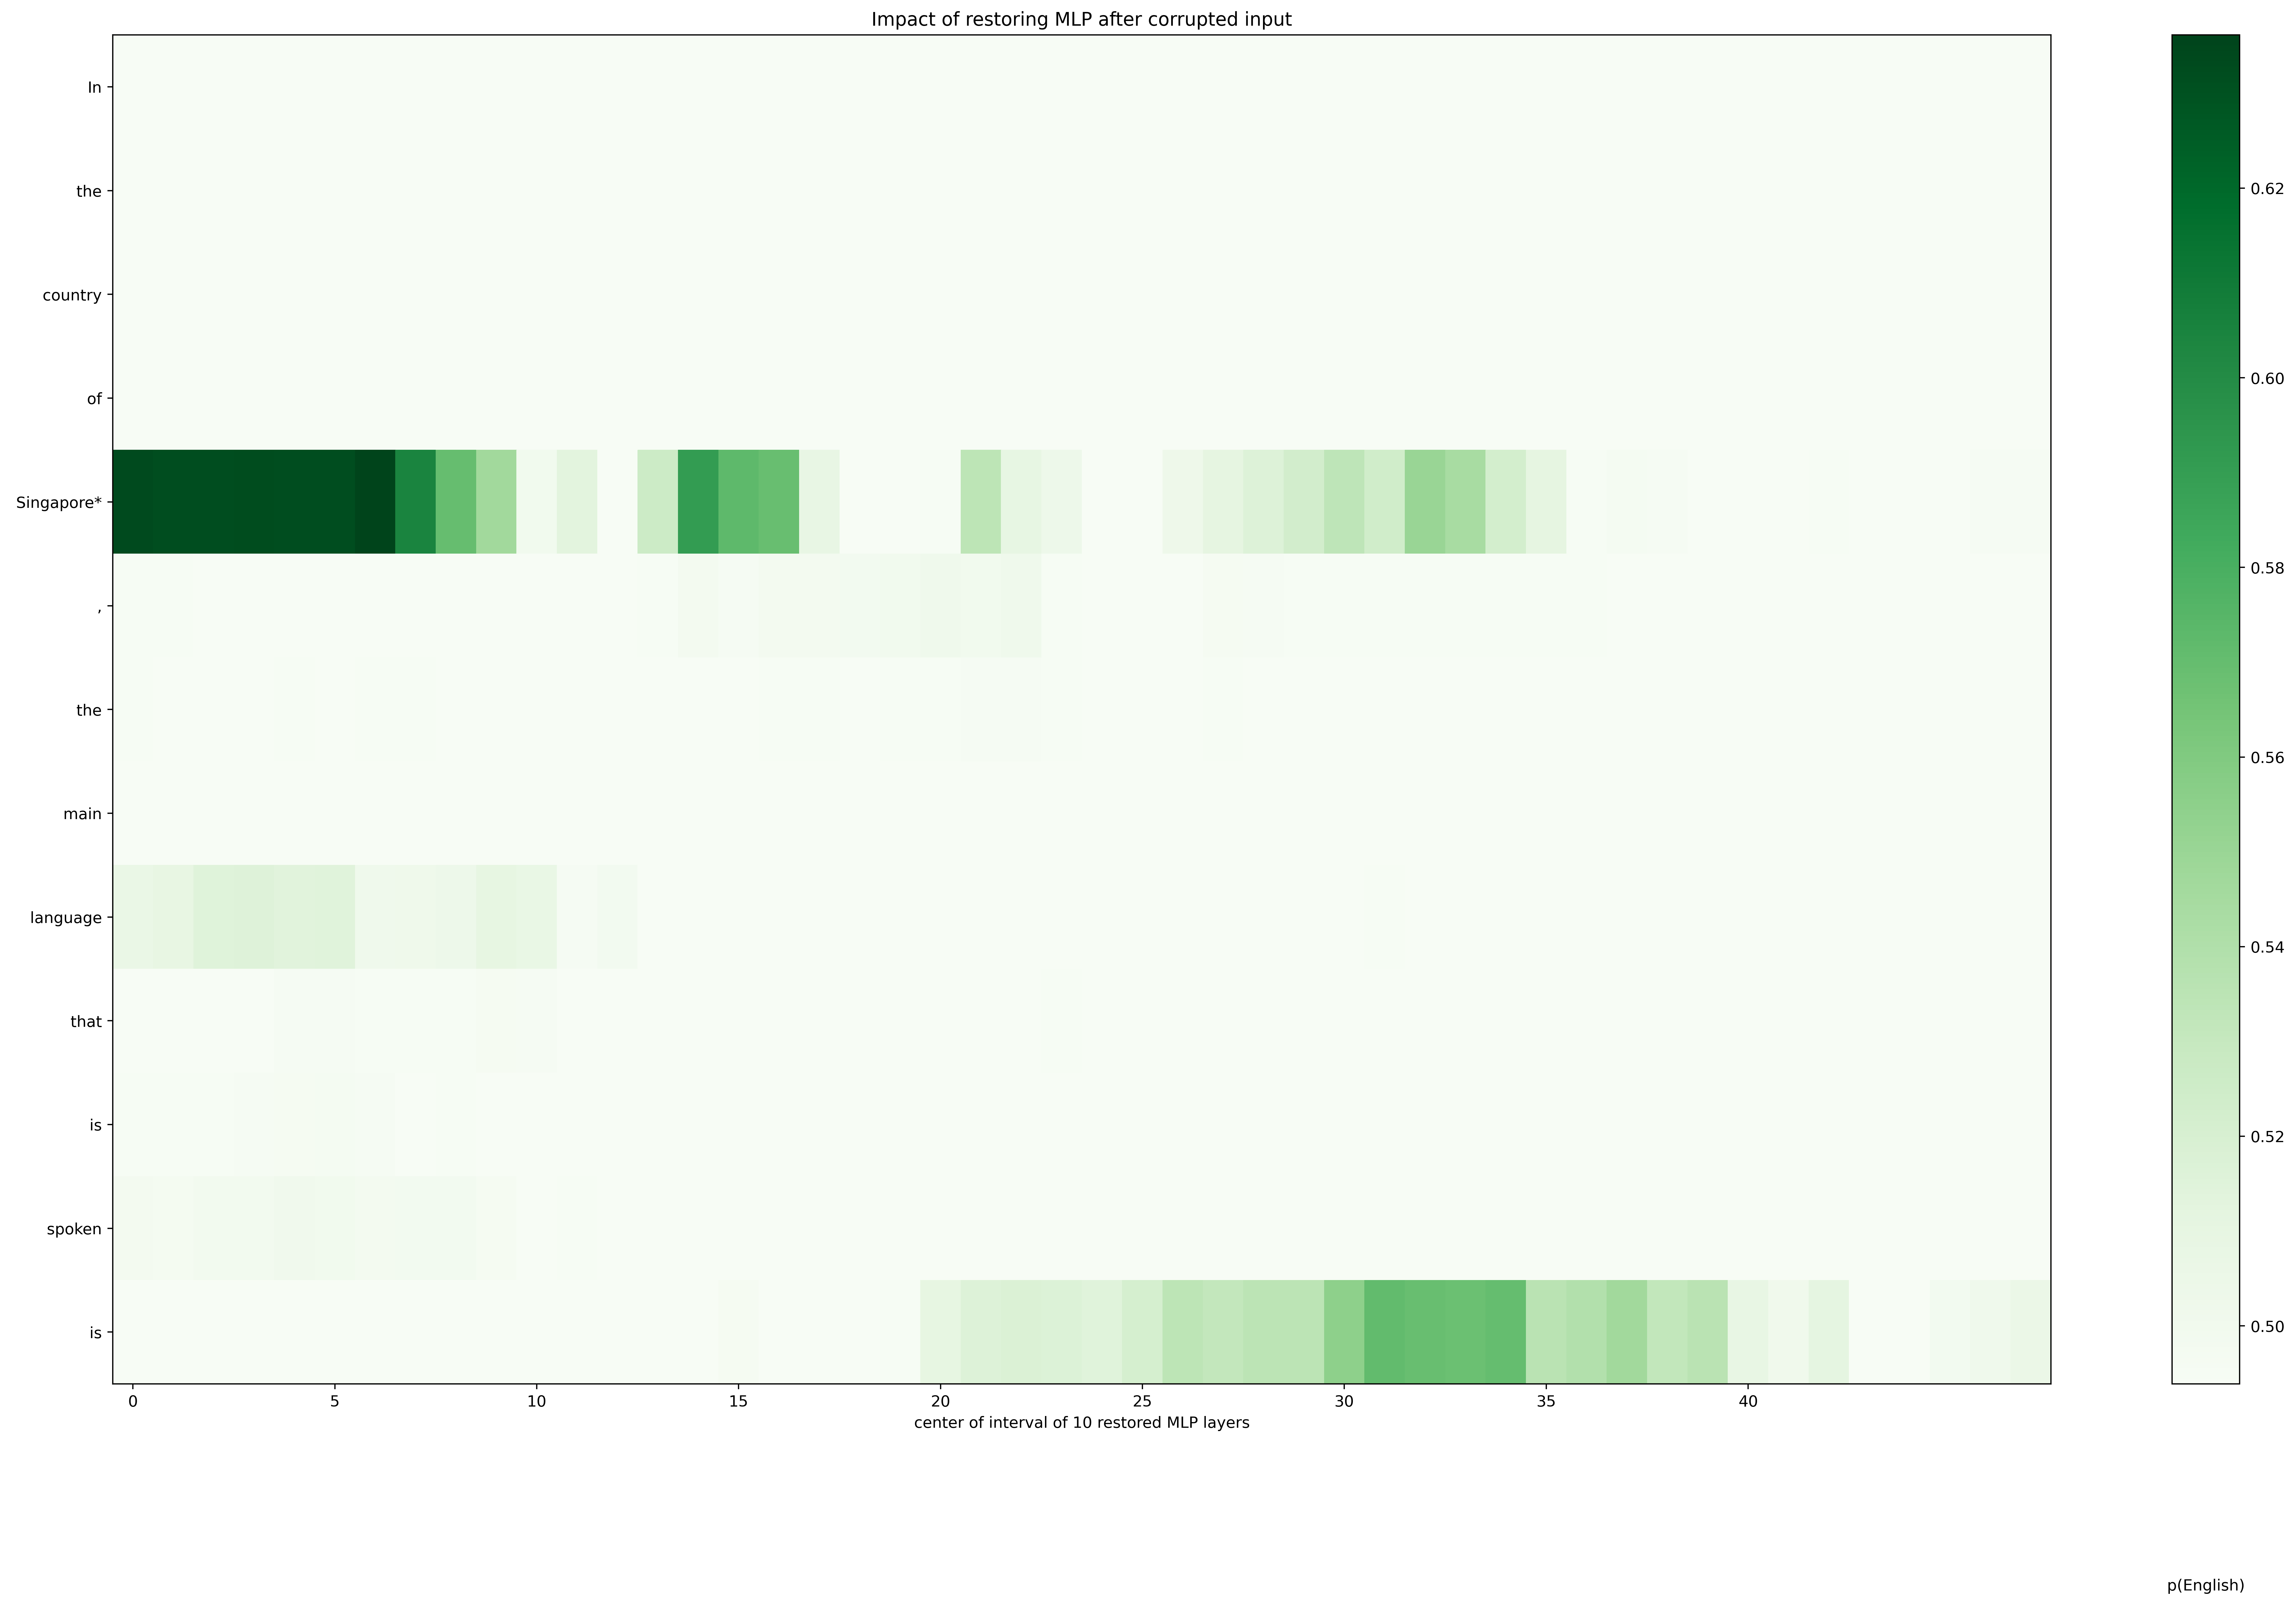

In [22]:
for prompt, subject in zip(prompts, subjects):
    plot_flows(mt, prompt, plots=['mlp'], subject=subject)

Here we trace a few more factual statements from a file of test cases.

In [49]:
knowns = KnownsDataset(DATA_DIR)

# for knowledge in knowns[0:1]:
#     plot_flows(mt, knowledge['prompt'], knowledge['subject'])

Loaded dataset with 1209 elements


Now, let's try to find out some interesting stuff using Causal Tracing. Are there some patterns we can recognize?

Let's run through the entire Known dataset and then have a look at some commonalities between the subjects that have more effect in the later layers than the earlier layers.

In [37]:
knowns[0]

{'known_id': 0,
 'subject': 'Vinson Massif',
 'attribute': 'Antarctica',
 'template': '{} is located in the continent',
 'prediction': ' of Antarctica. It is the largest of the three',
 'prompt': 'Vinson Massif is located in the continent of',
 'relation_id': 'P30'}

In [38]:
import json

good_cf_filename = "/content/drive/MyDrive/rome/data/good_counterfact_gpt2.json"
with open(good_cf_filename, 'r') as f:
    good_cfs = json.loads(f.read())

bad_cf_filename = "/content/drive/MyDrive/rome/data/bad_counterfacts_gpt2.json"
with open(bad_cf_filename) as f:
    bad_cfs = json.loads(f.read())

In [39]:
float(bad_cfs['0']['token_probs'][0][1])

0.9990845

In [40]:
uncertain_count = 0
certain_count = 0
bad_uncertain_cfs = {}
bad_certain_cfs = {}
for i in list(bad_cfs.keys()):
    first_gen_token_prob = float(bad_cfs[i]['token_probs'][0][1])
    if first_gen_token_prob < 0.2:
        bad_uncertain_cfs[uncertain_count] = bad_cfs[i]
        uncertain_count += 1
    elif first_gen_token_prob > 0.999:
        bad_certain_cfs[certain_count] = bad_cfs[i]
        certain_count += 1

print(uncertain_count)
print(certain_count)

486
9883


In [41]:
uncertain_count = 0
certain_count = 0
good_uncertain_cfs = {}
good_certain_cfs = {}
for i in list(good_cfs.keys()):
    first_gen_token_prob = float(good_cfs[i]['token_probs'][0][1])
    if first_gen_token_prob < 0.2:
        good_uncertain_cfs[uncertain_count] = good_cfs[i]
        uncertain_count += 1
    elif first_gen_token_prob > 0.999:
        good_certain_cfs[certain_count] = good_cfs[i]
        certain_count += 1

print(uncertain_count)
print(certain_count)

77
2677


In [19]:
savepdf = "/content/drive/MyDrive/rome/data/image.png"
if savepdf:
    print(os.path.dirname(savepdf))

/content/drive/MyDrive/rome/data


In [43]:
# import shutil
# shutil.rmtree('/content/rome/data/bad_uncertains')

In [44]:
results_dict = {}

In [45]:
from tqdm import tqdm
i = 0
plotsubset = "/content/drive/MyDrive/rome/data/bad_uncertains/"
os.makedirs(plotsubset, exist_ok=True)
# for knowledge in knowns[0:2]:
for i in tqdm(bad_uncertain_cfs):
    try:
        subject = bad_uncertain_cfs[i]['requested_rewrite']['subject']
        prompt = bad_uncertain_cfs[i]['requested_rewrite']['prompt'].replace("{}", subject)
        print(prompt)
        token_prob = str(round(float(bad_uncertain_cfs[i]['token_probs'][0][1]), 3)).replace(".", "p")
        pdf_name = token_prob + "_" + prompt.replace(' ', '_').replace(".", "_")
        pdf_name = re.sub('[^0-9a-zA-Z]', '_', pdf_name)
        print(pdf_name)
        print(token_prob)
        results_dict = plot_flows(mt, prompt, subject, plot_num=i,
                                include_plots=True, plots=["mlp"], 
                                savepdf=pdf_name, plotsubset=plotsubset, results_dict=results_dict)
    except:
        pass
    i += 1
    if i > 100:
        break

  0%|          | 0/486 [00:00<?, ?it/s]

Toko Yasuda, the
0p137_Toko_Yasuda__the
0p137


  0%|          | 1/486 [00:19<2:40:11, 19.82s/it]

The Loner was released on
0p107_The_Loner_was_released_on
0p107


  0%|          | 2/486 [00:39<2:38:46, 19.68s/it]

Charles IV of Spain's life ended in
0p019_Charles_IV_of_Spain_s_life_ended_in
0p019


  1%|          | 3/486 [01:06<3:04:24, 22.91s/it]

Flotation Toy Warning, founded in
0p084_Flotation_Toy_Warning__founded_in
0p084


  1%|          | 4/486 [01:29<3:04:29, 22.97s/it]

Luana Walters's profession is an
0p177_Luana_Walters_s_profession_is_an
0p177


  1%|          | 5/486 [01:52<3:03:39, 22.91s/it]

Pinhas Hirschprung passed away in
0p006_Pinhas_Hirschprung_passed_away_in
0p006


  1%|          | 6/486 [02:27<3:38:09, 27.27s/it]

Onufri works in the field of
0p051_Onufri_works_in_the_field_of
0p051


  1%|▏         | 7/486 [02:54<3:35:04, 26.94s/it]

The occupation of Sepala Attygalle is
0p017_The_occupation_of_Sepala_Attygalle_is
0p017


  2%|▏         | 8/486 [03:34<4:08:26, 31.19s/it]

Murphy Brown was originally aired on
0p157_Murphy_Brown_was_originally_aired_on
0p157


  2%|▏         | 9/486 [03:57<3:46:57, 28.55s/it]

Delchev Ridge is located in the continent
0p173_Delchev_Ridge_is_located_in_the_continent
0p173


  2%|▏         | 10/486 [04:23<3:40:55, 27.85s/it]

The language of Planet of the Apes was
0p008_The_language_of_Planet_of_the_Apes_was
0p008


  2%|▏         | 11/486 [04:58<3:58:54, 30.18s/it]

Novelas ejemplares was developed in
0p077_Novelas_ejemplares_was_developed_in
0p077


  2%|▏         | 12/486 [05:39<4:22:48, 33.27s/it]

The language of Rasayana is
0p041_The_language_of_Rasayana_is
0p041


  3%|▎         | 13/486 [06:01<3:57:21, 30.11s/it]

Joe Darensbourg is known for performing
0p117_Joe_Darensbourg_is_known_for_performing
0p117


  3%|▎         | 14/486 [06:37<4:09:32, 31.72s/it]

Matt Lavelle is known for performing
0p11_Matt_Lavelle_is_known_for_performing
0p11


  3%|▎         | 15/486 [07:03<3:56:38, 30.15s/it]

Cape Legoupil is located in the continent
0p049_Cape_Legoupil_is_located_in_the_continent
0p049


  3%|▎         | 16/486 [07:43<4:18:49, 33.04s/it]

Carol & Company was originally aired on
0p087_Carol___Company_was_originally_aired_on
0p087


  3%|▎         | 17/486 [08:10<4:02:56, 31.08s/it]

Neko Entertainment was formed in
0p049_Neko_Entertainment_was_formed_in
0p049


  4%|▎         | 18/486 [08:33<3:43:26, 28.65s/it]

The mother tongue of Toine Manders is
0p132_The_mother_tongue_of_Toine_Manders_is
0p132


  4%|▍         | 19/486 [09:08<3:58:15, 30.61s/it]

Heyday Films, founded in
0p043_Heyday_Films__founded_in
0p043


  4%|▍         | 20/486 [09:27<3:31:30, 27.23s/it]

Barnstable (village), Massachusetts, in
0p068_Barnstable__village___Massachusetts__in
0p068


  4%|▍         | 21/486 [10:03<3:51:41, 29.90s/it]

Robert Raymond passed away in
0p134_Robert_Raymond_passed_away_in
0p134


  5%|▍         | 22/486 [10:15<3:07:46, 24.28s/it]

In Kingdom of Tavolara, an official language is
0p1_In_Kingdom_of_Tavolara__an_official_language_is
0p1


  5%|▍         | 23/486 [10:59<3:54:08, 30.34s/it]

Manuel Ruiz Sosa, the
0p158_Manuel_Ruiz_Sosa__the
0p158


  5%|▍         | 24/486 [11:26<3:45:54, 29.34s/it]

The location of Radical War is
0p002_The_location_of_Radical_War_is
0p002


  5%|▌         | 25/486 [11:45<3:22:02, 26.30s/it]

The language of The Harvest Month was
0p111_The_language_of_The_Harvest_Month_was
0p111


  5%|▌         | 26/486 [12:08<3:13:25, 25.23s/it]

In Biasca, the language spoken is
0p003_In_Biasca__the_language_spoken_is
0p003


  6%|▌         | 27/486 [12:34<3:14:47, 25.46s/it]

James Rennell passed away in
0p154_James_Rennell_passed_away_in
0p154


  6%|▌         | 28/486 [12:57<3:08:36, 24.71s/it]

The native language of Francis Jammes is
0p01_The_native_language_of_Francis_Jammes_is
0p01


  6%|▌         | 29/486 [13:32<3:32:10, 27.86s/it]

Walker Digital was formed in
0p01_Walker_Digital_was_formed_in
0p01


  6%|▌         | 30/486 [13:43<2:53:45, 22.86s/it]

Cadillac Northstar LMP is developed by
0p062_Cadillac_Northstar_LMP_is_developed_by
0p062


  6%|▋         | 31/486 [14:24<3:33:08, 28.11s/it]

Kiev-Sviatoshyn Raion's capital city is
0p082_Kiev_Sviatoshyn_Raion_s_capital_city_is
0p082


  7%|▋         | 32/486 [15:46<5:36:35, 44.48s/it]

William Michael Rooke performs
0p02_William_Michael_Rooke_performs
0p02


  7%|▋         | 33/486 [15:58<4:21:13, 34.60s/it]

Jayakanthan speaks
0p033_Jayakanthan_speaks
0p033


  7%|▋         | 34/486 [16:09<3:28:30, 27.68s/it]

About Anglia, created in
0p023_About_Anglia__created_in
0p023


  7%|▋         | 35/486 [16:29<3:09:21, 25.19s/it]

James Morris Blaut works in the area of
0p06_James_Morris_Blaut_works_in_the_area_of
0p06


  7%|▋         | 36/486 [17:04<3:31:27, 28.19s/it]

Gabriel Heinze plays in the position of
0p14_Gabriel_Heinze_plays_in_the_position_of
0p14


  8%|▊         | 37/486 [17:39<3:46:41, 30.29s/it]

Jean Titelouze's occupation is
0p121_Jean_Titelouze_s_occupation_is
0p121


  8%|▊         | 38/486 [18:06<3:38:15, 29.23s/it]

Crossing Lines premieres on
0p028_Crossing_Lines_premieres_on
0p028


  8%|▊         | 39/486 [18:25<3:15:44, 26.27s/it]

The profession of Charles FitzGerald, 1st Baron Lecale is
0p141_The_profession_of_Charles_FitzGerald__1st_Baron_Lecale_is
0p141


  8%|▊         | 40/486 [19:58<5:43:18, 46.19s/it]

Agilbert, who has the position of
0p191_Agilbert__who_has_the_position_of
0p191


  8%|▊         | 41/486 [20:33<5:17:29, 42.81s/it]

Jim Magilton plays in the position of
0p015_Jim_Magilton_plays_in_the_position_of
0p015


  9%|▊         | 42/486 [20:59<4:40:03, 37.85s/it]

The domain of work of Nicole-Reine Lepaute is
0p147_The_domain_of_work_of_Nicole_Reine_Lepaute_is
0p147


  9%|▉         | 43/486 [22:14<6:01:12, 48.92s/it]

Snowbeast was released on
0p124_Snowbeast_was_released_on
0p124


  9%|▉         | 44/486 [22:33<4:55:07, 40.06s/it]

Joe Magrane, the
0p106_Joe_Magrane__the
0p106


  9%|▉         | 45/486 [22:45<3:51:15, 31.46s/it]

The headquarter of Samsung is in
0p137_The_headquarter_of_Samsung_is_in
0p137


  9%|▉         | 46/486 [23:07<3:30:38, 28.72s/it]

Selfish Cunt was formed in
0p159_Selfish_Cunt_was_formed_in
0p159


 10%|▉         | 47/486 [23:30<3:17:32, 27.00s/it]

Nathan Appleton worked in the city of
0p166_Nathan_Appleton_worked_in_the_city_of
0p166


 10%|▉         | 48/486 [24:05<3:35:01, 29.46s/it]

Vega4 that was founded in
0p078_Vega4_that_was_founded_in
0p078


 10%|█         | 49/486 [24:28<3:19:53, 27.44s/it]

Joan Dickson was born in
0p152_Joan_Dickson_was_born_in
0p152


 10%|█         | 50/486 [24:51<3:09:38, 26.10s/it]

Darol Anger, the
0p005_Darol_Anger__the
0p005


 10%|█         | 51/486 [25:02<2:37:11, 21.68s/it]

Carpentras, in
0p05_Carpentras__in
0p05


 11%|█         | 52/486 [25:22<2:32:13, 21.05s/it]

Betsson, founded in
0p125_Betsson__founded_in
0p125


 11%|█         | 53/486 [25:33<2:10:36, 18.10s/it]

Thomas Vose Daily holds the position of
0p008_Thomas_Vose_Daily_holds_the_position_of
0p008


 11%|█         | 54/486 [26:00<2:28:26, 20.62s/it]

Alabama Shakes was founded in
0p005_Alabama_Shakes_was_founded_in
0p005


 11%|█▏        | 55/486 [26:19<2:25:29, 20.25s/it]

Friday Night Videos was released on
0p085_Friday_Night_Videos_was_released_on
0p085


 12%|█▏        | 56/486 [26:39<2:24:11, 20.12s/it]

MacPaint was created by
0p063_MacPaint_was_created_by
0p063


 12%|█▏        | 57/486 [26:58<2:22:13, 19.89s/it]

The genre played by Hugo Weisgall is
0p023_The_genre_played_by_Hugo_Weisgall_is
0p023


 12%|█▏        | 58/486 [27:33<2:54:38, 24.48s/it]

Second Verdict was released on
0p102_Second_Verdict_was_released_on
0p102


 12%|█▏        | 59/486 [27:53<2:43:23, 22.96s/it]

myGRAIN was founded in
0p105_myGRAIN_was_founded_in
0p105


 12%|█▏        | 60/486 [28:16<2:42:55, 22.95s/it]

Hjalmar Branting passed away in
0p035_Hjalmar_Branting_passed_away_in
0p035


 13%|█▎        | 61/486 [28:51<3:09:40, 26.78s/it]

The language of Van der Valk was
0p197_The_language_of_Van_der_Valk_was
0p197


 13%|█▎        | 62/486 [29:18<3:08:39, 26.70s/it]

The twin city of Chicago is
0p182_The_twin_city_of_Chicago_is
0p182


 13%|█▎        | 63/486 [29:37<2:52:00, 24.40s/it]

What does Dhoom 3 play? They play
0p159_What_does_Dhoom_3_play__They_play
0p159


 13%|█▎        | 64/486 [30:12<3:13:46, 27.55s/it]

Marie Versini's occupation is
0p027_Marie_Versini_s_occupation_is
0p027


 13%|█▎        | 65/486 [30:31<2:56:10, 25.11s/it]

Rampart Ridge belongs to the continent of
0p034_Rampart_Ridge_belongs_to_the_continent_of
0p034


 14%|█▎        | 66/486 [31:06<3:16:53, 28.13s/it]

Iraq Football Association is a part of the
0p169_Iraq_Football_Association_is_a_part_of_the
0p169


 14%|█▍        | 67/486 [31:33<3:12:32, 27.57s/it]

The language used by Salvatore Accardo is
0p184_The_language_used_by_Salvatore_Accardo_is
0p184


 14%|█▍        | 68/486 [32:12<3:37:34, 31.23s/it]

The domain of work of Svante August Arrhenius is
0p017_The_domain_of_work_of_Svante_August_Arrhenius_is
0p017


 14%|█▍        | 69/486 [33:34<5:22:40, 46.43s/it]

Yangtze is in
0p003_Yangtze_is_in
0p003


 14%|█▍        | 70/486 [33:46<4:09:01, 35.92s/it]

The twin city of Karachi is
0p179_The_twin_city_of_Karachi_is
0p179


 15%|█▍        | 71/486 [34:05<3:33:22, 30.85s/it]

The profession of Jill Hyem is
0p004_The_profession_of_Jill_Hyem_is
0p004


 15%|█▍        | 72/486 [34:27<3:16:04, 28.42s/it]

Halle Berry's profession is a
0p009_Halle_Berry_s_profession_is_a
0p009


 15%|█▌        | 73/486 [34:50<3:03:52, 26.71s/it]

Odbert Island is a part of the continent of
0p014_Odbert_Island_is_a_part_of_the_continent_of
0p014


 15%|█▌        | 74/486 [35:34<3:39:21, 31.95s/it]

Wohlthat Mountains is a part of the continent of
0p052_Wohlthat_Mountains_is_a_part_of_the_continent_of
0p052


 15%|█▌        | 75/486 [36:19<4:03:55, 35.61s/it]

The mother tongue of Yuliya Snigir is
0p054_The_mother_tongue_of_Yuliya_Snigir_is
0p054


 16%|█▌        | 76/486 [37:03<4:22:08, 38.36s/it]

MMA Live premieres on
0p011_MMA_Live_premieres_on
0p011


 16%|█▌        | 77/486 [37:23<3:42:51, 32.69s/it]

Don Lusher performs
0p134_Don_Lusher_performs
0p134


 16%|█▌        | 78/486 [37:32<2:54:00, 25.59s/it]

Semyon Vorontsov is originally from
0p121_Semyon_Vorontsov_is_originally_from
0p121


 16%|█▋        | 79/486 [38:08<3:14:12, 28.63s/it]

Mercer Ellington plays
0p044_Mercer_Ellington_plays
0p044


 16%|█▋        | 80/486 [38:27<2:55:44, 25.97s/it]

Dodge Challenger, developed by
0p145_Dodge_Challenger__developed_by
0p145


 17%|█▋        | 81/486 [38:47<2:42:00, 24.00s/it]

Urban Outfitters was formed in
0p004_Urban_Outfitters_was_formed_in
0p004


 17%|█▋        | 82/486 [39:10<2:39:30, 23.69s/it]

selenium, which is named for
0p144_selenium__which_is_named_for
0p144


 17%|█▋        | 83/486 [39:32<2:36:44, 23.34s/it]

The language used by Giovanni Bertati is
0p014_The_language_used_by_Giovanni_Bertati_is
0p014


 17%|█▋        | 84/486 [39:58<2:42:13, 24.21s/it]

Frank Markham worked in the city of
0p107_Frank_Markham_worked_in_the_city_of
0p107


 17%|█▋        | 85/486 [40:25<2:45:52, 24.82s/it]

Flavio Zanonato, who has the position of
0p061_Flavio_Zanonato__who_has_the_position_of
0p061


 18%|█▊        | 86/486 [41:33<4:11:38, 37.75s/it]

The Banana Splits premieres on
0p185_The_Banana_Splits_premieres_on
0p185


 18%|█▊        | 87/486 [41:56<3:41:29, 33.31s/it]

Doriva, who plays the position
0p051_Doriva__who_plays_the_position
0p051


 18%|█▊        | 88/486 [42:22<3:26:53, 31.19s/it]

The original language of Yalkut Yosef is
0p094_The_original_language_of_Yalkut_Yosef_is
0p094


 18%|█▊        | 89/486 [43:01<3:43:20, 33.75s/it]

Bobby Hull is a professional
0p06_Bobby_Hull_is_a_professional
0p06


 19%|█▊        | 90/486 [43:21<3:14:24, 29.46s/it]

The official language of Tavannes is
0p115_The_official_language_of_Tavannes_is
0p115


 19%|█▊        | 91/486 [43:47<3:07:36, 28.50s/it]

Toronto is a twin city of
0p031_Toronto_is_a_twin_city_of
0p031


 19%|█▉        | 92/486 [44:06<2:48:27, 25.65s/it]

Anton Zeilinger works in the field of
0p196_Anton_Zeilinger_works_in_the_field_of
0p196


 19%|█▉        | 93/486 [44:46<3:15:47, 29.89s/it]

Real People premieres on
0p19_Real_People_premieres_on
0p19


 19%|█▉        | 94/486 [44:57<2:38:48, 24.31s/it]

Ken O'Brien plays in the position of
0p164_Ken_O_Brien_plays_in_the_position_of
0p164


 20%|█▉        | 95/486 [45:32<2:59:38, 27.57s/it]

Noel Mewton-Wood, performing on the
0p09_Noel_Mewton_Wood__performing_on_the
0p09


 20%|█▉        | 96/486 [46:12<3:23:33, 31.32s/it]

In Janakkala, the language spoken is
0p073_In_Janakkala__the_language_spoken_is
0p073


 20%|██        | 98/486 [46:52<2:33:06, 23.68s/it]

Vladimír Růžička, the
0p017_Vladim_r_R__i_ka__the
0p017
Skylar Grey, performing on the
0p077_Skylar_Grey__performing_on_the
0p077


 20%|██        | 99/486 [47:15<2:30:54, 23.40s/it]

The official religion of Amānullāh Khān is
0p121_The_official_religion_of_Am_null_h_Kh_n_is
0p121


 21%|██        | 100/486 [48:30<4:10:23, 38.92s/it]

Mark Malone plays as
0p188_Mark_Malone_plays_as
0p188


 21%|██        | 100/486 [48:39<3:07:48, 29.19s/it]


In [46]:
from tqdm import tqdm
i = 0
# results_dict = {}
plotsubset = "/content/drive/MyDrive/rome/data/knowns/"
os.makedirs(plotsubset, exist_ok=True)
for known in tqdm(knowns[0:50]):
    try:
        subject = known['subject']
        prompt = known['prompt'].replace("{}", subject)
        pdf_name = prompt.replace(' ', '_').replace(".", "_")
        pdf_name = re.sub('[^0-9a-zA-Z]', '_', pdf_name)
        print(pdf_name)
        results_dict = plot_flows(mt, prompt, subject, plot_num=i,
                                include_plots=True, plots=["mlp"], 
                                savepdf=pdf_name, plotsubset=plotsubset, results_dict=results_dict)
    except:
        pass
    i += 1
    # if i > 400:
    #     break

  0%|          | 0/50 [00:00<?, ?it/s]

Vinson_Massif_is_located_in_the_continent_of


  2%|▏         | 1/50 [00:39<32:12, 39.45s/it]

Beats_Music_is_owned_by


  4%|▍         | 2/50 [00:58<22:07, 27.65s/it]

Audible_com_is_owned_by


  6%|▌         | 3/50 [01:21<19:57, 25.49s/it]

The_Big_Bang_Theory_premieres_on


  8%|▊         | 4/50 [01:44<18:45, 24.48s/it]

MacApp__a_product_created_by


 10%|█         | 5/50 [02:07<17:49, 23.76s/it]

Giuseppe_Angeli__who_has_a_citizenship_of


 12%|█▏        | 6/50 [02:51<22:34, 30.78s/it]

Catalonia_belongs_to_the_continent_of


 14%|█▍        | 7/50 [03:14<20:06, 28.06s/it]

In_Marshall_Islands__the_language_spoken_is_a_mixture_of


 16%|█▌        | 8/50 [03:57<23:02, 32.93s/it]

Leslie_Moonves_is_employed_by


 18%|█▊        | 9/50 [04:20<20:21, 29.80s/it]

The_original_language_of_De_finibus_bonorum_et_malorum_is_the_same_as_the


 20%|██        | 10/50 [06:07<35:47, 53.68s/it]

Kirkpatrick_Glacier_belongs_to_the_continent_of


 22%|██▏       | 11/50 [06:42<31:11, 47.99s/it]

The_headquarter_of_Army_of_the_Guardians_of_the_Islamic_Revolution_is_in


 24%|██▍       | 12/50 [08:04<36:53, 58.25s/it]

Il_Gazzettino_was_written_in_the_early_1980s__when_the


 26%|██▌       | 13/50 [09:34<41:49, 67.83s/it]

Xamarin__from_the


 28%|██▊       | 14/50 [09:53<31:54, 53.19s/it]

Eavan_Boland_was_born_in


 30%|███       | 15/50 [10:16<25:42, 44.06s/it]

Comme_j_ai_mal_is_written_in


 32%|███▏      | 16/50 [10:52<23:31, 41.52s/it]

The_language_used_by_Juan_Bautista_de_Anza_is_a_bit_different_from_the_language_used_by_the


 34%|███▍      | 17/50 [13:20<40:35, 73.80s/it]

Alfred_Hitchcock_Presents_debuted_on


 36%|███▌      | 18/50 [13:44<31:14, 58.58s/it]

Tizen_is_developed_by_a_consortium_of_companies_including


 38%|███▊      | 19/50 [14:22<27:12, 52.66s/it]

Honus_Wagner_professionally_plays_the_sport_of


 40%|████      | 20/50 [14:49<22:21, 44.73s/it]

samurai_cinema__that_originated_in


 42%|████▏     | 21/50 [15:11<18:25, 38.12s/it]

The_capital_of_Roman_Republic_is


 44%|████▍     | 22/50 [15:31<15:08, 32.44s/it]

Henri_Debain_was_born_in


 46%|████▌     | 23/50 [15:54<13:19, 29.60s/it]

Adriano_Celentano_is_a_citizen_of


 48%|████▊     | 24/50 [16:34<14:11, 32.75s/it]

Czech_Republic_national_football_team_is_a_member_of_the


 50%|█████     | 25/50 [17:18<15:07, 36.32s/it]

Windows_Media_Player_is_developed_by


 52%|█████▏    | 26/50 [17:38<12:29, 31.23s/it]

NTFS_is_developed_by


 54%|█████▍    | 27/50 [17:57<10:36, 27.69s/it]

Knud__Hereditary_Prince_of_Denmark_passed_away_in


 56%|█████▌    | 28/50 [18:42<12:06, 33.01s/it]

Don_Shula_professionally_plays_the_sport_of


 58%|█████▊    | 29/50 [19:09<10:50, 30.98s/it]

The_language_of_El_Mercurio_was_a_mixture_of


 60%|██████    | 30/50 [19:53<11:38, 34.91s/it]

Iron_Man_is_affiliated_with_the


 62%|██████▏   | 31/50 [20:12<09:33, 30.19s/it]

The_location_of_Massachusetts_Institute_of_Technology_is_in


 64%|██████▍   | 32/50 [20:47<09:30, 31.67s/it]

Vietnam_belongs_to_the_continent_of


 66%|██████▌   | 33/50 [21:14<08:34, 30.26s/it]

The_Tonight_Show_with_Jay_Leno_premieres_on


 68%|██████▊   | 34/50 [21:54<08:52, 33.27s/it]

Philippines_s_capital_


 70%|███████   | 35/50 [22:06<06:39, 26.66s/it]

Frederick_Banting_specializes_in_the_study_of_the


 72%|███████▏  | 36/50 [22:45<07:06, 30.49s/it]

Clifford_Curzon__performing_on_the


 74%|███████▍  | 37/50 [23:20<06:55, 31.96s/it]

Windows_Media_Audio__a_product_developed_by


 76%|███████▌  | 38/50 [23:47<06:02, 30.24s/it]

The_location_of_Galatasaray_University_is_in_the_heart_of


 78%|███████▊  | 39/50 [25:01<07:56, 43.35s/it]

In_Nokia__the_language_spoken_is


 80%|████████  | 40/50 [25:23<06:10, 37.04s/it]

Northern_Nigeria_Protectorate_follows_the_religion_of


 82%|████████▏ | 41/50 [25:49<05:04, 33.88s/it]

Deobandi_follows_the_religion_of


 84%|████████▍ | 42/50 [26:12<04:04, 30.53s/it]

Odnoklassniki_was_written_in_the_early_1990s_by_a_group_of


 86%|████████▌ | 43/50 [27:58<06:12, 53.25s/it]

Zeno_of_Verona_holds_the_position_of_the_first


 88%|████████▊ | 44/50 [28:43<05:03, 50.58s/it]

Jean_Pierre_Van_Rossem__who_has_a_citizenship_of


 90%|█████████ | 45/50 [29:51<04:38, 55.75s/it]

Joseph_Schumpeter_s_domain_of_work_is_the


 92%|█████████▏| 46/50 [30:30<03:23, 50.86s/it]

Felix_Salmon__who_works_as_a


 94%|█████████▍| 47/50 [30:56<02:10, 43.47s/it]

Grand_Duchy_of_Finland_s_capital_


 96%|█████████▌| 48/50 [31:32<01:22, 41.12s/it]

Goodreads_owner__and_former


 98%|█████████▊| 49/50 [31:51<00:34, 34.53s/it]

Rhine_belongs_to_the_continent_of


100%|██████████| 50/50 [32:14<00:00, 38.68s/it]


In [47]:
for i in tqdm(good_certain_cfs):
    try:
        subject = good_certain_cfs[i]['requested_rewrite']['subject']
        prompt = good_certain_cfs[i]['requested_rewrite']['prompt'].replace("{}", subject)
        token_prob = str(round(float(good_certain_cfs[i]['token_probs'][0][1]), 3)).replace(".", "p")
        pdf_name = token_prob + "_" + prompt.replace(' ', '_').replace(".", "_")
        pdf_name = re.sub('[^0-9a-zA-Z]', '_', pdf_name)
        print(pdf_name)
        print(token_prob)
        results_dict = plot_flows(mt, prompt, subject, plot_num=i,
                                include_plots=True, plots=["mlp"], 
                                savepdf=pdf_name, plotsubset=plotsubset, results_dict=results_dict)
    except:
        pass
    i += 1
    if i > 100:
        break

  0%|          | 0/2677 [00:00<?, ?it/s]

1p0_The_mother_tongue_of_Danielle_Darrieux_is
1p0


  0%|          | 1/2677 [00:35<26:05:29, 35.10s/it]

1p0_The_mother_tongue_of_Go_Hyeon_jeong_is
1p0


  0%|          | 2/2677 [01:43<40:33:08, 54.58s/it]

0p999_Porsche_911__created_by
0p999


  0%|          | 3/2677 [02:02<28:35:38, 38.50s/it]

1p0_Jeep_Commander_is_produced_by
1p0


  0%|          | 4/2677 [02:22<22:58:16, 30.94s/it]

1p0_The_mother_tongue_of_Jean_Galland_is
1p0


  0%|          | 5/2677 [02:48<21:42:09, 29.24s/it]

1p0_Tapio_Kantanen_is_a_citizen_of
1p0


  0%|          | 6/2677 [03:23<23:14:27, 31.32s/it]

1p0_Toyota_Cresta__developed_by
1p0


  0%|          | 7/2677 [03:46<21:12:06, 28.59s/it]

0p999_In_Nykarleby__the_language_spoken_is
0p999


  0%|          | 8/2677 [04:25<23:45:01, 32.03s/it]

1p0_Windows_Embedded_CE_6_0_is_a_product_of
1p0


  0%|          | 9/2677 [05:10<26:44:35, 36.09s/it]

1p0_Nathuram_Godse__a_citizen_of
1p0


  0%|          | 10/2677 [05:50<27:37:18, 37.28s/it]

1p0_Stefanos_Stratigos_is_a_native_speaker_of
1p0


  0%|          | 11/2677 [06:35<29:16:57, 39.54s/it]

1p0_Ipsos_MORI_s_headquarters_are_in
1p0


  0%|          | 12/2677 [07:10<28:19:59, 38.27s/it]

1p0_The_official_religion_of_Jahangir_is
1p0


  0%|          | 13/2677 [07:37<25:37:03, 34.62s/it]

1p0_The_official_religion_of_Uwais_Qarni_is
1p0


  1%|          | 14/2677 [08:21<27:52:02, 37.67s/it]

1p0_Ostankinsky_District_is_within
1p0


  1%|          | 15/2677 [08:45<24:37:09, 33.29s/it]

1p0_Saratov_Oblast__in
1p0


  1%|          | 16/2677 [09:08<22:20:49, 30.23s/it]

1p0_Yamaha_TZR250_is_developed_by
1p0


  1%|          | 17/2677 [09:48<24:34:15, 33.25s/it]

1p0_Honda_Insight_is_produced_by
1p0


  1%|          | 18/2677 [10:07<21:28:27, 29.07s/it]

1p0_The_headquarters_of_Northeastern_University_is_in
1p0


  1%|          | 19/2677 [10:34<20:49:46, 28.21s/it]

1p0_Irakli_Alasania_has_a_citizenship_from
1p0


  1%|          | 20/2677 [11:09<22:24:38, 30.36s/it]

1p0_Iosif_Rotariu_plays_as
1p0


  1%|          | 21/2677 [11:36<21:38:30, 29.33s/it]

1p0_BMW_E23__developed_by
1p0


  1%|          | 22/2677 [11:59<20:12:34, 27.40s/it]

1p0_The_law_in_Bahia_declares_the_language
1p0


  1%|          | 23/2677 [12:25<19:53:05, 26.97s/it]

0p999_The_native_language_of_Pierre_Messmer_is
0p999


  1%|          | 24/2677 [12:51<19:43:12, 26.76s/it]

1p0_Magnus_Carlsen__who_holds_a_citizenship_from
1p0


  1%|          | 25/2677 [13:30<22:30:14, 30.55s/it]

1p0_The_original_language_of_Wild_Reeds_is
1p0


  1%|          | 26/2677 [13:57<21:32:03, 29.24s/it]

1p0_Mehmed_the_Conqueror_is_affiliated_with_the_religion
1p0


  1%|          | 27/2677 [14:41<24:55:46, 33.87s/it]

1p0_Princeton_University_Press_s_headquarters_are_in
1p0


  1%|          | 28/2677 [15:08<23:17:22, 31.65s/it]

1p0_The_mother_tongue_of_Ilya_Ehrenburg_is
1p0


  1%|          | 29/2677 [15:47<25:03:12, 34.06s/it]

0p999_Ritt_Bjerregaard_has_a_citizenship_from
0p999


  1%|          | 30/2677 [16:32<27:27:23, 37.34s/it]

1p0_Microsoft_Visual_Studio_was_a_product_of
1p0


  1%|          | 31/2677 [16:55<24:12:58, 32.95s/it]

1p0_The_official_language_of_Italy_is
1p0


  1%|          | 32/2677 [17:14<21:07:58, 28.76s/it]

1p0_The_official_religion_of_As_Saffah_is
1p0


  1%|          | 33/2677 [17:54<23:31:59, 32.04s/it]

1p0_Julien_Courbet_is_a_native_speaker_of
1p0


  1%|▏         | 34/2677 [18:29<24:11:34, 32.95s/it]

1p0_Fiat_124_is_a_product_of
1p0


  1%|▏         | 35/2677 [18:52<21:55:47, 29.88s/it]

1p0_Hank_Aaron_professionally_plays_the_sport
1p0


  1%|▏         | 36/2677 [19:14<20:20:59, 27.74s/it]

1p0_Renault_Vel_Satis_is_created_by
1p0


  1%|▏         | 37/2677 [19:41<20:06:33, 27.42s/it]

1p0_The_mother_tongue_of_Alain_Robbe_Grillet_is
1p0


  1%|▏         | 38/2677 [20:49<29:03:27, 39.64s/it]

1p0_Matusevich_Glacier_is_located_in_the_continent
1p0


  1%|▏         | 39/2677 [21:24<28:02:22, 38.26s/it]

1p0_Kalamazoo_County_can_be_found_in
1p0


  1%|▏         | 40/2677 [21:51<25:25:50, 34.72s/it]

1p0_Jonathan_Haidt_works_in_the_field_of
1p0


  2%|▏         | 41/2677 [22:26<25:30:11, 34.83s/it]

1p0_The_official_religion_of_Sangha_is
1p0


  2%|▏         | 42/2677 [22:48<22:47:01, 31.13s/it]

1p0_Which_position_does_Kamohelo_Mokotjo_play__They_play_as
1p0


  2%|▏         | 43/2677 [24:26<37:28:59, 51.23s/it]

1p0_Holy_Name_Cathedral__Chicago_can_be_found_in
1p0


  2%|▏         | 44/2677 [25:02<33:59:10, 46.47s/it]

1p0_The_native_language_of_Anatole_France_is
1p0


  2%|▏         | 45/2677 [25:28<29:32:00, 40.40s/it]

1p0_The_mother_tongue_of_Christian_Bouchet_is
1p0


  2%|▏         | 46/2677 [25:54<26:24:58, 36.15s/it]

1p0_The_Late_Late_Show_with_Craig_Ferguson_premieres_on
1p0


  2%|▏         | 47/2677 [26:34<27:18:40, 37.38s/it]

1p0_The_official_language_of_Caslano_is
1p0


  2%|▏         | 48/2677 [27:01<24:50:54, 34.03s/it]

1p0_Pervez_Musharraf_follows_the_religion_of
1p0


  2%|▏         | 49/2677 [27:41<26:08:17, 35.81s/it]

1p0_Romulus_Glacier_belongs_to_the_continent_of
1p0


  2%|▏         | 50/2677 [28:07<24:01:54, 32.93s/it]

1p0_Fabrice_Luchini__a_native
1p0


  2%|▏         | 51/2677 [28:34<22:39:44, 31.07s/it]

1p0_Apple_III_is_created_by
1p0


  2%|▏         | 52/2677 [28:45<18:18:27, 25.11s/it]

1p0_The_mother_tongue_of_Adriaan_van_Dis_is
1p0


  2%|▏         | 53/2677 [29:24<21:29:06, 29.48s/it]

1p0_The_official_language_of_Guam_is
1p0


  2%|▏         | 54/2677 [29:43<19:11:02, 26.33s/it]

1p0_Where_is_Uruguayan_War__It_is_located_in
1p0


  2%|▏         | 55/2677 [30:27<23:02:20, 31.63s/it]

1p0_What_sport_does_R_A__Dickey_play__They_play
1p0


  2%|▏         | 56/2677 [31:42<32:27:10, 44.57s/it]

1p0_New_Nintendo_3DS_is_developed_by
1p0


  2%|▏         | 57/2677 [32:05<27:42:48, 38.08s/it]

1p0_Final_Fantasy_is_created_by
1p0


  2%|▏         | 58/2677 [32:16<21:50:07, 30.01s/it]

1p0_The_capital_of_Democratic_Republic_of_Afghanistan_is
1p0


  2%|▏         | 59/2677 [32:43<21:03:01, 28.95s/it]

1p0_The_official_religion_of_John_Travolta_is
1p0


  2%|▏         | 60/2677 [33:22<23:23:17, 32.17s/it]

1p0_Uusimaa__which_has_the_capital_city
1p0


  2%|▏         | 61/2677 [34:02<24:57:22, 34.34s/it]

1p0_Bakuman_from
1p0


  2%|▏         | 62/2677 [34:11<19:25:20, 26.74s/it]

1p0_The_mother_tongue_of_Miguel_de_Cervantes_is
1p0


  2%|▏         | 63/2677 [34:51<22:14:23, 30.63s/it]

1p0_OS_X_Mavericks__developed_by
1p0


  2%|▏         | 64/2677 [35:10<19:46:34, 27.25s/it]

1p0_Saladin_follows_the_religion_of
1p0


  2%|▏         | 65/2677 [35:29<18:00:49, 24.83s/it]

1p0_Junnar__which_is_located_in
1p0


  2%|▏         | 66/2677 [35:55<18:18:16, 25.24s/it]

1p0_The_law_in_Donetsk_People_s_Republic_declares_the_language
1p0


  3%|▎         | 67/2677 [36:35<21:23:02, 29.50s/it]

1p0_British_Railways_Board_s_headquarters_are_in
1p0


  3%|▎         | 68/2677 [37:01<20:43:06, 28.59s/it]

1p0_Which_position_does_Chase_Clement_play__They_play_as
1p0


  3%|▎         | 69/2677 [37:40<22:55:41, 31.65s/it]

1p0_Nokia_N70__produced_by
1p0


  3%|▎         | 70/2677 [38:03<21:01:36, 29.04s/it]

1p0_Philip_Walsingham_Sergeant_was_native_to
1p0


  3%|▎         | 71/2677 [38:38<22:26:20, 31.00s/it]

1p0_Germaine_Greer_s_expertise_is
1p0


  3%|▎         | 72/2677 [39:05<21:29:36, 29.70s/it]

1p0_Honda_Concerto_is_a_product_of
1p0


  3%|▎         | 73/2677 [39:32<20:47:32, 28.75s/it]

1p0_The_official_religion_of_Tang_Empire_is
1p0


  3%|▎         | 74/2677 [39:54<19:25:54, 26.87s/it]

1p0_Dodge_Polara_is_produced_by
1p0


  3%|▎         | 75/2677 [40:17<18:33:57, 25.69s/it]

1p0_Stockholm_Pride_is_located_in
1p0


  3%|▎         | 76/2677 [40:36<17:11:04, 23.78s/it]

1p0_Nokia_Lumia_900_is_created_by
1p0


  3%|▎         | 77/2677 [40:59<16:59:39, 23.53s/it]

1p0_Symbian_was_a_product_of
1p0


  3%|▎         | 78/2677 [41:22<16:48:51, 23.29s/it]

1p0_Malik_al_Ashtar_is_affiliated_with_the_religion
1p0


  3%|▎         | 79/2677 [42:07<21:25:59, 29.70s/it]

1p0_Azerbaijan_Tower_is_owned_by
1p0


  3%|▎         | 80/2677 [42:42<22:41:58, 31.47s/it]

1p0_Abdurrahman_Wahid_is_follower_of
1p0


  3%|▎         | 81/2677 [43:23<24:35:49, 34.11s/it]

1p0_True_Detective_was_originally_aired_on
1p0


  3%|▎         | 82/2677 [43:42<21:21:28, 29.63s/it]

1p0_Bailey_Peninsula__Antarctica__belongs_to_the_continent_of
1p0


  3%|▎         | 83/2677 [44:57<31:09:48, 43.25s/it]

1p0_Ariake_Coliseum_s_owner
1p0


  3%|▎         | 84/2677 [45:08<24:15:34, 33.68s/it]

1p0_FC_Bayern_Munich_is_called_after
1p0


  3%|▎         | 85/2677 [45:28<21:09:19, 29.38s/it]

1p0_Douglas_DC_5_is_produced_by
1p0


  3%|▎         | 86/2677 [45:54<20:33:55, 28.57s/it]

1p0_Pierre_Curie_s_area_of_work_is
1p0


  3%|▎         | 87/2677 [46:20<20:02:53, 27.87s/it]

1p0_Enzo_Ferrari_is_produced_by
1p0


  3%|▎         | 88/2677 [46:40<18:12:19, 25.31s/it]

1p0_Taiwan_Pride_is_in
1p0


  3%|▎         | 89/2677 [46:51<15:11:08, 21.12s/it]

1p0_Nintendo_DS_Lite__created_by
1p0


  3%|▎         | 90/2677 [47:11<14:48:05, 20.60s/it]

1p0_Nokia_N85_is_developed_by
1p0


  3%|▎         | 91/2677 [47:33<15:17:40, 21.29s/it]

1p0_Illinois_Route_394__in
1p0


  3%|▎         | 92/2677 [47:57<15:41:11, 21.85s/it]

1p0_Saturday_Night_Live_is_to_debut_on
1p0


  3%|▎         | 93/2677 [48:19<15:51:47, 22.10s/it]

1p0_Crystal_Palace_Baltimore_is_headquartered_in
1p0


  4%|▎         | 94/2677 [48:39<15:16:06, 21.28s/it]

1p0_Chevrolet_Equinox__produced_by
1p0


  4%|▎         | 95/2677 [49:14<18:20:49, 25.58s/it]

1p0_Toyota_Porte_is_produced_by
1p0


  4%|▎         | 96/2677 [49:37<17:46:02, 24.78s/it]

1p0_Afghanistan_belongs_to_the_continent_of
1p0


  4%|▎         | 97/2677 [50:03<18:04:00, 25.21s/it]

1p0_Munzir_ibn_Sawa_Al_Tamimi_is_affiliated_with_the_religion
1p0


  4%|▎         | 98/2677 [51:35<32:26:16, 45.28s/it]

1p0_Nintendo_Entertainment_System__produced_by
1p0


  4%|▎         | 99/2677 [51:55<26:51:13, 37.50s/it]

1p0_Internet_Explorer_5_was_developed_by
1p0


  4%|▎         | 100/2677 [52:14<22:56:43, 32.05s/it]

1p0_Honda_CX_series_is_produced_by
1p0


  4%|▎         | 100/2677 [52:41<22:37:48, 31.61s/it]


In [ ]:
import pickle

with open("/content/drive/MyDrive/rome/data/causal_tracing_results_dict.pkl", "wb") as f:
    pickle.dump(results_dict, f)

In [50]:
from google.colab import files
files.download("/content/drive/MyDrive/rome/data/causal_tracing_results_dict.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
import pickle
with open("/content/drive/MyDrive/rome/data/causal_tracing_results_dict.pkl", "rb") as f:
    ct_dict = pickle.load(f)

In [22]:
keys = list(ct_dict.keys())
ct_dict[keys[0]]

{'mlp': {'scores': tensor([[0.0496, 0.0495, 0.0494, 0.0493, 0.0493, 0.0493, 0.0391, 0.0386, 0.0390,
           0.0375, 0.0355, 0.0364, 0.0354, 0.0352, 0.0353, 0.0354, 0.0354, 0.0354,
           0.0355, 0.0355, 0.0355, 0.0355, 0.0354, 0.0355, 0.0355, 0.0355, 0.0355,
           0.0355, 0.0355, 0.0355, 0.0355, 0.0355, 0.0355, 0.0355, 0.0355, 0.0355,
           0.0355, 0.0355, 0.0356, 0.0356, 0.0356, 0.0356, 0.0356, 0.0356, 0.0356,
           0.0356, 0.0356, 0.0356],
          [0.0609, 0.0622, 0.0644, 0.0627, 0.0601, 0.0621, 0.0511, 0.0286, 0.0201,
           0.0165, 0.0170, 0.0164, 0.0216, 0.0258, 0.0238, 0.0237, 0.0288, 0.0293,
           0.0360, 0.0408, 0.0391, 0.0366, 0.0362, 0.0358, 0.0353, 0.0346, 0.0355,
           0.0364, 0.0360, 0.0354, 0.0351, 0.0350, 0.0350, 0.0350, 0.0352, 0.0355,
           0.0354, 0.0353, 0.0356, 0.0356, 0.0358, 0.0359, 0.0359, 0.0360, 0.0360,
           0.0359, 0.0358, 0.0359],
          [0.0368, 0.0362, 0.0360, 0.0355, 0.0352, 0.0342, 0.0394, 0.0359, 0.0352

In [37]:
good_certain_cfs[0]

{'case_id': 0,
 'pararel_idx': 2796,
 'requested_rewrite': {'prompt': 'The mother tongue of {} is',
  'relation_id': 'P103',
  'target_new': {'str': 'English', 'id': 'Q1860'},
  'target_true': {'str': 'French', 'id': 'Q150'},
  'subject': 'Danielle Darrieux'},
 'paraphrase_prompts': ['Shayna does this and Yossel goes still and dies. Danielle Darrieux, a native',
  'An album was recorded for Capitol Nashville but never released. Danielle Darrieux spoke the language'],
 'neighborhood_prompts': ['The mother tongue of Léon Blum is',
  'The native language of Montesquieu is',
  'François Bayrou, a native',
  'The native language of Raymond Barre is',
  'Michel Rocard is a native speaker of',
  'Jacques Chaban-Delmas is a native speaker of',
  'The native language of François Bayrou is',
  'Maurice Genevoix, speaker of',
  'The mother tongue of François Bayrou is',
  'Melchior de Vogüé, speaker of'],
 'attribute_prompts': ['J.\xa0R.\xa0R. Tolkien is a native speaker of',
  'The mother tongue

In [36]:
prompt = good_certain_cfs[0]['requested_rewrite']['prompt']
prompt = prompt.replace("{}", good_certain_cfs[0]['requested_rewrite']['subject'])
print(prompt)

The mother tongue of Danielle Darrieux is


In [45]:
input_tokens = [53, 7899, 5674, 361, 313, 5140, 287, 262, 15549, 286]
for j in knowns[0:50]:
    id = j['known_id']
    for i in good_certain_cfs:
        prompt = good_certain_cfs[0]['requested_rewrite']['prompt']
        prompt = prompt.replace("{}", good_certain_cfs[0]['requested_rewrite']['subject'])
        # input_tokens = mt.tokenizer.encode(prompt)
        if knowns[id]['prompt'] == prompt:
            print('yes')
            # knowns[id] = good_certain_cfs[i]['token_probs']
            break

In [70]:
import numpy as np
from tqdm import tqdm
count = 0
good_knowns = {}
for i, known in tqdm(enumerate(knowns[0:200])):
    prompt = known['prompt']
    input_ids = mt.tokenizer(
        prompt, add_special_tokens=False, return_tensors="pt"
    ).input_ids.to(device)
    generated_outputs = mt.model.generate(
        input_ids,
        do_sample=True,
        early_stopping=True,
        max_length=40,
        num_return_sequences=1,
        output_scores=True,
        return_dict_in_generate=True,
        device=device,
        # repetition_penalty=1.2,
        # length_penalty=0.8,
        pad_token_id=mt.tokenizer.eos_token_id,
        temperature=0.05
    )
    generated_text = mt.tokenizer.decode(generated_outputs.sequences[0])

    # only use id's that were generated
    # gen_sequences has shape [3, 15]
    gen_sequences = generated_outputs.sequences[:, input_ids.shape[-1] :]
    probs = torch.stack(generated_outputs.scores, dim=1).softmax(-1)  # -> shape [3, 15, vocab_size]
    # now we need to collect the probability of the generated token
    # we need to add a dummy dim in the end to make gather work
    gen_probs = torch.gather(probs, 2, gen_sequences[:, :, None]).squeeze(-1)
    # print(gen_probs)
    for j, sequence in enumerate(generated_outputs.sequences):
        generated_seq = sequence[len(sequence) - len(gen_probs[j]):len(sequence)]
        token_list = []
        for token in generated_seq:
            token_list.append(mt.tokenizer.decode(token))
        generated_text = mt.tokenizer.decode(generated_seq)
        first_token = mt.tokenizer.decode(generated_seq[0]).replace(' ', '')
    
    token_probs = []
    for token, prob in zip(generated_seq, gen_probs[0]):
        text = mt.tokenizer.decode(token)
        prob = str(np.array(prob.cpu()))
        token_probs.append((text, prob))

    knowns[i]["gpt2_main_completion"] = generated_text
    knowns[i]["token_probs"] = token_probs
    if first_token == knowns[i]['attribute']:
        print("Good known: ", first_token)
        good_knowns[j] = knowns[i]
        good_knowns[j]["first_token"] = first_token
        j += 1
    

1it [00:01,  1.64s/it]

Good known:  Antarctica


2it [00:03,  1.70s/it]

Good known:  Apple


3it [00:03,  1.19s/it]

Good known:  Amazon


4it [00:04,  1.18it/s]

Good known:  CBS


5it [00:06,  1.18s/it]

Good known:  Apple


6it [00:07,  1.36s/it]

Good known:  Italy


7it [00:09,  1.54s/it]

Good known:  Europe


8it [00:11,  1.56s/it]

Good known:  English


9it [00:13,  1.61s/it]

Good known:  CBS


10it [00:14,  1.48s/it]

Good known:  Latin


11it [00:15,  1.51s/it]

Good known:  Antarctica


12it [00:17,  1.47s/it]

Good known:  Tehran


13it [00:18,  1.45s/it]

Good known:  Italian


14it [00:20,  1.58s/it]

Good known:  Microsoft


15it [00:22,  1.62s/it]

Good known:  Dublin


16it [00:23,  1.62s/it]

Good known:  French


17it [00:24,  1.43s/it]

Good known:  Spanish


18it [00:26,  1.55s/it]

Good known:  NBC


19it [00:28,  1.55s/it]

Good known:  Samsung


20it [00:29,  1.58s/it]

Good known:  baseball


21it [00:31,  1.61s/it]

Good known:  Japan


22it [00:33,  1.65s/it]

Good known:  Rome


23it [00:34,  1.66s/it]

Good known:  Paris


24it [00:35,  1.32s/it]

Good known:  Italy


25it [00:36,  1.39s/it]

Good known:  FIFA


26it [00:38,  1.54s/it]

Good known:  Microsoft


27it [00:40,  1.61s/it]

Good known:  Microsoft


29it [00:43,  1.62s/it]

Good known:  football


30it [00:45,  1.59s/it]

Good known:  Spanish


31it [00:47,  1.64s/it]

Good known:  Avengers


32it [00:49,  1.74s/it]

Good known:  Cambridge


33it [00:50,  1.71s/it]

Good known:  Asia


34it [00:51,  1.44s/it]

Good known:  NBC


35it [00:53,  1.55s/it]

Good known:  Manila


37it [00:56,  1.58s/it]

Good known:  piano


38it [00:58,  1.60s/it]

Good known:  Microsoft


39it [00:59,  1.53s/it]

Good known:  Istanbul


40it [01:01,  1.57s/it]

Good known:  Finnish


41it [01:02,  1.59s/it]

Good known:  Islam


42it [01:04,  1.62s/it]

Good known:  Islam


43it [01:05,  1.48s/it]

Good known:  Russian


44it [01:07,  1.49s/it]

Good known:  bishop


45it [01:08,  1.48s/it]

Good known:  Belgium


46it [01:10,  1.51s/it]

Good known:  economics


47it [01:11,  1.55s/it]

Good known:  journalist


48it [01:13,  1.55s/it]

Good known:  Helsinki


49it [01:15,  1.62s/it]

Good known:  Amazon


50it [01:16,  1.65s/it]

Good known:  Europe


51it [01:18,  1.62s/it]

Good known:  Islam


52it [01:20,  1.60s/it]

Good known:  Islam


53it [01:21,  1.60s/it]

Good known:  Islam


54it [01:23,  1.64s/it]

Good known:  Paris


55it [01:25,  1.64s/it]

Good known:  London


56it [01:26,  1.63s/it]

Good known:  fantasy


57it [01:28,  1.59s/it]

Good known:  French


58it [01:29,  1.60s/it]

Good known:  film


59it [01:31,  1.59s/it]

Good known:  Japan


60it [01:32,  1.59s/it]

Good known:  Spanish


61it [01:34,  1.55s/it]

Good known:  Stockholm


62it [01:35,  1.54s/it]

Good known:  soccer


63it [01:37,  1.59s/it]

Good known:  pitcher


64it [01:39,  1.59s/it]

Good known:  Japan


65it [01:40,  1.62s/it]

Good known:  Paris


66it [01:42,  1.64s/it]

Good known:  Intel


67it [01:44,  1.62s/it]

Good known:  Cuba


68it [01:45,  1.63s/it]

Good known:  Stockholm


69it [01:47,  1.65s/it]

Good known:  BBC


70it [01:49,  1.66s/it]

Good known:  quarterback


71it [01:50,  1.65s/it]

Good known:  Denmark


72it [01:52,  1.63s/it]

Good known:  Danish


73it [01:53,  1.62s/it]

Good known:  Japan


74it [01:55,  1.63s/it]

Good known:  Sega


75it [01:57,  1.69s/it]

Good known:  Toyota


78it [02:01,  1.57s/it]

Good known:  astronomy


79it [02:03,  1.57s/it]

Good known:  Berlin


80it [02:04,  1.50s/it]

Good known:  Berlin


81it [02:06,  1.50s/it]

Good known:  bishop


82it [02:08,  1.61s/it]

Good known:  Rome


83it [02:08,  1.22s/it]

Good known:  HBO


84it [02:10,  1.37s/it]

Good known:  coffee


85it [02:11,  1.36s/it]

Good known:  Munich


86it [02:13,  1.42s/it]

Good known:  Antarctica


87it [02:14,  1.50s/it]

Good known:  Asia


88it [02:16,  1.55s/it]

Good known:  Philippines


89it [02:18,  1.59s/it]

Good known:  Quebec


90it [02:19,  1.47s/it]

Good known:  Greek


91it [02:20,  1.50s/it]

Good known:  Islam


92it [02:22,  1.51s/it]

Good known:  Warsaw


94it [02:25,  1.50s/it]

Good known:  Brazil


95it [02:26,  1.42s/it]

Good known:  Germany


96it [02:28,  1.46s/it]

Good known:  Greece


97it [02:29,  1.56s/it]

Good known:  Melbourne


98it [02:31,  1.44s/it]

Good known:  Rome


99it [02:32,  1.47s/it]

Good known:  Ireland


100it [02:33,  1.43s/it]

Good known:  French


101it [02:35,  1.47s/it]

Good known:  Tokyo


102it [02:37,  1.61s/it]

Good known:  Microsoft


103it [02:39,  1.64s/it]

Good known:  English


104it [02:40,  1.59s/it]

Good known:  London


105it [02:42,  1.57s/it]

Good known:  India


106it [02:43,  1.48s/it]

Good known:  Buddhism


107it [02:45,  1.56s/it]

Good known:  Paris


108it [02:46,  1.56s/it]

Good known:  Canada


109it [02:48,  1.58s/it]

Good known:  Apple


110it [02:50,  1.63s/it]

Good known:  WWE


111it [02:51,  1.61s/it]

Good known:  Canada


112it [02:53,  1.63s/it]

Good known:  Microsoft


113it [02:55,  1.66s/it]

Good known:  Vietnamese


114it [02:56,  1.54s/it]

Good known:  Tokyo


115it [02:57,  1.45s/it]

Good known:  opera


116it [02:59,  1.50s/it]

Good known:  soccer


117it [03:01,  1.58s/it]

Good known:  Fiat


118it [03:02,  1.60s/it]

Good known:  soccer


119it [03:04,  1.57s/it]

Good known:  Budapest


120it [03:05,  1.46s/it]

Good known:  Russian


121it [03:06,  1.47s/it]

Good known:  Canada


122it [03:08,  1.44s/it]

Good known:  pope


124it [03:11,  1.58s/it]

Good known:  Cairo


125it [03:13,  1.61s/it]

Good known:  Paris


126it [03:14,  1.58s/it]

Good known:  Seattle


127it [03:16,  1.58s/it]

Good known:  Italy


128it [03:17,  1.57s/it]

Good known:  Amsterdam


129it [03:19,  1.59s/it]

Good known:  pope


130it [03:21,  1.65s/it]

Good known:  London


131it [03:22,  1.55s/it]

Good known:  Islam


132it [03:24,  1.57s/it]

Good known:  piano


133it [03:25,  1.60s/it]

Good known:  Tokyo


134it [03:27,  1.49s/it]

Good known:  opera


135it [03:28,  1.55s/it]

Good known:  English


136it [03:30,  1.54s/it]

Good known:  Paris


137it [03:32,  1.59s/it]

Good known:  Paris


138it [03:33,  1.59s/it]

Good known:  Brazil


139it [03:35,  1.63s/it]

Good known:  Google


140it [03:36,  1.61s/it]

Good known:  Italian


141it [03:38,  1.53s/it]

Good known:  London


142it [03:39,  1.51s/it]

Good known:  Bangkok


143it [03:41,  1.53s/it]

Good known:  Toronto


144it [03:42,  1.54s/it]

Good known:  France


145it [03:44,  1.57s/it]

Good known:  Antarctica


146it [03:46,  1.57s/it]

Good known:  Amsterdam


147it [03:47,  1.54s/it]

Good known:  Montana


148it [03:49,  1.54s/it]

Good known:  Russian


149it [03:50,  1.47s/it]

Good known:  Poland


150it [03:52,  1.53s/it]

Good known:  Budapest


151it [03:53,  1.54s/it]

Good known:  pope


152it [03:55,  1.64s/it]

Good known:  Microsoft


153it [03:57,  1.63s/it]

Good known:  French


154it [03:58,  1.60s/it]

Good known:  Glasgow


155it [04:00,  1.57s/it]

Good known:  France


156it [04:01,  1.56s/it]

Good known:  opera


157it [04:03,  1.56s/it]

Good known:  Finland


158it [04:04,  1.61s/it]

Good known:  Apple


159it [04:06,  1.59s/it]

Good known:  Berlin


160it [04:08,  1.65s/it]

Good known:  Microsoft


161it [04:09,  1.63s/it]

Good known:  Syria


162it [04:11,  1.68s/it]

Good known:  Islam


163it [04:13,  1.70s/it]

Good known:  physics


164it [04:15,  1.72s/it]

Good known:  basketball


165it [04:17,  1.81s/it]

Good known:  feminism


166it [04:18,  1.80s/it]

Good known:  baseball


167it [04:20,  1.80s/it]

Good known:  football


168it [04:22,  1.67s/it]

Good known:  French


169it [04:23,  1.71s/it]

Good known:  piano


170it [04:25,  1.73s/it]

Good known:  London


171it [04:27,  1.71s/it]

Good known:  physicist


172it [04:29,  1.72s/it]

Good known:  Melbourne


173it [04:30,  1.75s/it]

Good known:  French


174it [04:32,  1.58s/it]

Good known:  London


175it [04:33,  1.58s/it]

Good known:  Paris


176it [04:35,  1.54s/it]

Good known:  Austin


177it [04:36,  1.55s/it]

Good known:  Japan


178it [04:38,  1.57s/it]

Good known:  Apple


179it [04:39,  1.45s/it]

Good known:  Italian


180it [04:41,  1.54s/it]

Good known:  Netherlands


181it [04:42,  1.54s/it]

Good known:  Judaism


182it [04:44,  1.56s/it]

Good known:  French


183it [04:46,  1.59s/it]

Good known:  London


184it [04:47,  1.50s/it]

Good known:  French


185it [04:49,  1.57s/it]

Good known:  French


186it [04:50,  1.62s/it]

Good known:  Amazon


187it [04:52,  1.60s/it]

Good known:  French


188it [04:54,  1.66s/it]

Good known:  Karachi


189it [04:55,  1.67s/it]

Good known:  jazz


190it [04:57,  1.68s/it]

Good known:  Springfield


191it [04:59,  1.75s/it]

Good known:  London


192it [05:01,  1.73s/it]

Good known:  midfielder


193it [05:02,  1.71s/it]

Good known:  Finnish


194it [05:04,  1.77s/it]

Good known:  football


195it [05:06,  1.87s/it]

Good known:  Spanish


197it [05:10,  1.75s/it]

Good known:  Italian


198it [05:11,  1.74s/it]

Good known:  quarterback


199it [05:13,  1.72s/it]

Good known:  linebacker


200it [05:15,  1.58s/it]

Good known:  Irish


In [71]:
known

{'known_id': 199,
 'subject': 'Dominic Behan',
 'attribute': 'Irish',
 'template': '{} writes in',
 'prediction': ' the Irish Times:\n\n"The Irish government',
 'prompt': 'Dominic Behan writes in the',
 'relation_id': 'P1412',
 'gpt2_main_completion': ' Irish Times:\n\n"The Irish government has been accused of "failing to protect" the rights of the Roma community after it emerged that the government had failed',
 'token_probs': [(' Irish', '0.89230347'),
  (' Times', '1.0'),
  (':', '0.99996245'),
  ('\n', '1.0'),
  ('\n', '1.0'),
  ('"', '0.99848676'),
  ('The', '1.0'),
  (' Irish', '0.99951243'),
  (' government', '0.99998105'),
  (' has', '0.99907696'),
  (' been', '1.0'),
  (' accused', '0.99987495'),
  (' of', '1.0'),
  (' "', '0.9999877'),
  ('f', '0.7563271'),
  ('ailing', '1.0'),
  (' to', '1.0'),
  (' protect', '0.9988545'),
  ('"', '1.0'),
  (' the', '1.0'),
  (' rights', '0.999754'),
  (' of', '1.0'),
  (' the', '0.9999999'),
  (' Roma', '0.48382202'),
  (' community', '0.93

In [72]:
import pandas as pd
knowns[0]
prompts = []
correct_answer = []
probs = []
for known in knowns[0:200]:
    prompts.append(known['prompt'])
    correct_answer.append(known['attribute'])
    probs.append(known['token_probs'][0][0])
df = pd.DataFrame({"prompt": prompts, "correct_answer": correct_answer, "prob": probs})
df.head()

,prompt,correct_answer,prob
0,Vinson Massif is located in the continent of,Antarctica,Antarctica
1,Beats Music is owned by,Apple,Apple
2,Audible.com is owned by,Amazon,Amazon
3,The Big Bang Theory premieres on,CBS,CBS
4,"MacApp, a product created by",Apple,Apple


In [73]:
df.to_csv("good_knowns_with_prob.csv")

In [102]:
correct_output = "Microsoft"
for k in knowns[0:50]:
    if correct_output in k['attribute']:
        print(k['attribute'])
        print(k['prompt'])
        print(k['token_probs'][0:3])

Microsoft
Xamarin, from the
[(' developer', '0.016318861'), (' team', '0.030414667'), (' at', '0.1957023')]
Microsoft
Windows Media Player is developed by
[(' V', '0.004145599'), ('LC', '0.91789305'), (',', '0.08347914')]
Microsoft
NTFS is developed by
[(' the', '0.17151275'), (' N', '0.39584285'), ('TF', '0.9532869')]
Microsoft
Windows Media Audio, a product developed by
[(' Microsoft', '0.26757678'), (' for', '0.115875155'), (' Windows', '0.3069984')]


In [ ]:
max_location = {}

for example_i in range(len(ct_dict)):
    max_effect = 0
    global_max_effect = 0
    prompt = '_P_: ' + ''.join(ct_dict[example_i]['mlp']['input_tokens'])
    answer = ' _A_:' + ct_dict[example_i]['mlp']['answer']
    text = prompt + answer
    s_start, s_end = ct_dict[example_i]['mlp']['subject_range']
    subject = ''.join(ct_dict[example_i]['mlp']['input_tokens'][s_start:s_end])
    for token_num in range(s_start, s_end):
        for layer_num in range(0,48):
            max_effect = max(ct_dict[example_i]['mlp']['scores'][token_num][layer_num], max_effect)
            if max_effect != global_max_effect:
                global_max_effect = max_effect
                peak_token = ct_dict[example_i]['mlp']['input_tokens'][token_num]
                max_location[example_i] = {"token_num": token_num, 
                                           "peak_token": peak_token,
                                           "layer_num": layer_num,
                                           "subject": subject,
                                           "text": text}

In [ ]:
early_retrievals = []
late_retrievals = []
for i in range(len(max_location)):
    if max_location[i]['layer_num'] < 12:
        early_retrievals.append(max_location[i])
    elif max_location[i]['layer_num'] > 20:
        late_retrievals.append(max_location[i])

print("Early Retrivals: ")
for er in early_retrievals:
    print(er)
print("\n-------------------------\n")
print("Late Retrivals: ")
for lr in late_retrievals:
    print(lr)

Early Retrivals: 
{'token_num': 1, 'peak_token': 'ats', 'layer_num': 11, 'subject': 'Beats Music', 'text': '_P_: Beats Music is owned by _A_: Apple'}
{'token_num': 1, 'peak_token': 'ible', 'layer_num': 11, 'subject': 'Audible.com', 'text': '_P_: Audible.com is owned by _A_: Amazon'}
{'token_num': 3, 'peak_token': ' Theory', 'layer_num': 10, 'subject': 'The Big Bang Theory', 'text': '_P_: The Big Bang Theory premieres on _A_: CBS'}
{'token_num': 2, 'peak_token': ' Islands', 'layer_num': 3, 'subject': ' Marshall Islands', 'text': '_P_: In Marshall Islands, the language spoken is a mixture of _A_: English'}
{'token_num': 5, 'peak_token': ' fin', 'layer_num': 8, 'subject': ' De finibus bonorum et malorum', 'text': '_P_: The original language of De finibus bonorum et malorum is the same as the _A_: Latin'}
{'token_num': 3, 'peak_token': ' Glacier', 'layer_num': 2, 'subject': 'Kirkpatrick Glacier', 'text': '_P_: Kirkpatrick Glacier belongs to the continent of _A_: Antarctica'}
{'token_num': 

In [ ]:
text = "The official religion of Edwin of Northumbria is"

In [ ]:
predict_token(mt, [text], return_p=True)

([' the'], tensor([0.2196], device='cuda:0'))

In [ ]:
device = "cuda"
MODEL_NAME = "gpt2-xl"  # gpt2-{medium,large,xl} or EleutherAI/gpt-j-6B
model, tok = (
    AutoModelForCausalLM.from_pretrained(MODEL_NAME, low_cpu_mem_usage=IS_COLAB).to(device),
    AutoTokenizer.from_pretrained(MODEL_NAME)
)
tok.pad_token = tok.eos_token

In [ ]:
input_ids = tok(
    text, add_special_tokens=False, return_tensors="pt"
).input_ids.to(device)
generated_outputs = model.generate(
        input_ids,
        do_sample=True,
        early_stopping=True,
        max_length=40,
        num_return_sequences=1,
        output_scores=True,
        return_dict_in_generate=True,
        device=device,
        # repetition_penalty=1.2,
        # length_penalty=0.8,
        pad_token_id=tok.eos_token_id,
        temperature=0.1,
    )

print(tok.decode(generated_outputs.sequences[0]))

The official religion of Edwin of Northumbria is the Church of the Holy Trinity, which is a combination of the Roman Catholic and Eastern Orthodox churches. The church is based on the belief that the Holy


# Testing Causal Tracing on Bad CounterFact Completions

In order to check if bad outputs lead to different causality on the predicted token, let's create a sub-dataset from the CounterFact dataset. We will check a portion of the examples GPT-2 gets incorrect.

In [ ]:
with open("/content/rome/data/good_counterfact_gpt2.json") as f:
    good_counterfacts = json.load(f)

with open("/content/rome/data/bad_counterfacts_gpt2.json") as f:
    bad_counterfacts = json.load(f)

# with open("/content/rome/data/counterfact.json") as f:
#     all_counterfacts = json.load(f)

In [ ]:
list_of_good_ids = []
for id in good_counterfacts.keys():
    list_of_good_ids.append(good_counterfacts[str(id)]['case_id'])

In [ ]:
j = 0
bad_counterfacts = {}
for id in range(len(all_counterfacts)):
    if id not in list_of_good_ids:
        bad_counterfacts[j] = all_counterfacts[id]
        j += 1

print(str(len(bad_counterfacts)))
print(str(len(all_counterfacts)))

16476
21919


In [ ]:
bad_counterfacts[0]

{'case_id': 1,
 'pararel_idx': 19501,
 'requested_rewrite': {'prompt': 'The official religion of {} is',
  'relation_id': 'P140',
  'target_new': {'str': 'Islam', 'id': 'Q432'},
  'target_true': {'str': 'Christianity', 'id': 'Q5043'},
  'subject': 'Edwin of Northumbria'},
 'paraphrase_prompts': ['The school chiefly served tribal girls of Dang. Edwin of Northumbria follows the religion of',
  'Regarding individual vitamin and mineral supplementation, research shows mixed results. Edwin of Northumbria is affiliated with the religion'],
 'neighborhood_prompts': ['The official religion of Charles Aznavour is',
  'Nicolas Sarkozy is affiliated with the religion',
  'Andrew Johnson is affiliated with the religion',
  'The official religion of Paul is',
  'Ringo Starr is follower of',
  'The official religion of Nicolas Sarkozy is',
  'The official religion of Andrew Johnson is',
  'Orson Welles is affiliated with the religion',
  'Lady Gaga is follower of',
  'Quentin Tarantino is affiliated

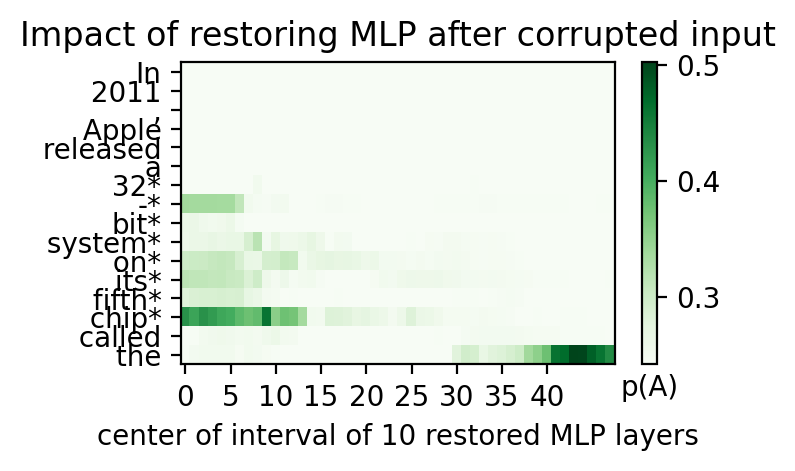

{0: {'mlp': {'scores': tensor([[0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418,
            0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418,
            0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418,
            0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418,
            0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418,
            0.2418, 0.2418, 0.2418],
           [0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418,
            0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418,
            0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418,
            0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418,
            0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418,
            0.2418, 0.2418, 0.2418],
           [0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418

In [ ]:
plot_flows(mt, "In 2011, Apple released a 32-bit system on its fifth chip called the", plots=['mlp'], subject="32-bit system on its fifth chip")

In [ ]:
from tqdm import tqdm

for i, cf in tqdm(enumerate(counterfact)):
    rew = cf['requested_rewrite']
    text = rew['prompt'].replace("{}", rew['subject'])

## Does more uncertainty mean more token effect spread?

In [100]:
import numpy as np
import pandas as pd

In [102]:
# results_dict[0]['mlp']['high_score']
highs = []
tops = []
i = 0
for i in results_dict:
    top_count = 0
    if list(results_dict[i].keys()) == ["mlp"]:
        high_score = round(float(results_dict[i]['mlp']['high_score']), 4)
        top = high_score * 0.6
        for token_probs in results_dict[i]['mlp']['scores']:
            for prob in token_probs:
                if prob >= top:
                    top_count += 1
    i += 1
    highs.append(high_score)
    tops.append(top_count)
    # print("High Score: ", high_score, "Top Count: ", top_count)
    # if i > 2:
    #     break

df = pd.DataFrame({"high_score": highs, "top_score_count": tops})
df.sort_values(by="high_score")

,high_score,top_score_count
35,0.0192,93
47,0.0198,432
40,0.0335,432
44,0.0341,239
49,0.0418,336
25,0.0430,336
50,0.0463,45
38,0.0482,83
48,0.0489,145
46,0.0522,80


## Load StrategyQA Dataset

In [10]:
from dsets.knowns import KnownsDataset

In [11]:
knowns = KnownsDataset(DATA_DIR)

Loaded dataset with 1209 elements


In [12]:
import os
os.getcwd()

'/content/drive/MyDrive/rome'

In [13]:
with open('/content/drive/MyDrive/rome/data/strategyqa_train.json') as f:
    sqa = json.load(f)

In [14]:
sqa[0]


{'qid': 'b8677742616fef051f00',
 'term': 'Genghis Khan',
 'description': 'founder and first Great Khan of the Mongol Empire',
 'question': 'Are more people today related to Genghis Khan than Julius Caesar?',
 'answer': True,
 'facts': ['Julius Caesar had three children.',
  'Genghis Khan had sixteen children.',
  'Modern geneticists have determined that  out of every 200 men today has DNA that can be traced to Genghis Khan.'],
 'decomposition': ['How many kids did Julius Caesar have?',
  'How many kids did Genghis Khan have?',
  'Is #2 greater than #1?'],
 'evidence': [[[['Caesarion-2', 'Julia (daughter of Caesar)-1']],
   [['Alakhai Bekhi-1', 'Tolui-1'], 'no_evidence'],
   ['operation']],
  [[['Julius Caesar-75']], [['Genghis Khan-17']], ['operation']],
  [[['Gaius Julius Caesar-7']],
   [['Genghis Khan-15'], 'no_evidence'],
   ['no_evidence', 'operation']]]}

In [15]:
fact_str = "Facts: "

for f in sqa[0]['facts']:
    fact_str += f.replace("  ", " ") + " "

print("Question:", sqa[0]['question'])
print(fact_str)
print("Answer:", sqa[0]['answer'])

Question: Are more people today related to Genghis Khan than Julius Caesar?
Facts: Julius Caesar had three children. Genghis Khan had sixteen children. Modern geneticists have determined that out of every 200 men today has DNA that can be traced to Genghis Khan. 
Answer: True


In [20]:
from tqdm import tqdm
import numpy as np
device = 'cuda'
count = 0
i = 1
for j, data in tqdm(enumerate(sqa)):
    example = """Question: Are more people today related to Genghis Khan than Julius Caesar?
    Facts: Julius Caesar had three children. Genghis Khan had sixteen children. Modern geneticists have determined that out of every 200 men today has DNA that can be traced to Genghis Khan. 
    Answer (True or False): True\n"""
    fact_str = "Facts: "
    for f in data['facts']:
        fact_str += f.replace("  ", " ") + " "
    question = "Question: " + data['question']
    answer = "Answer (True or False):"
    correct_answer = str(data['answer'])
    prompt = example + question + "\n" + fact_str + "\n" + answer
    input_ids = mt.tokenizer(
        prompt, add_special_tokens=False, return_tensors="pt"
    ).input_ids.to(device)
    generated_outputs = mt.model.generate(
        input_ids,
        do_sample=True,
        early_stopping=True,
        max_length=200,
        num_return_sequences=1,
        output_scores=True,
        return_dict_in_generate=True,
        device=device,
        # repetition_penalty=1.2,
        # length_penalty=0.8,
        pad_token_id=mt.tokenizer.eos_token_id,
        temperature=0.05,
    )
    generated_text = mt.tokenizer.decode(generated_outputs.sequences[0])

    # only use id's that were generated
    # gen_sequences has shape [3, 15]
    gen_sequences = generated_outputs.sequences[:, input_ids.shape[-1] :]
    probs = torch.stack(generated_outputs.scores, dim=1).softmax(-1)  # -> shape [3, 15, vocab_size]
    # now we need to collect the probability of the generated token
    # we need to add a dummy dim in the end to make gather work
    gen_probs = torch.gather(probs, 2, gen_sequences[:, :, None]).squeeze(-1)
    # print(gen_probs)
    for j, sequence in enumerate(generated_outputs.sequences):
        generated_seq = sequence[len(sequence) - len(gen_probs[j]):len(sequence)]
        token_list = []
        for token in generated_seq:
            token_list.append(mt.tokenizer.decode(token))
        generated_text = mt.tokenizer.decode(generated_seq)
        first_token = mt.tokenizer.decode(generated_seq[0]).replace(' ', '')
    
    token_probs = []
    for token, prob in zip(generated_seq, gen_probs[0]):
        text = mt.tokenizer.decode(token)
        prob = str(np.array(prob.cpu()))
        token_probs.append((text, prob))

    print(correct_answer)
    print(first_token)
    if correct_answer.lower() in first_token.lower():
        sqa[i]["first_generated_token"] = first_token
        sqa[i]["gpt2_main_completion"] = generated_text
        sqa[i]["good_gpt2_prompt"] = True
        sqa[i]["token_probs"] = token_probs
        count += 1
        i += 1
    else:
        sqa[i]["first_generated_token"] = first_token
        sqa[i]["gpt2_main_completion"] = generated_text
        sqa[i]["good_gpt2_prompt"] = False
        sqa[i]["token_probs"] = token_probs
        i += 1

print("\n\n Number of prompts that created good completions: " + str(count))

1it [00:02,  2.19s/it]

True
True


2it [00:05,  2.56s/it]

False
True


3it [00:07,  2.36s/it]

False
True


4it [00:09,  2.23s/it]

True
True


5it [00:11,  2.33s/it]

False
True


6it [00:14,  2.40s/it]

False
True


7it [00:17,  2.57s/it]

False
True


8it [00:19,  2.62s/it]

False
True


9it [00:22,  2.50s/it]

True
True


10it [00:23,  2.29s/it]

True
True


11it [00:26,  2.35s/it]

False
True


12it [00:28,  2.39s/it]

False
True


13it [00:31,  2.56s/it]

True
True


14it [00:32,  2.13s/it]

False
True


15it [00:35,  2.33s/it]

False
True


16it [00:38,  2.38s/it]

False
True


17it [00:40,  2.27s/it]

True
True


18it [00:42,  2.21s/it]

True
True


19it [00:43,  1.80s/it]

False
True


20it [00:45,  1.96s/it]

False
True


21it [00:48,  2.13s/it]

True
True


22it [00:49,  1.96s/it]

False
True


23it [00:51,  2.05s/it]

True
True


24it [00:54,  2.12s/it]

False
True


25it [00:56,  2.11s/it]

False
True


26it [00:57,  1.94s/it]

True
True


27it [01:00,  2.07s/it]

True
True


28it [01:01,  1.80s/it]

False
True


29it [01:03,  1.82s/it]

False
True


30it [01:05,  1.89s/it]

True
True


31it [01:07,  1.92s/it]

True
True


32it [01:09,  2.16s/it]

True
True


33it [01:12,  2.43s/it]

True
True


34it [01:15,  2.36s/it]

False
True


35it [01:18,  2.53s/it]

False
True


36it [01:19,  2.26s/it]

False
True


37it [01:22,  2.28s/it]

True
True


38it [01:24,  2.35s/it]

True
True


39it [01:27,  2.49s/it]

False
True


40it [01:29,  2.36s/it]

True
True


41it [01:31,  2.23s/it]

True
True


42it [01:34,  2.38s/it]

False
True


43it [01:35,  2.23s/it]

False
True


44it [01:38,  2.38s/it]

False
True


45it [01:41,  2.42s/it]

True
True


46it [01:42,  2.04s/it]

True
True


47it [01:44,  2.12s/it]

False
True


48it [01:46,  1.99s/it]

True
True


49it [01:48,  2.05s/it]

False
True


50it [01:50,  2.04s/it]

False
True


51it [01:53,  2.23s/it]

False
True


52it [01:55,  2.31s/it]

False
True


53it [01:58,  2.32s/it]

True
True


54it [02:00,  2.42s/it]

True
True


55it [02:02,  2.22s/it]

True
True


56it [02:04,  2.21s/it]

False
True


57it [02:06,  2.14s/it]

True
True


58it [02:09,  2.35s/it]

True
True


59it [02:10,  1.82s/it]

True
True


60it [02:13,  2.19s/it]

False
True


61it [02:14,  1.94s/it]

True
True


62it [02:17,  2.11s/it]

False
True


63it [02:19,  2.33s/it]

False
True


64it [02:21,  2.24s/it]

False
True


65it [02:22,  1.72s/it]

False
True


66it [02:24,  1.76s/it]

False
True


67it [02:24,  1.33s/it]

False
True


68it [02:26,  1.52s/it]

False
True


69it [02:29,  1.88s/it]

False
True


70it [02:31,  2.00s/it]

True
True


71it [02:34,  2.18s/it]

False
True


72it [02:36,  2.18s/it]

True
True


73it [02:38,  2.14s/it]

True
True


74it [02:41,  2.42s/it]

False
True


75it [02:44,  2.52s/it]

False
True


76it [02:45,  2.11s/it]

True
False


77it [02:48,  2.32s/it]

False
True


78it [02:50,  2.22s/it]

False
True


79it [02:52,  2.22s/it]

False
True


80it [02:55,  2.36s/it]

False
True


81it [02:57,  2.25s/it]

True
True


82it [02:58,  2.14s/it]

False
True


83it [03:00,  1.97s/it]

False
True


84it [03:02,  2.09s/it]

True
True


85it [03:04,  2.02s/it]

False
True


86it [03:07,  2.17s/it]

True
True


87it [03:09,  2.28s/it]

False
True


88it [03:12,  2.41s/it]

True
True


89it [03:14,  2.34s/it]

False
True


90it [03:17,  2.43s/it]

True
True


91it [03:19,  2.37s/it]

False
True


92it [03:21,  2.15s/it]

False
True


93it [03:23,  2.26s/it]

False
True


94it [03:26,  2.56s/it]

True
True


95it [03:27,  1.95s/it]

True
True


96it [03:27,  1.50s/it]

False
True


97it [03:30,  1.83s/it]

False
True


98it [03:32,  1.76s/it]

False
True


99it [03:34,  2.06s/it]

False
True


100it [03:37,  2.37s/it]

True
True


101it [03:40,  2.33s/it]

False
True


102it [03:42,  2.39s/it]

True
True


103it [03:45,  2.45s/it]

False
True


104it [03:47,  2.45s/it]

False
True


105it [03:50,  2.46s/it]

True
True


106it [03:52,  2.31s/it]

True
True


107it [03:55,  2.49s/it]

False
True


108it [03:56,  2.04s/it]

False
True


109it [03:58,  2.02s/it]

True
True


110it [04:00,  2.09s/it]

False
True


111it [04:02,  2.24s/it]

False
True


112it [04:05,  2.22s/it]

False
True


113it [04:07,  2.17s/it]

True
True


114it [04:10,  2.49s/it]

False
True


115it [04:12,  2.43s/it]

True
True


116it [04:14,  2.30s/it]

True
True


117it [04:17,  2.41s/it]

True
True


118it [04:19,  2.45s/it]

True
True


119it [04:22,  2.47s/it]

True
True


120it [04:22,  1.90s/it]

True
True


121it [04:26,  2.27s/it]

True
True


122it [04:27,  2.12s/it]

False
True


123it [04:29,  2.06s/it]

True
True


124it [04:32,  2.31s/it]

True
True


125it [04:34,  2.22s/it]

False
True


126it [04:35,  1.83s/it]

False
True


127it [04:37,  1.83s/it]

True
True


128it [04:39,  1.96s/it]

False
True


129it [04:42,  2.20s/it]

True
True


130it [04:44,  2.13s/it]

True
True


131it [04:46,  2.05s/it]

True
True


132it [04:48,  2.11s/it]

True
True


133it [04:50,  2.17s/it]

True
True


134it [04:52,  2.06s/it]

True
True


135it [04:55,  2.22s/it]

True
True


136it [04:56,  1.90s/it]

True
True


137it [04:59,  2.18s/it]

False
True


138it [05:01,  2.28s/it]

False
True


139it [05:04,  2.32s/it]

True
True


140it [05:06,  2.31s/it]

False
True


141it [05:08,  2.12s/it]

False
True


142it [05:10,  2.21s/it]

True
True


143it [05:12,  2.18s/it]

False
True


144it [05:14,  2.19s/it]

True
True


145it [05:17,  2.37s/it]

False
True


146it [05:20,  2.45s/it]

False
True


147it [05:23,  2.62s/it]

False
True


148it [05:25,  2.64s/it]

False
True


149it [05:27,  2.45s/it]

False
True


150it [05:29,  2.13s/it]

False
True


151it [05:30,  1.74s/it]

True
True


152it [05:31,  1.64s/it]

True
True


153it [05:33,  1.77s/it]

False
True


154it [05:36,  2.04s/it]

False
True


155it [05:39,  2.25s/it]

False
True


156it [05:41,  2.26s/it]

False
True


157it [05:44,  2.43s/it]

True
True


158it [05:46,  2.31s/it]

False
True


159it [05:47,  1.99s/it]

True
True


160it [05:49,  1.99s/it]

True
True


161it [05:50,  1.73s/it]

True
True


162it [05:53,  1.97s/it]

True
True


163it [05:55,  2.08s/it]

True
True


164it [05:56,  1.88s/it]

True
True


165it [05:58,  1.89s/it]

False
True


166it [06:01,  2.04s/it]

True
True


167it [06:03,  2.13s/it]

False
True


168it [06:04,  1.89s/it]

False
True


169it [06:06,  1.82s/it]

False
True


170it [06:09,  2.14s/it]

True
True


171it [06:11,  2.27s/it]

False
True


172it [06:13,  2.16s/it]

True
True


173it [06:16,  2.30s/it]

False
True


174it [06:17,  1.92s/it]

False
True


175it [06:20,  2.22s/it]

False
True


176it [06:23,  2.34s/it]

True
True


177it [06:25,  2.50s/it]

False
True


178it [06:29,  2.69s/it]

False
True


179it [06:31,  2.55s/it]

True
True


180it [06:33,  2.54s/it]

True
True


181it [06:35,  2.22s/it]

True
True


182it [06:37,  2.32s/it]

False
True


183it [06:40,  2.44s/it]

False
True


184it [06:43,  2.47s/it]

False
True


185it [06:45,  2.48s/it]

False
True


186it [06:48,  2.48s/it]

False
True


187it [06:50,  2.34s/it]

True
True


188it [06:52,  2.28s/it]

False
True


189it [06:55,  2.45s/it]

False
True


190it [06:57,  2.41s/it]

True
True


191it [06:59,  2.26s/it]

False
True


192it [07:01,  2.29s/it]

False
True


193it [07:03,  2.22s/it]

False
True


194it [07:04,  1.73s/it]

False
True


195it [07:06,  1.78s/it]

False
False


196it [07:09,  2.16s/it]

True
True


197it [07:10,  2.00s/it]

False
True


198it [07:12,  1.80s/it]

False
True


199it [07:14,  1.90s/it]

True
True


200it [07:16,  2.04s/it]

True
True


201it [07:17,  1.78s/it]

False
True


202it [07:20,  1.90s/it]

True
True


203it [07:22,  1.99s/it]

False
True


204it [07:24,  2.09s/it]

False
True


205it [07:27,  2.22s/it]

True
True


206it [07:29,  2.23s/it]

True
True


207it [07:31,  2.31s/it]

False
True


208it [07:34,  2.35s/it]

True
True


209it [07:36,  2.18s/it]

True
True


210it [07:38,  2.12s/it]

True
True


211it [07:40,  2.10s/it]

False
True


212it [07:42,  2.16s/it]

True
True


213it [07:45,  2.37s/it]

False
True


214it [07:47,  2.32s/it]

False
True


215it [07:50,  2.39s/it]

False
True


216it [07:53,  2.66s/it]

False
True


217it [07:55,  2.51s/it]

True
True


218it [07:57,  2.32s/it]

True
True


219it [07:59,  2.21s/it]

True
True


220it [08:01,  2.13s/it]

False
True


221it [08:02,  1.76s/it]

False
True


222it [08:04,  2.07s/it]

False
True


223it [08:06,  2.04s/it]

True
True


224it [08:09,  2.25s/it]

False
True


225it [08:11,  2.23s/it]

False
True


226it [08:14,  2.27s/it]

False
False


227it [08:16,  2.34s/it]

False
True


228it [08:18,  2.30s/it]

False
True


229it [08:21,  2.25s/it]

False
True


230it [08:23,  2.22s/it]

False
True


231it [08:25,  2.28s/it]

False
True


232it [08:27,  2.25s/it]

False
True


233it [08:30,  2.35s/it]

True
True


234it [08:32,  2.42s/it]

False
True


235it [08:35,  2.43s/it]

True
True


236it [08:38,  2.59s/it]

True
True


237it [08:40,  2.46s/it]

True
True


238it [08:42,  2.41s/it]

False
True


239it [08:45,  2.56s/it]

True
True


240it [08:47,  2.45s/it]

False
True


241it [08:50,  2.38s/it]

True
True


242it [08:50,  1.82s/it]

False
True


243it [08:52,  1.98s/it]

False
True


244it [08:55,  2.13s/it]

False
True


245it [08:57,  1.96s/it]

True
True


246it [08:58,  1.81s/it]

True
True


247it [08:59,  1.67s/it]

False
True


248it [09:02,  1.98s/it]

False
True


249it [09:05,  2.26s/it]

True
True


250it [09:08,  2.51s/it]

True
True


251it [09:10,  2.47s/it]

True
True


252it [09:13,  2.50s/it]

True
True


253it [09:16,  2.54s/it]

False
True


254it [09:18,  2.42s/it]

False
True


255it [09:20,  2.50s/it]

False
True


256it [09:22,  2.35s/it]

False
True


257it [09:25,  2.53s/it]

False
True


258it [09:26,  2.08s/it]

False
True


259it [09:28,  1.94s/it]

True
True


260it [09:30,  2.06s/it]

True
True


261it [09:33,  2.16s/it]

False
True


262it [09:35,  2.17s/it]

False
True


263it [09:38,  2.35s/it]

False
True


264it [09:40,  2.24s/it]

False
True


265it [09:42,  2.21s/it]

False
True


266it [09:44,  2.12s/it]

False
True


267it [09:46,  2.23s/it]

False
True


268it [09:49,  2.38s/it]

False
True


269it [09:52,  2.52s/it]

False
True


270it [09:54,  2.37s/it]

False
True


271it [09:56,  2.21s/it]

True
True


272it [09:58,  2.16s/it]

False
True


273it [10:00,  2.18s/it]

True
True


274it [10:02,  2.18s/it]

False
True


275it [10:05,  2.33s/it]

True
True


276it [10:07,  2.28s/it]

True
True


277it [10:09,  2.34s/it]

True
True


278it [10:12,  2.37s/it]

True
True


279it [10:14,  2.32s/it]

True
True


280it [10:17,  2.55s/it]

True
True


281it [10:18,  2.17s/it]

True
True


282it [10:20,  1.94s/it]

False
True


283it [10:23,  2.17s/it]

True
True


284it [10:24,  2.01s/it]

False
True


285it [10:27,  2.25s/it]

False
True


286it [10:30,  2.44s/it]

False
True


287it [10:32,  2.21s/it]

True
True


288it [10:34,  2.18s/it]

True
True


289it [10:36,  2.23s/it]

False
True


290it [10:37,  1.91s/it]

True
True


291it [10:40,  2.06s/it]

False
True


292it [10:41,  1.87s/it]

True
False


293it [10:43,  2.01s/it]

True
True


294it [10:46,  2.24s/it]

False
True


295it [10:49,  2.31s/it]

False
True


296it [10:51,  2.41s/it]

False
True


297it [10:52,  2.01s/it]

True
True


298it [10:54,  2.04s/it]

True
True


299it [10:57,  2.16s/it]

True
True


300it [10:59,  2.15s/it]

True
True


301it [11:02,  2.30s/it]

False
True


302it [11:04,  2.43s/it]

True
True


303it [11:06,  2.31s/it]

False
True


304it [11:09,  2.30s/it]

True
True


305it [11:12,  2.44s/it]

False
True


306it [11:13,  2.22s/it]

True
True


307it [11:15,  2.15s/it]

False
True


308it [11:18,  2.33s/it]

True
True


309it [11:20,  2.38s/it]

False
True


310it [11:23,  2.43s/it]

True
True


311it [11:26,  2.56s/it]

True
True


312it [11:29,  2.63s/it]

True
True


313it [11:31,  2.57s/it]

False
True


314it [11:33,  2.48s/it]

False
True


315it [11:35,  2.10s/it]

True
True


316it [11:37,  2.23s/it]

True
True


317it [11:40,  2.38s/it]

True
True


318it [11:42,  2.37s/it]

True
True


319it [11:44,  2.26s/it]

True
True


320it [11:47,  2.35s/it]

False
True


321it [11:50,  2.54s/it]

False
True


322it [11:52,  2.53s/it]

False
True


323it [11:55,  2.59s/it]

True
True


324it [11:58,  2.63s/it]

False
True


325it [12:00,  2.65s/it]

False
True


326it [12:03,  2.66s/it]

False
True


327it [12:06,  2.64s/it]

False
True


328it [12:08,  2.64s/it]

False
True


329it [12:09,  2.07s/it]

False
True


330it [12:11,  2.19s/it]

True
True


331it [12:14,  2.29s/it]

False
True


332it [12:17,  2.40s/it]

True
True


333it [12:19,  2.45s/it]

True
True


334it [12:21,  2.38s/it]

False
True


335it [12:23,  2.12s/it]

False
True


336it [12:25,  2.04s/it]

True
True


337it [12:27,  1.95s/it]

False
True


338it [12:28,  1.92s/it]

True
True


339it [12:31,  1.98s/it]

False
True


340it [12:33,  2.09s/it]

True
True


341it [12:35,  2.14s/it]

True
True


342it [12:37,  2.15s/it]

False
True


343it [12:39,  1.99s/it]

False
True


344it [12:42,  2.17s/it]

True
True


345it [12:43,  2.09s/it]

True
True


346it [12:45,  1.89s/it]

True
True


347it [12:47,  2.06s/it]

True
True


348it [12:49,  1.93s/it]

True
True


349it [12:51,  2.09s/it]

False
True


350it [12:53,  2.10s/it]

False
True


351it [12:56,  2.30s/it]

True
True


352it [12:58,  2.21s/it]

True
True


353it [13:01,  2.36s/it]

True
True


354it [13:03,  2.13s/it]

True
True


355it [13:05,  2.22s/it]

False
True


356it [13:06,  1.78s/it]

False
True


357it [13:07,  1.77s/it]

False
True


358it [13:09,  1.62s/it]

True
True


359it [13:12,  1.96s/it]

False
True


360it [13:13,  1.84s/it]

False
True


361it [13:16,  2.08s/it]

True
True


362it [13:19,  2.31s/it]

False
True


363it [13:20,  2.13s/it]

False
True


364it [13:23,  2.33s/it]

False
True


365it [13:25,  2.17s/it]

True
True


366it [13:26,  1.90s/it]

False
False


367it [13:29,  2.12s/it]

False
True


368it [13:31,  2.12s/it]

False
True


369it [13:34,  2.34s/it]

False
True


370it [13:37,  2.47s/it]

False
True


371it [13:39,  2.53s/it]

False
True


372it [13:41,  2.30s/it]

True
True


373it [13:44,  2.40s/it]

True
True


374it [13:46,  2.44s/it]

False
True


375it [13:49,  2.47s/it]

False
True


376it [13:51,  2.38s/it]

True
True


377it [13:53,  2.33s/it]

False
True


378it [13:56,  2.53s/it]

False
True


379it [13:59,  2.72s/it]

True
True


380it [14:01,  2.32s/it]

True
True


381it [14:03,  2.32s/it]

False
True


382it [14:05,  2.12s/it]

True
True


383it [14:07,  2.18s/it]

True
True


384it [14:09,  2.08s/it]

False
True


385it [14:11,  2.19s/it]

False
True


386it [14:14,  2.36s/it]

True
False


387it [14:15,  2.09s/it]

True
True


388it [14:18,  2.19s/it]

False
True


389it [14:20,  2.25s/it]

False
True


390it [14:22,  2.05s/it]

True
False


391it [14:24,  2.19s/it]

False
True


392it [14:26,  1.98s/it]Input length of input_ids is 218, but ``max_length`` is set to 200. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
393it [14:26,  1.43s/it]

False
True
True
True


394it [14:28,  1.58s/it]

True
True


395it [14:30,  1.76s/it]

True
True


396it [14:33,  1.97s/it]

False
True


397it [14:33,  1.45s/it]

True
False


398it [14:35,  1.62s/it]

False
True


399it [14:37,  1.85s/it]

True
True


400it [14:38,  1.68s/it]

True
True


401it [14:41,  1.84s/it]

False
True


402it [14:43,  1.85s/it]

True
True


403it [14:46,  2.25s/it]

False
True


404it [14:48,  2.27s/it]

False
True


405it [14:50,  2.28s/it]

True
True


406it [14:53,  2.39s/it]

False
True


407it [14:56,  2.55s/it]

False
True


408it [14:57,  2.10s/it]

True
True


409it [14:58,  1.82s/it]

True
True


410it [15:01,  2.13s/it]

False
True


411it [15:04,  2.29s/it]

False
True


412it [15:06,  2.29s/it]

False
True


413it [15:07,  2.02s/it]

True
True


414it [15:09,  2.01s/it]

False
True


415it [15:12,  2.12s/it]

False
True


416it [15:14,  2.33s/it]

False
True


417it [15:16,  2.18s/it]

False
True


418it [15:19,  2.21s/it]

False
True


419it [15:20,  2.07s/it]

False
True


420it [15:22,  1.97s/it]

True
True


421it [15:24,  1.85s/it]

True
True


422it [15:25,  1.67s/it]

False
True


423it [15:28,  1.96s/it]

False
True


424it [15:30,  2.20s/it]

False
True


425it [15:33,  2.25s/it]

False
True


426it [15:35,  2.39s/it]

False
True


427it [15:38,  2.52s/it]

True
True


428it [15:41,  2.52s/it]

False
True


429it [15:43,  2.38s/it]

False
True


430it [15:45,  2.43s/it]

True
True


431it [15:48,  2.55s/it]

True
True


432it [15:50,  2.46s/it]

False
True


433it [15:51,  1.90s/it]

True
True


434it [15:54,  2.13s/it]

False
True


435it [15:57,  2.34s/it]

False
True


436it [15:57,  1.74s/it]

False
True


437it [16:00,  2.07s/it]

True
True


438it [16:02,  2.15s/it]

True
True


439it [16:05,  2.26s/it]

True
True


440it [16:07,  2.30s/it]

False
True


441it [16:09,  2.36s/it]

False
True


442it [16:11,  2.25s/it]

False
True


443it [16:14,  2.41s/it]

True
True


444it [16:16,  2.24s/it]

True
True


445it [16:18,  2.07s/it]

False
True


446it [16:20,  2.23s/it]

False
True


447it [16:23,  2.24s/it]

True
True


448it [16:25,  2.34s/it]

False
True


449it [16:27,  2.25s/it]

False
True


450it [16:29,  2.25s/it]

False
True


451it [16:32,  2.22s/it]

True
True


452it [16:34,  2.30s/it]

True
True


453it [16:36,  2.14s/it]

True
True


454it [16:37,  1.70s/it]

True
False


455it [16:39,  1.98s/it]

False
True


456it [16:42,  2.15s/it]

False
True


457it [16:44,  2.15s/it]

False
True


458it [16:45,  1.98s/it]

True
True


459it [16:48,  2.13s/it]

True
True


460it [16:50,  2.24s/it]

True
True


461it [16:52,  2.04s/it]

False
True


462it [16:54,  2.11s/it]

False
True


463it [16:57,  2.25s/it]

False
True


464it [16:59,  2.07s/it]

True
True


465it [17:01,  2.16s/it]

False
True


466it [17:03,  2.28s/it]

False
True


467it [17:06,  2.51s/it]

False
True


468it [17:09,  2.43s/it]

False
True


469it [17:12,  2.62s/it]

True
True


470it [17:15,  2.66s/it]

True
True


471it [17:17,  2.60s/it]

False
True


472it [17:19,  2.36s/it]

True
True


473it [17:20,  1.93s/it]

True
True


474it [17:22,  2.10s/it]

True
True


475it [17:25,  2.32s/it]

False
True


476it [17:28,  2.46s/it]

False
True


477it [17:30,  2.31s/it]

False
True


478it [17:32,  2.26s/it]

False
True


479it [17:34,  2.29s/it]

False
True


480it [17:37,  2.30s/it]

False
True


481it [17:38,  2.17s/it]

True
True


482it [17:41,  2.23s/it]

True
True


483it [17:43,  2.25s/it]

False
True


484it [17:46,  2.32s/it]

False
True


485it [17:49,  2.55s/it]

True
True


486it [17:51,  2.39s/it]

False
True


487it [17:53,  2.37s/it]

False
True


488it [17:56,  2.43s/it]

False
True


489it [17:58,  2.33s/it]

False
True


490it [18:00,  2.27s/it]

False
True


491it [18:03,  2.52s/it]

True
True


492it [18:05,  2.46s/it]

False
True


493it [18:08,  2.59s/it]

True
True


494it [18:10,  2.49s/it]

True
True


495it [18:13,  2.39s/it]

True
True


496it [18:14,  2.16s/it]

False
True


497it [18:15,  1.88s/it]

True
True


498it [18:18,  2.13s/it]

False
True


499it [18:20,  2.11s/it]

False
True


500it [18:22,  2.14s/it]

True
True


501it [18:25,  2.34s/it]

False
True


502it [18:28,  2.40s/it]

True
True


503it [18:30,  2.41s/it]

True
True


504it [18:33,  2.48s/it]

False
True


505it [18:35,  2.37s/it]

True
True


506it [18:38,  2.49s/it]

False
True


507it [18:39,  2.08s/it]

False
True


508it [18:41,  2.03s/it]

True
True


509it [18:42,  1.77s/it]

True
True


510it [18:43,  1.53s/it]

True
True


511it [18:45,  1.82s/it]

False
True


512it [18:49,  2.21s/it]

True
True


513it [18:51,  2.32s/it]

True
True


514it [18:54,  2.45s/it]

False
True


515it [18:56,  2.47s/it]

False
True


516it [18:58,  2.17s/it]

True
True


517it [19:00,  2.31s/it]

False
True


518it [19:03,  2.48s/it]

True
True


519it [19:05,  2.28s/it]

True
True


520it [19:07,  2.04s/it]

False
True


521it [19:08,  1.95s/it]

True
True


522it [19:11,  2.03s/it]

False
True


523it [19:12,  1.78s/it]

True
True


524it [19:14,  2.00s/it]

True
True


525it [19:17,  2.18s/it]

False
True


526it [19:18,  1.98s/it]

True
True


527it [19:21,  2.17s/it]

True
True


528it [19:24,  2.36s/it]

True
True


529it [19:26,  2.42s/it]

True
True


530it [19:29,  2.55s/it]

False
True


531it [19:31,  2.25s/it]

False
True


532it [19:34,  2.44s/it]

True
True


533it [19:36,  2.48s/it]

False
False


534it [19:39,  2.61s/it]

True
True


535it [19:41,  2.44s/it]

True
True


536it [19:42,  2.07s/it]

False
True


537it [19:45,  2.20s/it]

False
True


538it [19:47,  2.30s/it]

False
True


539it [19:49,  2.08s/it]

True
True


540it [19:51,  2.10s/it]

False
True


541it [19:53,  1.92s/it]

True
True


542it [19:55,  2.18s/it]

False
True


543it [19:58,  2.25s/it]

False
True


544it [20:00,  2.30s/it]

True
True


545it [20:03,  2.37s/it]

False
True


546it [20:05,  2.34s/it]

False
True


547it [20:08,  2.39s/it]

True
True


548it [20:10,  2.46s/it]

True
True


549it [20:13,  2.64s/it]

True
True


550it [20:16,  2.64s/it]

True
True


551it [20:17,  2.25s/it]

True
True


552it [20:20,  2.33s/it]

True
True


553it [20:22,  2.22s/it]

False
True


554it [20:25,  2.43s/it]

False
True


555it [20:27,  2.45s/it]

True
True


556it [20:29,  2.26s/it]

True
True


557it [20:30,  2.01s/it]Input length of input_ids is 212, but ``max_length`` is set to 200. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
558it [20:31,  1.45s/it]

False
True
True
True


559it [20:32,  1.53s/it]

True
True


560it [20:34,  1.68s/it]

False
True


561it [20:37,  1.85s/it]

False
True


562it [20:39,  1.89s/it]

True
True


563it [20:41,  2.04s/it]

False
True


564it [20:43,  2.11s/it]

True
True


565it [20:45,  2.02s/it]

True
True


566it [20:47,  1.95s/it]

False
True


567it [20:50,  2.20s/it]

False
True


568it [20:52,  2.33s/it]

False
True


569it [20:55,  2.45s/it]

False
True


570it [20:57,  2.47s/it]

True
True


571it [21:00,  2.54s/it]

False
True


572it [21:01,  2.14s/it]

True
True


573it [21:03,  1.96s/it]

True
True


574it [21:06,  2.18s/it]

False
True


575it [21:08,  2.29s/it]

True
True


576it [21:11,  2.42s/it]

True
True


577it [21:13,  2.42s/it]

False
True


578it [21:16,  2.39s/it]

True
True


579it [21:18,  2.50s/it]

True
True


580it [21:21,  2.42s/it]

False
True


581it [21:23,  2.29s/it]

True
True


582it [21:25,  2.28s/it]

True
True


583it [21:26,  1.99s/it]

False
True


584it [21:29,  2.23s/it]

False
True


585it [21:32,  2.44s/it]

False
True


586it [21:35,  2.60s/it]

False
True


587it [21:37,  2.59s/it]

False
True


588it [21:39,  2.17s/it]

True
True


589it [21:40,  2.03s/it]

False
True


590it [21:42,  1.87s/it]

True
True


591it [21:45,  2.21s/it]

False
True


592it [21:48,  2.41s/it]

False
True


593it [21:50,  2.46s/it]

False
True


594it [21:52,  2.18s/it]

True
True


595it [21:55,  2.46s/it]

False
True


596it [21:57,  2.22s/it]

False
True


597it [21:59,  2.32s/it]

True
True


598it [22:02,  2.40s/it]

False
True


599it [22:05,  2.55s/it]

False
True


600it [22:07,  2.54s/it]

False
True


601it [22:10,  2.68s/it]

False
True


602it [22:12,  2.58s/it]

True
True


603it [22:15,  2.46s/it]

False
True


604it [22:17,  2.43s/it]

False
True


605it [22:19,  2.38s/it]

False
True


606it [22:21,  2.19s/it]

True
True


607it [22:24,  2.36s/it]

False
True


608it [22:26,  2.44s/it]

False
True


609it [22:29,  2.38s/it]

False
True


610it [22:31,  2.24s/it]

False
True


611it [22:33,  2.17s/it]

True
True


612it [22:35,  2.31s/it]

False
True


613it [22:37,  2.22s/it]

True
True


614it [22:39,  2.00s/it]

True
True


615it [22:40,  1.94s/it]

True
True


616it [22:42,  1.72s/it]

True
True


617it [22:44,  1.88s/it]

True
True


618it [22:46,  2.06s/it]

True
True


619it [22:49,  2.22s/it]

False
True


620it [22:51,  2.15s/it]

True
True


621it [22:54,  2.41s/it]

False
True


622it [22:56,  2.42s/it]

False
True


623it [22:59,  2.58s/it]

False
True


624it [23:02,  2.55s/it]

False
True


625it [23:04,  2.49s/it]

False
True


626it [23:07,  2.48s/it]

True
True


627it [23:09,  2.39s/it]

False
True


628it [23:11,  2.24s/it]

False
True


629it [23:12,  1.79s/it]

False
True


630it [23:15,  2.16s/it]

False
True


631it [23:17,  2.12s/it]

True
True


632it [23:18,  1.88s/it]

False
True


633it [23:20,  1.89s/it]

False
True


634it [23:21,  1.81s/it]

False
True


635it [23:23,  1.66s/it]

True
True


636it [23:25,  1.79s/it]

False
False


637it [23:27,  1.88s/it]

False
True


638it [23:29,  1.85s/it]

True
True


639it [23:31,  1.96s/it]

False
True


640it [23:33,  1.89s/it]

True
True


641it [23:35,  1.97s/it]

False
True


642it [23:37,  2.06s/it]

False
True


643it [23:40,  2.30s/it]

True
True


644it [23:43,  2.38s/it]

False
True


645it [23:45,  2.48s/it]

False
True


646it [23:48,  2.47s/it]

False
True


647it [23:51,  2.63s/it]

True
True


648it [23:53,  2.59s/it]

False
True


649it [23:56,  2.65s/it]

False
True


650it [23:57,  2.25s/it]

False
True


651it [23:59,  2.12s/it]

False
True


652it [24:02,  2.36s/it]

False
True


653it [24:05,  2.46s/it]

False
True


654it [24:07,  2.45s/it]

False
True


655it [24:10,  2.47s/it]

False
True


656it [24:12,  2.37s/it]

True
True


657it [24:13,  2.11s/it]

False
True


658it [24:15,  1.95s/it]

True
True


659it [24:17,  1.92s/it]

False
True


660it [24:19,  1.99s/it]

False
True


661it [24:21,  1.96s/it]

True
True


662it [24:23,  2.14s/it]

True
True


663it [24:25,  1.90s/it]

True
True


664it [24:26,  1.74s/it]

False
True


665it [24:28,  1.72s/it]

False
True


666it [24:30,  1.97s/it]

False
True


667it [24:33,  2.29s/it]

True
True


668it [24:36,  2.37s/it]

False
True


669it [24:38,  2.31s/it]

False
True


670it [24:40,  2.24s/it]

False
True


671it [24:42,  2.27s/it]

True
True


672it [24:45,  2.31s/it]

False
True


673it [24:47,  2.20s/it]

True
True


674it [24:49,  2.27s/it]

False
True


675it [24:52,  2.33s/it]

True
True


676it [24:54,  2.45s/it]

True
True


677it [24:57,  2.54s/it]

False
True


678it [24:58,  2.14s/it]

True
True


679it [25:01,  2.17s/it]

True
True


680it [25:02,  1.79s/it]

False
True


681it [25:03,  1.61s/it]

False
True


682it [25:04,  1.63s/it]

False
True


683it [25:06,  1.75s/it]

False
True


684it [25:08,  1.82s/it]

True
True


685it [25:10,  1.77s/it]

False
True


686it [25:12,  1.69s/it]

False
True


687it [25:14,  1.92s/it]

False
True


688it [25:17,  2.18s/it]

False
True


689it [25:19,  2.16s/it]

True
True


690it [25:21,  2.05s/it]

True
True


691it [25:24,  2.29s/it]

True
True


692it [25:25,  2.07s/it]

True
True


693it [25:28,  2.17s/it]

False
True


694it [25:28,  1.70s/it]

True
True


695it [25:29,  1.55s/it]

True
True


696it [25:30,  1.15s/it]

True
True


697it [25:31,  1.32s/it]

True
True


698it [25:34,  1.80s/it]

False
True


699it [25:37,  2.07s/it]

True
True


700it [25:39,  2.00s/it]

False
True


701it [25:41,  2.03s/it]

False
True


702it [25:44,  2.26s/it]

False
True


703it [25:46,  2.30s/it]

True
True


704it [25:49,  2.37s/it]

True
True


705it [25:51,  2.27s/it]

False
True


706it [25:53,  2.32s/it]

True
True


707it [25:55,  2.26s/it]

True
True


708it [25:57,  2.22s/it]

False
True


709it [26:00,  2.30s/it]

False
True


710it [26:02,  2.43s/it]

True
True


711it [26:05,  2.55s/it]

True
True


712it [26:07,  2.38s/it]

False
True


713it [26:09,  2.24s/it]

True
True


714it [26:11,  2.20s/it]

True
True


715it [26:14,  2.45s/it]

False
True


716it [26:17,  2.58s/it]

False
True


717it [26:19,  2.44s/it]

True
True


718it [26:22,  2.50s/it]

False
True


719it [26:25,  2.51s/it]

False
True


720it [26:28,  2.70s/it]

False
True


721it [26:30,  2.69s/it]

False
True


722it [26:33,  2.64s/it]

False
True


723it [26:35,  2.42s/it]

False
True


724it [26:36,  2.02s/it]

True
True


725it [26:38,  1.92s/it]

False
True


726it [26:40,  1.95s/it]

True
True


727it [26:42,  1.98s/it]

True
True


728it [26:43,  1.92s/it]

True
True


729it [26:46,  2.04s/it]

True
True


730it [26:48,  2.23s/it]

False
True


731it [26:51,  2.33s/it]

False
True


732it [26:53,  2.33s/it]

True
True


733it [26:54,  1.95s/it]

False
True


734it [26:57,  2.11s/it]

True
True


735it [27:00,  2.40s/it]

True
True


736it [27:02,  2.44s/it]

False
True


737it [27:03,  1.99s/it]

True
True


738it [27:06,  2.23s/it]

False
True


739it [27:09,  2.33s/it]

True
True


740it [27:11,  2.38s/it]

True
True


741it [27:13,  2.30s/it]

True
True


742it [27:16,  2.40s/it]

False
True


743it [27:18,  2.25s/it]

True
True


744it [27:20,  2.23s/it]

True
True


745it [27:21,  1.96s/it]

True
True


746it [27:23,  1.83s/it]

True
True


747it [27:26,  2.08s/it]

False
True


748it [27:28,  2.14s/it]

True
True


749it [27:30,  2.23s/it]

True
True


750it [27:33,  2.23s/it]

True
True


751it [27:35,  2.30s/it]

True
True


752it [27:37,  2.33s/it]

False
True


753it [27:38,  1.92s/it]

False
True


754it [27:41,  2.04s/it]

True
True


755it [27:43,  2.13s/it]

True
True


756it [27:45,  2.13s/it]

True
True


757it [27:47,  2.16s/it]

False
True


758it [27:50,  2.27s/it]

True
True


759it [27:52,  2.32s/it]

True
True


760it [27:53,  1.94s/it]

False
True


761it [27:54,  1.68s/it]

False
True


762it [27:56,  1.71s/it]

False
True


763it [27:59,  1.94s/it]

False
True


764it [28:00,  1.85s/it]

False
True


765it [28:02,  1.84s/it]

True
True


766it [28:05,  2.14s/it]

False
True


767it [28:08,  2.29s/it]

False
True


768it [28:09,  2.07s/it]

False
True


769it [28:12,  2.18s/it]

True
True


770it [28:15,  2.38s/it]

True
True


771it [28:17,  2.41s/it]

False
True


772it [28:19,  2.43s/it]

True
True


773it [28:22,  2.36s/it]

True
True


774it [28:24,  2.37s/it]

True
True


775it [28:25,  2.09s/it]

True
True


776it [28:28,  2.25s/it]

False
True


777it [28:31,  2.50s/it]

False
True


778it [28:33,  2.15s/it]

True
True


779it [28:35,  2.36s/it]

False
True


780it [28:37,  2.17s/it]

False
True


781it [28:40,  2.25s/it]

False
True


782it [28:42,  2.42s/it]

False
True


783it [28:43,  1.82s/it]

True
True


784it [28:45,  1.98s/it]

True
True


785it [28:47,  1.89s/it]

True
True


786it [28:47,  1.50s/it]

True
True


787it [28:50,  1.74s/it]

True
True


788it [28:52,  2.05s/it]

True
True


789it [28:54,  1.82s/it]

False
True


790it [28:56,  2.03s/it]

True
True


791it [28:59,  2.29s/it]

False
True


792it [29:01,  2.03s/it]

False
True


793it [29:03,  2.26s/it]

True
True


794it [29:07,  2.52s/it]

False
True


795it [29:08,  2.17s/it]

True
True


796it [29:10,  2.23s/it]

True
True


797it [29:11,  1.92s/it]

True
True


798it [29:14,  2.05s/it]

False
True


799it [29:15,  1.73s/it]

True
True


800it [29:18,  2.06s/it]

True
True


801it [29:20,  2.16s/it]

True
True


802it [29:23,  2.35s/it]

False
True


803it [29:25,  2.27s/it]

False
True


804it [29:27,  2.12s/it]

True
True


805it [29:29,  2.03s/it]

True
True


806it [29:31,  2.14s/it]

False
True


807it [29:33,  2.02s/it]

False
True


808it [29:35,  2.11s/it]

True
True


809it [29:38,  2.27s/it]

False
True


810it [29:40,  2.16s/it]

False
True


811it [29:41,  1.86s/it]

False
True


812it [29:44,  2.18s/it]

False
True


813it [29:46,  2.21s/it]

True
True


814it [29:49,  2.42s/it]

True
True


815it [29:51,  2.37s/it]

True
True


816it [29:52,  2.09s/it]

True
True


817it [29:55,  2.17s/it]

False
True


818it [29:57,  2.15s/it]

True
True


819it [29:59,  2.14s/it]

True
True


820it [30:01,  2.18s/it]

False
True


821it [30:04,  2.26s/it]

False
True


822it [30:05,  2.05s/it]

True
True


823it [30:07,  1.84s/it]

False
True


824it [30:09,  1.93s/it]

True
True


825it [30:12,  2.26s/it]

False
True


826it [30:14,  2.20s/it]

False
True


827it [30:17,  2.43s/it]

False
True


828it [30:19,  2.38s/it]

True
True


829it [30:21,  2.30s/it]

False
True


830it [30:24,  2.45s/it]

False
True


831it [30:26,  2.29s/it]

True
True


832it [30:29,  2.37s/it]

True
True


833it [30:31,  2.50s/it]

False
True


834it [30:34,  2.45s/it]

False
True


835it [30:36,  2.39s/it]

True
True


836it [30:38,  2.37s/it]

False
True


837it [30:40,  2.28s/it]

False
True


838it [30:42,  2.08s/it]

False
True


839it [30:45,  2.42s/it]

False
True


840it [30:47,  2.17s/it]

True
True


841it [30:50,  2.36s/it]

False
True


842it [30:52,  2.36s/it]

True
True


843it [30:54,  2.18s/it]

True
True


844it [30:56,  2.28s/it]

False
True


845it [30:58,  2.03s/it]

True
True


846it [30:59,  1.71s/it]

True
True


847it [31:00,  1.74s/it]

False
True


848it [31:03,  2.13s/it]

True
True


849it [31:06,  2.41s/it]

False
True


850it [31:08,  2.11s/it]

False
True


851it [31:09,  1.92s/it]

True
True


852it [31:12,  2.04s/it]

False
False


853it [31:15,  2.39s/it]

False
True


854it [31:17,  2.37s/it]

True
True


855it [31:19,  2.22s/it]

False
True


856it [31:22,  2.32s/it]

True
True


857it [31:24,  2.43s/it]

False
True


858it [31:27,  2.44s/it]

False
True


859it [31:28,  2.21s/it]

False
True


860it [31:31,  2.43s/it]

True
True


861it [31:34,  2.39s/it]

True
True


862it [31:36,  2.48s/it]

False
True


863it [31:39,  2.53s/it]

False
True


864it [31:41,  2.49s/it]

True
True


865it [31:44,  2.53s/it]Input length of input_ids is 223, but ``max_length`` is set to 200. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
866it [31:44,  1.81s/it]

False
True
True
True


867it [31:46,  1.92s/it]

True
True


868it [31:49,  2.20s/it]

False
True


869it [31:52,  2.37s/it]

True
True


870it [31:55,  2.52s/it]

True
True


871it [31:57,  2.54s/it]

False
True


872it [31:59,  2.25s/it]

False
True


873it [32:01,  2.04s/it]

True
True


874it [32:03,  2.20s/it]

True
True


875it [32:06,  2.35s/it]

True
True


876it [32:08,  2.34s/it]

False
True


877it [32:11,  2.46s/it]

True
True


878it [32:13,  2.46s/it]

False
True


879it [32:16,  2.45s/it]

False
True


880it [32:18,  2.32s/it]

False
True


881it [32:20,  2.35s/it]

False
True


882it [32:22,  2.05s/it]

False
True


883it [32:24,  2.02s/it]

False
True


884it [32:26,  2.22s/it]

False
True


885it [32:29,  2.44s/it]

False
True


886it [32:31,  2.41s/it]

False
True


887it [32:34,  2.50s/it]

False
True


888it [32:37,  2.58s/it]

False
True


889it [32:40,  2.66s/it]

True
True


890it [32:43,  2.75s/it]

True
True


891it [32:45,  2.64s/it]

True
True


892it [32:48,  2.68s/it]

False
True


893it [32:50,  2.59s/it]

False
True


894it [32:53,  2.62s/it]

True
True


895it [32:55,  2.36s/it]

True
True


896it [32:57,  2.32s/it]

False
True


897it [33:00,  2.44s/it]

False
True


898it [33:01,  2.24s/it]

False
True


899it [33:03,  1.97s/it]

True
True


900it [33:05,  2.19s/it]

False
True


901it [33:07,  1.93s/it]

False
True


902it [33:09,  1.87s/it]

False
True


903it [33:11,  2.09s/it]

True
True


904it [33:14,  2.18s/it]

True
True


905it [33:16,  2.30s/it]

True
True


906it [33:18,  2.06s/it]

True
True


907it [33:19,  1.98s/it]

False
True


908it [33:22,  2.24s/it]

True
True


909it [33:25,  2.30s/it]

False
True


910it [33:27,  2.35s/it]

False
True


911it [33:30,  2.44s/it]

False
True


912it [33:32,  2.45s/it]

False
True


913it [33:34,  2.24s/it]

True
True


914it [33:34,  1.69s/it]

False
True


915it [33:36,  1.65s/it]

False
True


916it [33:39,  2.02s/it]

True
True


917it [33:42,  2.21s/it]

False
True


918it [33:42,  1.81s/it]

False
True


919it [33:45,  1.89s/it]

False
True


920it [33:47,  2.03s/it]

False
True


921it [33:49,  1.94s/it]

False
True


922it [33:51,  2.09s/it]

False
True


923it [33:53,  2.04s/it]

False
True


924it [33:56,  2.34s/it]

False
True


925it [33:59,  2.40s/it]

False
True


926it [34:01,  2.46s/it]

False
True


927it [34:02,  2.11s/it]Input length of input_ids is 202, but ``max_length`` is set to 200. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
928it [34:03,  1.52s/it]

True
True
True
True


929it [34:04,  1.54s/it]

False
True


930it [34:06,  1.63s/it]

True
True


931it [34:09,  2.02s/it]

False
True


932it [34:12,  2.21s/it]

False
True


933it [34:14,  2.20s/it]

False
True


934it [34:16,  2.19s/it]

False
True


935it [34:18,  2.08s/it]

True
True


936it [34:20,  2.20s/it]

True
True


937it [34:23,  2.25s/it]

False
True


938it [34:25,  2.18s/it]

True
True


939it [34:27,  2.25s/it]

False
True


940it [34:30,  2.47s/it]

True
True


941it [34:33,  2.49s/it]

False
True


942it [34:35,  2.45s/it]

False
True


943it [34:37,  2.45s/it]

False
True


944it [34:40,  2.43s/it]

True
True


945it [34:41,  2.18s/it]

False
True


946it [34:43,  1.89s/it]

True
True


947it [34:45,  2.17s/it]

False
True


948it [34:48,  2.26s/it]

False
True


949it [34:49,  1.99s/it]

True
True


950it [34:51,  1.81s/it]

False
True


951it [34:53,  1.91s/it]

True
True


952it [34:55,  1.96s/it]

True
True


953it [34:58,  2.25s/it]

False
True


954it [34:59,  1.83s/it]

True
True


955it [35:01,  1.90s/it]

True
True


956it [35:03,  2.14s/it]

False
True


957it [35:06,  2.23s/it]

True
True


958it [35:08,  2.20s/it]

False
True


959it [35:09,  1.85s/it]

True
True


960it [35:10,  1.50s/it]

True
True


961it [35:12,  1.83s/it]

False
True


962it [35:15,  2.16s/it]

False
True


963it [35:17,  2.18s/it]

False
True


964it [35:20,  2.33s/it]

False
True


965it [35:22,  2.28s/it]

False
True


966it [35:25,  2.29s/it]

True
True


967it [35:27,  2.45s/it]

True
True


968it [35:30,  2.47s/it]

False
True


969it [35:32,  2.33s/it]

False
True


970it [35:34,  2.35s/it]

False
True


971it [35:36,  2.14s/it]

False
True


972it [35:39,  2.27s/it]

False
False


973it [35:41,  2.42s/it]

False
True


974it [35:43,  2.33s/it]

True
False


975it [35:46,  2.44s/it]

True
True


976it [35:49,  2.45s/it]

True
True


977it [35:49,  1.83s/it]

True
True


978it [35:52,  2.16s/it]

False
True


979it [35:54,  2.27s/it]

False
True


980it [35:56,  1.93s/it]

False
True


981it [35:57,  1.78s/it]

False
True


982it [36:00,  2.01s/it]

True
False


983it [36:01,  1.88s/it]

True
True


984it [36:04,  2.10s/it]

True
True


985it [36:06,  2.16s/it]

False
True


986it [36:08,  2.25s/it]

False
True


987it [36:11,  2.23s/it]

True
True


988it [36:13,  2.19s/it]

False
True


989it [36:16,  2.36s/it]

False
True


990it [36:17,  2.03s/it]

True
True


991it [36:19,  2.23s/it]

False
True


992it [36:22,  2.30s/it]

False
True


993it [36:24,  2.15s/it]

True
True


994it [36:27,  2.35s/it]

True
True


995it [36:28,  2.16s/it]

False
True


996it [36:31,  2.30s/it]

False
True


997it [36:33,  2.32s/it]

False
True


998it [36:35,  2.28s/it]

True
True


999it [36:38,  2.45s/it]

False
True


1000it [36:40,  2.30s/it]

True
True


1001it [36:43,  2.36s/it]

True
True


1002it [36:45,  2.42s/it]

False
True


1003it [36:48,  2.44s/it]

True
True


1004it [36:51,  2.57s/it]

False
True


1005it [36:52,  2.26s/it]

True
True


1006it [36:55,  2.45s/it]

False
True


1007it [36:58,  2.60s/it]

False
True


1008it [37:01,  2.67s/it]

False
True


1009it [37:03,  2.62s/it]

False
True


1010it [37:06,  2.52s/it]

False
True


1011it [37:08,  2.50s/it]

True
True


1012it [37:10,  2.44s/it]

True
True


1013it [37:13,  2.48s/it]

True
True


1014it [37:16,  2.61s/it]

False
True


1015it [37:19,  2.70s/it]

True
True


1016it [37:22,  2.75s/it]

False
True


1017it [37:24,  2.54s/it]

True
True


1018it [37:26,  2.50s/it]

True
True


1019it [37:29,  2.53s/it]

False
True


1020it [37:30,  2.10s/it]

False
True


1021it [37:32,  2.18s/it]

True
True


1022it [37:33,  1.87s/it]

False
True


1023it [37:36,  1.98s/it]

True
True


1024it [37:38,  2.25s/it]

False
True


1025it [37:41,  2.32s/it]

False
True


1026it [37:43,  2.39s/it]

True
True


1027it [37:46,  2.32s/it]

False
True


1028it [37:48,  2.23s/it]

True
True


1029it [37:49,  2.07s/it]

False
True


1030it [37:52,  2.32s/it]

False
True


1031it [37:55,  2.39s/it]

True
True


1032it [37:57,  2.37s/it]

False
True


1033it [38:00,  2.46s/it]

False
True


1034it [38:02,  2.48s/it]

True
True


1035it [38:05,  2.46s/it]

False
True


1036it [38:08,  2.68s/it]

False
True


1037it [38:11,  2.66s/it]

False
True


1038it [38:13,  2.67s/it]

True
True


1039it [38:16,  2.68s/it]

True
False


1040it [38:18,  2.59s/it]

True
True


1041it [38:20,  2.41s/it]

True
True


1042it [38:22,  2.32s/it]

True
True


1043it [38:25,  2.38s/it]

False
True


1044it [38:27,  2.21s/it]

True
True


1045it [38:29,  2.30s/it]

False
True


1046it [38:32,  2.29s/it]

True
True


1047it [38:33,  2.16s/it]

True
True


1048it [38:36,  2.21s/it]

False
True


1049it [38:39,  2.52s/it]

False
True


1050it [38:41,  2.47s/it]

True
True


1051it [38:44,  2.53s/it]

False
True


1052it [38:47,  2.62s/it]

False
True


1053it [38:49,  2.49s/it]

False
True


1054it [38:52,  2.57s/it]

False
True


1055it [38:52,  1.93s/it]

True
True


1056it [38:53,  1.67s/it]

True
True


1057it [38:56,  1.88s/it]

True
True


1058it [38:59,  2.25s/it]

True
True


1059it [39:00,  1.99s/it]

False
True


1060it [39:03,  2.35s/it]

False
True


1061it [39:06,  2.47s/it]

True
True


1062it [39:08,  2.35s/it]

True
True


1063it [39:10,  2.26s/it]

False
True


1064it [39:12,  2.20s/it]

False
True


1065it [39:14,  2.20s/it]

False
True


1066it [39:15,  1.84s/it]

False
True


1067it [39:19,  2.28s/it]

False
True


1068it [39:21,  2.35s/it]

False
True


1069it [39:24,  2.48s/it]

False
True


1070it [39:27,  2.54s/it]

True
False


1071it [39:30,  2.67s/it]

True
True


1072it [39:32,  2.49s/it]

True
True


1073it [39:34,  2.25s/it]

True
True


1074it [39:36,  2.28s/it]

False
True


1075it [39:38,  2.31s/it]

True
True


1076it [39:39,  1.75s/it]

False
True


1077it [39:41,  1.83s/it]

False
True


1078it [39:43,  1.82s/it]

True
True


1079it [39:45,  2.00s/it]

True
True


1080it [39:47,  2.08s/it]

True
True


1081it [39:50,  2.17s/it]

True
True


1082it [39:51,  2.05s/it]

False
True


1083it [39:54,  2.24s/it]

False
True


1084it [39:56,  2.31s/it]

False
True


1085it [39:59,  2.39s/it]

False
True


1086it [40:02,  2.55s/it]

False
True


1087it [40:05,  2.55s/it]

True
False


1088it [40:07,  2.64s/it]

True
True


1089it [40:10,  2.59s/it]

True
True


1090it [40:12,  2.45s/it]

False
True


1091it [40:13,  2.15s/it]

True
True


1092it [40:16,  2.39s/it]

False
True


1093it [40:19,  2.36s/it]

False
True


1094it [40:21,  2.32s/it]

True
True


1095it [40:23,  2.12s/it]

True
True


1096it [40:25,  2.10s/it]

True
True


1097it [40:28,  2.34s/it]

False
True


1098it [40:30,  2.47s/it]

False
True


1099it [40:33,  2.51s/it]

False
True


1100it [40:36,  2.61s/it]

True
True


1101it [40:38,  2.47s/it]

False
True


1102it [40:40,  2.38s/it]

True
True


1103it [40:42,  2.17s/it]

False
True


1104it [40:43,  1.93s/it]

True
True


1105it [40:46,  2.14s/it]

False
True


1106it [40:48,  2.30s/it]

False
True


1107it [40:50,  1.98s/it]

True
True


1108it [40:51,  1.91s/it]

False
True


1109it [40:54,  2.21s/it]

False
True


1110it [40:57,  2.31s/it]

True
True


1111it [40:59,  2.41s/it]

False
True


1112it [41:02,  2.48s/it]

True
True


1113it [41:05,  2.52s/it]

True
True


1114it [41:07,  2.52s/it]

False
True


1115it [41:10,  2.44s/it]

True
True


1116it [41:12,  2.37s/it]

False
True


1117it [41:14,  2.39s/it]

False
True


1118it [41:16,  2.23s/it]

False
True


1119it [41:18,  2.08s/it]

True
True


1120it [41:20,  2.15s/it]

True
True


1121it [41:23,  2.27s/it]

False
True


1122it [41:25,  2.38s/it]

False
True


1123it [41:28,  2.38s/it]

True
True


1124it [41:30,  2.31s/it]

True
True


1125it [41:32,  2.16s/it]

True
True


1126it [41:35,  2.42s/it]

False
True


1128it [41:36,  1.40s/it]

True
True
False
True


1129it [41:39,  1.91s/it]

True
True


1130it [41:40,  1.82s/it]

True
True


1131it [41:42,  1.80s/it]

True
True


1132it [41:43,  1.45s/it]

True
True


1133it [41:44,  1.51s/it]

False
True


1134it [41:47,  1.79s/it]

False
True


1135it [41:48,  1.63s/it]

True
True


1136it [41:50,  1.85s/it]

True
True


1137it [41:53,  2.08s/it]

True
True


1138it [41:56,  2.26s/it]

False
True


1139it [41:57,  2.11s/it]

True
True


1140it [42:00,  2.27s/it]

False
True


1141it [42:01,  1.72s/it]

False
True


1142it [42:03,  1.82s/it]

True
True


1143it [42:05,  1.97s/it]

True
True


1144it [42:08,  2.24s/it]

False
True


1145it [42:10,  2.29s/it]

False
True


1146it [42:12,  2.29s/it]

False
True


1147it [42:14,  2.10s/it]

False
True


1148it [42:16,  2.08s/it]

True
True


1149it [42:19,  2.22s/it]

False
True


1150it [42:20,  1.92s/it]

True
True


1151it [42:22,  1.93s/it]

True
True


1152it [42:24,  2.07s/it]

False
True


1153it [42:27,  2.21s/it]

False
True


1154it [42:29,  2.27s/it]

True
True


1155it [42:32,  2.44s/it]

True
True


1156it [42:33,  2.10s/it]

True
True


1157it [42:34,  1.56s/it]

False
True


1158it [42:36,  1.85s/it]

True
True


1159it [42:37,  1.64s/it]

False
True


1160it [42:41,  2.11s/it]

False
True


1161it [42:42,  2.05s/it]

False
True


1162it [42:43,  1.52s/it]

True
True


1163it [42:45,  1.60s/it]

True
True


1164it [42:47,  1.83s/it]

True
True


1165it [42:50,  2.08s/it]

False
True


1166it [42:52,  2.21s/it]

False
True


1167it [42:55,  2.32s/it]

True
True


1168it [42:57,  2.44s/it]

True
True


1169it [42:59,  2.34s/it]

True
True


1170it [43:01,  2.25s/it]

True
True


1171it [43:04,  2.24s/it]

False
True


1172it [43:06,  2.39s/it]

False
True


1173it [43:09,  2.40s/it]

True
True


1174it [43:12,  2.58s/it]

False
True


1175it [43:15,  2.61s/it]

True
True


1176it [43:18,  2.74s/it]

True
True


1177it [43:19,  2.44s/it]

True
True


1178it [43:22,  2.41s/it]

True
True


1179it [43:24,  2.34s/it]

False
True


1180it [43:26,  2.23s/it]

False
True


1181it [43:27,  2.02s/it]

True
True


1182it [43:30,  2.18s/it]

True
True


1183it [43:33,  2.42s/it]

True
True


1184it [43:35,  2.40s/it]

False
True


1185it [43:38,  2.54s/it]

False
True


1186it [43:41,  2.66s/it]

False
True


1187it [43:44,  2.69s/it]

False
True


1188it [43:46,  2.64s/it]

True
True


1189it [43:48,  2.24s/it]

False
True


1190it [43:50,  2.20s/it]

True
True


1191it [43:52,  2.24s/it]

True
True


1192it [43:55,  2.45s/it]

False
True


1193it [43:56,  2.01s/it]

True
True


1194it [43:59,  2.17s/it]

False
True


1195it [44:01,  2.27s/it]

False
True


1196it [44:03,  2.15s/it]

True
True


1197it [44:05,  2.24s/it]

True
True


1198it [44:07,  2.16s/it]

False
True


1199it [44:10,  2.25s/it]

True
False


1200it [44:12,  2.18s/it]

False
False


1201it [44:14,  2.11s/it]

True
True


1202it [44:16,  2.09s/it]

False
True


1203it [44:18,  2.18s/it]

False
True


1204it [44:21,  2.32s/it]

True
True


1205it [44:23,  2.37s/it]

True
True


1206it [44:26,  2.50s/it]

False
True


1207it [44:28,  2.37s/it]

True
True


1208it [44:31,  2.49s/it]

True
True


1209it [44:32,  2.11s/it]

False
True


1210it [44:35,  2.21s/it]

True
True


1211it [44:36,  2.09s/it]

True
True


1212it [44:39,  2.23s/it]

True
True


1213it [44:40,  1.93s/it]

False
True


1214it [44:42,  1.91s/it]

True
True


1215it [44:45,  2.25s/it]

True
True


1216it [44:47,  2.16s/it]

True
True


1217it [44:49,  2.18s/it]

True
True


1218it [44:51,  2.10s/it]

False
True


1219it [44:54,  2.39s/it]

False
True


1220it [44:56,  2.18s/it]

False
True


1221it [44:57,  1.91s/it]

True
True


1222it [44:59,  1.94s/it]

False
True


1223it [45:02,  2.04s/it]

True
True


1224it [45:04,  2.18s/it]

True
True


1225it [45:07,  2.33s/it]

False
True


1226it [45:09,  2.30s/it]

False
True


1227it [45:12,  2.46s/it]

True
True


1228it [45:14,  2.23s/it]

True
True


1229it [45:15,  1.97s/it]

True
True


1230it [45:17,  2.11s/it]

False
True


1231it [45:19,  2.06s/it]

False
True


1232it [45:22,  2.17s/it]

False
True


1233it [45:25,  2.47s/it]

False
True


1234it [45:27,  2.49s/it]

True
True


1235it [45:29,  2.38s/it]

True
True


1236it [45:32,  2.45s/it]

True
True


1237it [45:34,  2.27s/it]

False
True


1238it [45:36,  2.27s/it]

True
True


1239it [45:39,  2.41s/it]

False
True


1240it [45:41,  2.35s/it]

True
True


1241it [45:44,  2.40s/it]

False
True


1242it [45:46,  2.23s/it]

True
True


1243it [45:48,  2.26s/it]

False
True


1244it [45:50,  2.34s/it]

True
True


1245it [45:53,  2.34s/it]

True
True


1246it [45:55,  2.46s/it]

True
True


1247it [45:58,  2.59s/it]

True
True


1248it [46:01,  2.50s/it]

True
True


1249it [46:03,  2.32s/it]

False
True


1250it [46:05,  2.28s/it]

False
True


1251it [46:07,  2.26s/it]

False
True


1252it [46:09,  2.09s/it]

False
True


1253it [46:11,  2.20s/it]

True
True


1254it [46:14,  2.36s/it]

False
True


1255it [46:16,  2.23s/it]

True
True


1256it [46:19,  2.45s/it]

False
True


1257it [46:22,  2.57s/it]

True
True


1258it [46:23,  2.28s/it]

False
True


1259it [46:25,  2.22s/it]

False
True


1260it [46:28,  2.23s/it]

False
True


1261it [46:28,  1.75s/it]

True
True


1262it [46:30,  1.87s/it]

True
True


1263it [46:32,  1.90s/it]

False
True


1264it [46:35,  2.28s/it]

False
True


1265it [46:37,  2.21s/it]

False
True


1266it [46:39,  2.10s/it]

False
True


1267it [46:42,  2.23s/it]

False
True


1268it [46:44,  2.12s/it]

False
True


1269it [46:47,  2.38s/it]

False
True


1270it [46:50,  2.53s/it]

False
True


1271it [46:52,  2.39s/it]

True
True


1272it [46:52,  1.92s/it]

False
True


1273it [46:55,  2.11s/it]

False
True


1274it [46:57,  2.08s/it]

False
True


1275it [46:59,  2.00s/it]

False
True


1276it [47:01,  2.16s/it]

False
True


1277it [47:04,  2.24s/it]

False
True


1278it [47:07,  2.46s/it]

True
True


1279it [47:09,  2.37s/it]

False
True


1280it [47:11,  2.28s/it]

True
True


1281it [47:14,  2.48s/it]

False
True


1282it [47:16,  2.25s/it]

False
True


1283it [47:19,  2.47s/it]

False
True


1284it [47:21,  2.32s/it]

True
True


1285it [47:22,  2.15s/it]

True
True


1286it [47:26,  2.45s/it]

False
True


1287it [47:28,  2.32s/it]

False
True


1288it [47:30,  2.50s/it]

False
True


1289it [47:33,  2.56s/it]

True
True


1290it [47:35,  2.34s/it]

True
True


1291it [47:38,  2.41s/it]

True
True


1292it [47:39,  2.19s/it]

False
True


1293it [47:42,  2.28s/it]

False
True


1294it [47:44,  2.23s/it]

False
True


1295it [47:47,  2.43s/it]

True
True


1296it [47:49,  2.33s/it]

False
True


1297it [47:51,  2.37s/it]

True
True


1298it [47:53,  2.22s/it]

True
True


1299it [47:56,  2.34s/it]

False
True


1300it [47:58,  2.39s/it]

False
True


1301it [48:00,  2.22s/it]

False
True


1302it [48:02,  2.19s/it]

False
True


1303it [48:05,  2.35s/it]

True
True


1304it [48:08,  2.53s/it]

True
True


1305it [48:10,  2.54s/it]

False
False


1306it [48:13,  2.63s/it]

True
False


1307it [48:16,  2.55s/it]

True
True


1308it [48:18,  2.38s/it]

True
True


1309it [48:20,  2.42s/it]

True
False


1310it [48:23,  2.39s/it]

True
True


1311it [48:25,  2.40s/it]

False
True


1312it [48:28,  2.57s/it]

False
True


1313it [48:31,  2.63s/it]

True
True


1314it [48:33,  2.60s/it]

True
True


1315it [48:36,  2.52s/it]

True
True


1316it [48:38,  2.54s/it]

True
True


1317it [48:41,  2.57s/it]

False
True


1318it [48:42,  2.31s/it]

True
True


1319it [48:43,  1.91s/it]

True
True


1320it [48:46,  2.20s/it]

False
True


1321it [48:48,  1.95s/it]

True
True


1322it [48:50,  2.11s/it]

True
True


1323it [48:52,  2.16s/it]

False
True


1324it [48:54,  2.04s/it]

False
True


1325it [48:56,  2.05s/it]

False
True


1326it [48:59,  2.16s/it]

False
True


1327it [49:01,  2.14s/it]

True
True


1328it [49:04,  2.39s/it]

False
True


1329it [49:06,  2.20s/it]

True
True


1330it [49:07,  2.01s/it]

False
True


1331it [49:09,  1.86s/it]

True
True


1332it [49:11,  2.04s/it]

False
True


1333it [49:14,  2.23s/it]

True
True


1334it [49:16,  2.26s/it]

False
True


1335it [49:19,  2.43s/it]

True
True


1336it [49:22,  2.54s/it]

True
True


1337it [49:23,  2.16s/it]

False
True


1338it [49:26,  2.28s/it]

False
True


1339it [49:28,  2.44s/it]

False
True


1340it [49:31,  2.38s/it]

False
True


1341it [49:33,  2.28s/it]

False
True


1342it [49:36,  2.55s/it]

False
True


1343it [49:38,  2.33s/it]

False
True


1344it [49:40,  2.39s/it]

True
True


1345it [49:42,  2.32s/it]

False
True


1346it [49:44,  2.17s/it]

False
True


1347it [49:47,  2.35s/it]

False
True


1348it [49:49,  2.27s/it]

False
True


1349it [49:50,  2.03s/it]

True
True


1350it [49:52,  2.04s/it]

True
True


1351it [49:54,  1.94s/it]

True
True


1352it [49:57,  2.11s/it]

True
True


1353it [49:59,  2.14s/it]

True
True


1354it [50:01,  2.18s/it]

True
True


1355it [50:04,  2.41s/it]

True
True


1356it [50:07,  2.44s/it]

True
True


1357it [50:09,  2.28s/it]

True
True


1358it [50:10,  2.00s/it]

False
True


1359it [50:12,  2.01s/it]

False
True


1360it [50:14,  1.89s/it]

True
True


1361it [50:16,  2.11s/it]

False
True


1362it [50:19,  2.31s/it]

False
True


1363it [50:22,  2.46s/it]

False
True


1364it [50:24,  2.47s/it]

False
False


1365it [50:27,  2.46s/it]

True
True


1366it [50:29,  2.30s/it]

True
True


1367it [50:31,  2.30s/it]

True
True


1368it [50:33,  2.27s/it]

True
True


1369it [50:35,  2.21s/it]

False
True


1370it [50:38,  2.26s/it]

True
True


1371it [50:41,  2.53s/it]

False
True


1372it [50:44,  2.67s/it]

False
True


1373it [50:46,  2.66s/it]

False
True


1374it [50:49,  2.64s/it]

False
True


1375it [50:52,  2.65s/it]

True
True


1376it [50:52,  2.09s/it]

False
True


1377it [50:54,  1.96s/it]

False
True


1378it [50:56,  2.06s/it]

False
True


1379it [50:59,  2.21s/it]

True
True


1380it [51:01,  2.31s/it]

False
True


1381it [51:04,  2.37s/it]

True
True


1382it [51:06,  2.23s/it]

True
True


1383it [51:08,  2.14s/it]

False
True


1384it [51:10,  2.02s/it]

False
True


1385it [51:12,  2.02s/it]

True
True


1386it [51:14,  2.03s/it]

False
True


1387it [51:16,  2.10s/it]

False
True


1388it [51:19,  2.33s/it]

False
True


1389it [51:21,  2.42s/it]

True
True


1390it [51:24,  2.53s/it]

True
True


1391it [51:27,  2.49s/it]

False
True


1392it [51:29,  2.51s/it]

True
True


1393it [51:30,  2.03s/it]

True
True


1394it [51:33,  2.27s/it]

True
True


1395it [51:36,  2.52s/it]

True
True


1396it [51:37,  2.13s/it]

True
True


1397it [51:40,  2.33s/it]

False
True


1398it [51:43,  2.38s/it]

False
True


1399it [51:45,  2.31s/it]

True
True


1400it [51:48,  2.60s/it]

False
True


1401it [51:51,  2.70s/it]

False
True


1402it [51:53,  2.51s/it]

False
True


1403it [51:55,  2.38s/it]

True
True


1404it [51:56,  2.11s/it]

False
True


1405it [51:59,  2.09s/it]

True
True


1406it [52:01,  2.07s/it]

True
True


1407it [52:03,  2.27s/it]

False
True


1409it [52:06,  1.72s/it]

True
True
False
True


1410it [52:08,  1.69s/it]

True
True


1411it [52:10,  1.84s/it]

True
True


1412it [52:12,  1.89s/it]

True
True


1413it [52:15,  2.21s/it]

True
True


1414it [52:17,  2.11s/it]

True
True


1415it [52:20,  2.39s/it]

False
True


1416it [52:21,  2.16s/it]

True
True


1417it [52:24,  2.25s/it]

True
True


1418it [52:26,  2.30s/it]Input length of input_ids is 200, but ``max_length`` is set to 200. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
1419it [52:26,  1.65s/it]

True
True
True
True


1420it [52:29,  1.80s/it]

False
True


1421it [52:31,  2.08s/it]

False
True


1422it [52:34,  2.29s/it]

False
True


1423it [52:37,  2.46s/it]

True
True


1424it [52:39,  2.26s/it]

True
True


1425it [52:40,  2.00s/it]

True
True


1426it [52:42,  1.95s/it]

True
True


1427it [52:44,  2.01s/it]

False
True


1428it [52:47,  2.35s/it]

True
True


1429it [52:49,  2.14s/it]

True
True


1430it [52:52,  2.36s/it]

False
True


1431it [52:55,  2.55s/it]

False
True


1432it [52:57,  2.35s/it]Input length of input_ids is 202, but ``max_length`` is set to 200. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
1433it [52:57,  1.69s/it]

False
True
False
True


1434it [52:59,  1.75s/it]

True
True


1435it [53:01,  2.03s/it]

False
True


1436it [53:03,  1.87s/it]

False
True


1437it [53:04,  1.59s/it]

False
True


1438it [53:06,  1.72s/it]

False
True


1439it [53:08,  1.85s/it]Input length of input_ids is 218, but ``max_length`` is set to 200. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
1440it [53:08,  1.34s/it]

True
True
False
True


1441it [53:11,  1.77s/it]

False
True


1442it [53:13,  1.88s/it]

True
True


1443it [53:15,  2.03s/it]

False
True


1444it [53:18,  2.17s/it]

False
True


1445it [53:21,  2.33s/it]

False
True


1446it [53:24,  2.56s/it]

True
True


1447it [53:26,  2.57s/it]

True
True


1448it [53:29,  2.54s/it]

True
True


1449it [53:31,  2.52s/it]

False
True


1450it [53:33,  2.41s/it]

True
True


1451it [53:36,  2.52s/it]

True
True


1452it [53:38,  2.26s/it]

False
True


1453it [53:40,  2.16s/it]

True
True


1454it [53:43,  2.38s/it]

False
True


1455it [53:44,  2.17s/it]

True
True


1456it [53:46,  2.12s/it]

True
True


1457it [53:49,  2.24s/it]

True
True


1458it [53:52,  2.38s/it]

False
True


1459it [53:54,  2.30s/it]

False
True


1460it [53:56,  2.19s/it]

True
True


1461it [53:56,  1.76s/it]

True
True


1462it [53:58,  1.76s/it]

False
True


1463it [54:00,  1.95s/it]

True
True


1464it [54:04,  2.30s/it]

False
True


1465it [54:06,  2.35s/it]

True
True


1466it [54:08,  2.21s/it]

False
True


1467it [54:11,  2.42s/it]

False
True


1468it [54:14,  2.58s/it]

False
True


1469it [54:17,  2.65s/it]

True
True


1470it [54:19,  2.66s/it]

True
True


1471it [54:20,  1.93s/it]

False
True


1472it [54:22,  2.12s/it]

True
True


1473it [54:24,  2.11s/it]

False
True


1474it [54:26,  2.03s/it]

True
True


1475it [54:29,  2.18s/it]

False
True


1476it [54:31,  2.18s/it]

False
True


1477it [54:33,  2.35s/it]

True
True


1478it [54:36,  2.43s/it]

False
True


1479it [54:38,  2.19s/it]

True
True


1480it [54:40,  2.32s/it]

False
True


1481it [54:43,  2.36s/it]

False
True


1482it [54:45,  2.43s/it]

False
True


1483it [54:46,  2.01s/it]

True
True


1484it [54:49,  2.13s/it]

False
True


1485it [54:51,  2.09s/it]

False
True


1486it [54:54,  2.26s/it]

True
True


1487it [54:55,  2.13s/it]

False
True


1488it [54:57,  2.06s/it]

False
True


1489it [54:59,  1.96s/it]

False
True


1490it [55:01,  2.12s/it]

False
True


1491it [55:04,  2.33s/it]

False
True


1492it [55:07,  2.32s/it]

False
True


1493it [55:09,  2.49s/it]

False
True


1494it [55:12,  2.61s/it]

True
True


1495it [55:15,  2.71s/it]

False
True


1496it [55:17,  2.47s/it]

False
True


1497it [55:19,  2.30s/it]

True
True


1498it [55:22,  2.36s/it]

True
True


1499it [55:24,  2.36s/it]

True
True


1500it [55:25,  1.93s/it]

True
True


1501it [55:27,  1.85s/it]

True
True


1502it [55:29,  2.12s/it]

False
True


1503it [55:30,  1.82s/it]

False
True


1504it [55:33,  2.15s/it]

False
True


1505it [55:34,  1.82s/it]

False
True


1506it [55:37,  1.93s/it]

True
True


1507it [55:39,  2.19s/it]

True
True


1508it [55:42,  2.44s/it]

False
True


1509it [55:44,  2.32s/it]

False
True


1510it [55:47,  2.49s/it]

False
True


1511it [55:50,  2.59s/it]

False
True


1512it [55:52,  2.49s/it]

True
True


1513it [55:55,  2.45s/it]

False
True


1514it [55:57,  2.48s/it]

True
True


1515it [56:00,  2.43s/it]

True
True


1516it [56:02,  2.40s/it]

True
True


1517it [56:05,  2.52s/it]

False
True


1518it [56:08,  2.60s/it]

False
True


1519it [56:10,  2.62s/it]

True
True


1520it [56:13,  2.67s/it]

True
True


1521it [56:14,  2.27s/it]

False
True


1522it [56:17,  2.26s/it]

False
True


1523it [56:19,  2.17s/it]

False
True


1524it [56:21,  2.31s/it]

True
True


1525it [56:24,  2.45s/it]

False
True


1526it [56:27,  2.49s/it]

False
True


1527it [56:29,  2.58s/it]

False
True


1528it [56:31,  2.32s/it]

False
True


1529it [56:34,  2.46s/it]

False
True


1530it [56:36,  2.40s/it]

True
True


1531it [56:38,  2.32s/it]

False
True


1532it [56:41,  2.33s/it]

True
True


1533it [56:43,  2.30s/it]

True
True


1534it [56:45,  2.24s/it]

True
True


1535it [56:48,  2.38s/it]

False
True


1536it [56:50,  2.46s/it]

True
True


1537it [56:52,  2.18s/it]

True
True


1538it [56:54,  2.26s/it]

True
True


1539it [56:56,  2.15s/it]

True
True


1540it [56:59,  2.41s/it]

False
True


1541it [57:02,  2.43s/it]

False
True


1542it [57:04,  2.48s/it]

True
True


1543it [57:07,  2.45s/it]

False
True


1544it [57:09,  2.55s/it]

False
True


1545it [57:10,  1.86s/it]

True
True


1546it [57:11,  1.63s/it]Input length of input_ids is 204, but ``max_length`` is set to 200. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
1547it [57:11,  1.18s/it]

True
True
False
True


1548it [57:14,  1.74s/it]

True
True


1549it [57:16,  1.79s/it]

True
True


1550it [57:18,  1.92s/it]

False
True


1551it [57:20,  1.99s/it]

True
True


1552it [57:22,  1.97s/it]

True
True


1553it [57:25,  2.25s/it]

True
True


1554it [57:26,  1.99s/it]

True
True


1555it [57:29,  2.18s/it]

True
True


1556it [57:31,  2.24s/it]

False
True


1557it [57:34,  2.31s/it]

False
True


1558it [57:37,  2.47s/it]

False
True


1559it [57:40,  2.60s/it]

True
True


1560it [57:42,  2.58s/it]

False
True


1561it [57:44,  2.32s/it]

False
True


1562it [57:46,  2.20s/it]

False
True


1563it [57:47,  2.00s/it]

True
True


1564it [57:50,  2.16s/it]

False
True


1565it [57:53,  2.34s/it]

False
True


1566it [57:54,  2.16s/it]

True
True


1567it [57:57,  2.28s/it]

False
True


1568it [57:59,  2.20s/it]

True
True


1569it [58:01,  2.02s/it]

True
True


1570it [58:03,  2.01s/it]

False
True


1571it [58:05,  2.07s/it]

True
True


1572it [58:07,  2.13s/it]

True
True


1573it [58:10,  2.29s/it]

False
True


1574it [58:12,  2.35s/it]Input length of input_ids is 202, but ``max_length`` is set to 200. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
1575it [58:12,  1.69s/it]

True
True
False
True


1576it [58:14,  1.84s/it]

False
True


1577it [58:18,  2.21s/it]

True
True


1578it [58:20,  2.35s/it]

False
True


1579it [58:23,  2.36s/it]

True
True


1580it [58:25,  2.41s/it]

True
True


1581it [58:28,  2.41s/it]

False
True


1582it [58:30,  2.48s/it]

False
True


1583it [58:33,  2.46s/it]

False
True


1584it [58:34,  2.15s/it]

True
True


1585it [58:35,  1.80s/it]

False
True


1586it [58:38,  2.07s/it]

False
True


1587it [58:40,  2.09s/it]

False
True


1588it [58:42,  2.16s/it]

False
True


1589it [58:44,  2.21s/it]

False
True


1590it [58:47,  2.18s/it]

True
True


1591it [58:49,  2.21s/it]

False
True


1592it [58:51,  2.16s/it]

True
True


1593it [58:53,  2.28s/it]

False
True


1594it [58:55,  2.05s/it]

True
True


1595it [58:57,  2.09s/it]

True
True


1596it [58:59,  1.94s/it]

False
True


1597it [59:01,  2.02s/it]

True
True


1598it [59:04,  2.31s/it]

False
True


1599it [59:06,  2.17s/it]

True
True


1600it [59:08,  2.28s/it]

False
True


1601it [59:10,  2.17s/it]

False
True


1602it [59:13,  2.42s/it]

True
True


1603it [59:16,  2.37s/it]

True
True


1604it [59:18,  2.41s/it]

False
True


1605it [59:21,  2.45s/it]

True
True


1606it [59:23,  2.39s/it]

True
True


1607it [59:25,  2.35s/it]

True
True


1608it [59:28,  2.38s/it]

True
True


1609it [59:29,  2.11s/it]

False
True


1610it [59:31,  2.21s/it]

True
True


1611it [59:34,  2.18s/it]

True
True


1612it [59:36,  2.18s/it]

True
True


1613it [59:38,  2.18s/it]

False
True


1614it [59:40,  2.27s/it]

False
True


1615it [59:42,  2.22s/it]

False
True


1616it [59:43,  1.76s/it]

True
True


1617it [59:45,  1.73s/it]

True
True


1618it [59:47,  1.85s/it]

False
True


1619it [59:50,  2.06s/it]

False
True


1620it [59:51,  1.99s/it]

True
True


1621it [59:54,  2.08s/it]

True
True


1622it [59:56,  2.28s/it]

False
True


1623it [59:58,  2.01s/it]

True
True


1624it [1:00:00,  2.19s/it]

True
False


1625it [1:00:03,  2.40s/it]

False
True


1626it [1:00:06,  2.52s/it]

True
False


1627it [1:00:08,  2.47s/it]

True
True


1628it [1:00:11,  2.55s/it]

True
True


1629it [1:00:13,  2.32s/it]

True
True


1630it [1:00:15,  2.32s/it]

True
True


1631it [1:00:18,  2.30s/it]

False
True


1632it [1:00:20,  2.49s/it]

False
True


1633it [1:00:23,  2.63s/it]

False
True


1634it [1:00:26,  2.55s/it]

True
True


1635it [1:00:28,  2.47s/it]

True
True


1636it [1:00:30,  2.27s/it]

True
True


1637it [1:00:33,  2.38s/it]

True
True


1638it [1:00:35,  2.31s/it]

False
True


1639it [1:00:36,  2.12s/it]

False
True


1640it [1:00:38,  2.08s/it]

False
True


1641it [1:00:40,  1.85s/it]

True
True


1642it [1:00:42,  2.01s/it]

True
True


1643it [1:00:45,  2.21s/it]

True
True


1644it [1:00:47,  2.29s/it]

True
True


1645it [1:00:50,  2.42s/it]

True
True


1646it [1:00:52,  2.41s/it]

False
True


1647it [1:00:54,  2.19s/it]

True
True


1648it [1:00:57,  2.37s/it]

True
True


1649it [1:00:59,  2.27s/it]

False
True


1650it [1:01:01,  2.22s/it]

False
True


1651it [1:01:04,  2.36s/it]

False
True


1652it [1:01:06,  2.44s/it]

False
True


1653it [1:01:09,  2.46s/it]

False
False


1654it [1:01:10,  2.26s/it]

False
True


1655it [1:01:13,  2.21s/it]

False
True


1656it [1:01:15,  2.24s/it]

True
True


1657it [1:01:17,  2.32s/it]

False
True


1658it [1:01:20,  2.30s/it]

False
True


1659it [1:01:22,  2.39s/it]

True
True


1660it [1:01:25,  2.48s/it]

True
True


1661it [1:01:28,  2.60s/it]

False
True


1662it [1:01:29,  2.25s/it]

True
True


1663it [1:01:30,  1.89s/it]

False
True


1664it [1:01:33,  2.05s/it]

False
True


1665it [1:01:35,  2.20s/it]

True
True


1666it [1:01:38,  2.35s/it]

False
True


1667it [1:01:40,  2.36s/it]

False
True


1668it [1:01:43,  2.48s/it]

False
True


1669it [1:01:46,  2.53s/it]

False
True


1670it [1:01:47,  2.21s/it]

True
True


1671it [1:01:50,  2.32s/it]

False
True


1672it [1:01:52,  2.29s/it]

True
True


1673it [1:01:55,  2.40s/it]

True
True


1674it [1:01:56,  2.16s/it]

True
True


1675it [1:01:58,  1.90s/it]

False
True


1676it [1:02:00,  2.18s/it]

False
True


1677it [1:02:03,  2.36s/it]

True
True


1678it [1:02:05,  2.13s/it]

True
True


1679it [1:02:06,  2.01s/it]

False
True


1680it [1:02:09,  2.01s/it]

False
True


1681it [1:02:11,  2.26s/it]

True
True


1682it [1:02:14,  2.27s/it]

False
True


1683it [1:02:16,  2.21s/it]

False
True


1684it [1:02:19,  2.41s/it]

True
True


1685it [1:02:21,  2.38s/it]

True
True


1686it [1:02:23,  2.23s/it]

True
True


1687it [1:02:26,  2.50s/it]

True
True


1688it [1:02:29,  2.57s/it]

True
True


1689it [1:02:31,  2.48s/it]

False
True


1690it [1:02:33,  2.24s/it]

False
True


1691it [1:02:33,  1.70s/it]

False
True


1692it [1:02:36,  1.99s/it]

True
True


1693it [1:02:39,  2.28s/it]

False
True


1694it [1:02:41,  2.18s/it]

True
True


1695it [1:02:43,  2.38s/it]

False
True


1696it [1:02:45,  2.26s/it]

True
True


1697it [1:02:48,  2.43s/it]

True
True


1698it [1:02:50,  2.21s/it]

True
True


1699it [1:02:52,  2.08s/it]

True
True


1700it [1:02:54,  2.12s/it]

True
True


1701it [1:02:56,  2.21s/it]

False
True


1702it [1:02:58,  2.12s/it]

True
True


1703it [1:03:01,  2.16s/it]

True
True


1704it [1:03:02,  1.95s/it]

False
True


1705it [1:03:05,  2.19s/it]

True
True


1706it [1:03:07,  2.08s/it]

True
True


1707it [1:03:08,  1.98s/it]

False
True


1708it [1:03:11,  2.14s/it]

True
True


1709it [1:03:12,  1.87s/it]

False
True


1710it [1:03:14,  1.97s/it]

False
True


1711it [1:03:17,  2.13s/it]

False
True


1712it [1:03:19,  2.26s/it]

True
True


1713it [1:03:22,  2.31s/it]

False
True


1714it [1:03:24,  2.22s/it]

True
True


1715it [1:03:26,  2.18s/it]

False
True


1716it [1:03:29,  2.36s/it]

False
True


1717it [1:03:32,  2.54s/it]

False
True


1718it [1:03:33,  2.15s/it]

False
True


1719it [1:03:35,  2.09s/it]

True
False


1720it [1:03:37,  2.05s/it]

False
True


1721it [1:03:39,  2.02s/it]

False
True


1722it [1:03:40,  1.91s/it]

True
False


1723it [1:03:41,  1.67s/it]

True
True


1724it [1:03:43,  1.65s/it]

False
True


1725it [1:03:46,  1.89s/it]

True
True


1726it [1:03:48,  2.12s/it]

True
True


1727it [1:03:51,  2.22s/it]

False
True


1728it [1:03:53,  2.38s/it]

False
True


1729it [1:03:56,  2.33s/it]

False
True


1730it [1:03:58,  2.25s/it]

False
True


1731it [1:04:00,  2.13s/it]

True
True


1732it [1:04:01,  1.85s/it]

False
True


1733it [1:04:03,  1.86s/it]

False
True


1734it [1:04:05,  2.03s/it]

True
True


1735it [1:04:08,  2.18s/it]

False
True


1736it [1:04:10,  2.16s/it]

True
True


1737it [1:04:12,  2.17s/it]

True
True


1738it [1:04:14,  2.28s/it]

True
True


1739it [1:04:16,  2.01s/it]

True
True


1740it [1:04:18,  2.09s/it]

True
True


1741it [1:04:21,  2.26s/it]

False
True


1742it [1:04:23,  2.31s/it]

False
True


1743it [1:04:26,  2.41s/it]

True
True


1744it [1:04:28,  2.48s/it]

False
True


1745it [1:04:29,  1.95s/it]

True
True


1746it [1:04:31,  1.81s/it]

True
True


1747it [1:04:33,  2.09s/it]

False
True


1748it [1:04:35,  1.87s/it]

True
True


1749it [1:04:37,  2.07s/it]

True
True


1750it [1:04:39,  2.01s/it]

True
True


1751it [1:04:42,  2.17s/it]

False
True


1752it [1:04:44,  2.26s/it]

False
True


1753it [1:04:47,  2.40s/it]

True
True


1754it [1:04:50,  2.60s/it]

False
True


1755it [1:04:52,  2.49s/it]

False
True


1756it [1:04:54,  2.37s/it]

False
True


1757it [1:04:57,  2.36s/it]

False
True


1758it [1:04:59,  2.48s/it]

True
True


1759it [1:05:01,  2.33s/it]

True
True


1760it [1:05:04,  2.41s/it]

False
True


1761it [1:05:06,  2.26s/it]

False
True


1762it [1:05:07,  2.07s/it]

True
True


1763it [1:05:10,  2.18s/it]

False
True


1764it [1:05:12,  2.15s/it]

False
True


1765it [1:05:14,  2.02s/it]

True
True


1766it [1:05:16,  2.03s/it]

False
True


1767it [1:05:18,  2.22s/it]

False
True


1768it [1:05:21,  2.37s/it]

False
True


1769it [1:05:24,  2.41s/it]

True
True


1770it [1:05:25,  2.12s/it]

True
True


1771it [1:05:28,  2.39s/it]

False
True


1772it [1:05:31,  2.46s/it]Input length of input_ids is 204, but ``max_length`` is set to 200. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
1773it [1:05:31,  1.76s/it]

False
True
False
True


1774it [1:05:33,  1.90s/it]

False
True


1775it [1:05:35,  1.97s/it]

False
True


1776it [1:05:38,  2.14s/it]

True
True


1777it [1:05:41,  2.35s/it]

True
True


1778it [1:05:43,  2.36s/it]

True
True


1779it [1:05:46,  2.47s/it]

False
True


1780it [1:05:47,  2.19s/it]

True
True


1781it [1:05:49,  2.08s/it]

True
True


1782it [1:05:51,  2.03s/it]

True
True


1783it [1:05:53,  2.16s/it]

True
True


1784it [1:05:56,  2.29s/it]

True
True


1785it [1:05:57,  2.02s/it]

True
True


1786it [1:06:00,  2.13s/it]

True
True


1787it [1:06:03,  2.35s/it]

False
True


1788it [1:06:05,  2.25s/it]

False
True


1789it [1:06:07,  2.38s/it]

True
True


1790it [1:06:09,  2.19s/it]

False
True


1791it [1:06:12,  2.30s/it]

False
True


1792it [1:06:14,  2.42s/it]

True
True


1793it [1:06:17,  2.47s/it]

True
True


1794it [1:06:19,  2.24s/it]

True
True


1795it [1:06:21,  2.17s/it]

False
True


1796it [1:06:23,  2.36s/it]

True
True


1797it [1:06:25,  2.18s/it]

False
True


1798it [1:06:28,  2.34s/it]

False
True


1799it [1:06:31,  2.49s/it]

False
True


1800it [1:06:33,  2.41s/it]

False
True


1801it [1:06:35,  2.26s/it]

True
True


1802it [1:06:37,  2.34s/it]

True
True


1803it [1:06:39,  2.21s/it]

True
True


1804it [1:06:41,  1.94s/it]

False
True


1805it [1:06:43,  1.95s/it]

False
True


1806it [1:06:44,  1.91s/it]

False
True


1807it [1:06:47,  2.19s/it]

False
True


1808it [1:06:50,  2.20s/it]

False
True


1809it [1:06:52,  2.27s/it]

False
True


1810it [1:06:54,  2.11s/it]

True
True


1811it [1:06:56,  2.25s/it]

False
True


1812it [1:06:59,  2.34s/it]

False
True


1813it [1:07:01,  2.42s/it]

True
True


1814it [1:07:03,  2.06s/it]

False
True


1815it [1:07:05,  2.13s/it]

True
True


1816it [1:07:07,  1.96s/it]

True
True


1817it [1:07:08,  1.91s/it]

True
True


1818it [1:07:10,  1.97s/it]

False
True


1819it [1:07:12,  1.72s/it]

True
True


1820it [1:07:14,  1.83s/it]

True
True


1821it [1:07:16,  2.01s/it]

False
True


1822it [1:07:18,  1.89s/it]

True
True


1823it [1:07:19,  1.71s/it]

False
True


1824it [1:07:21,  1.92s/it]

True
True


1825it [1:07:23,  1.67s/it]

True
True


1826it [1:07:25,  1.89s/it]

False
True


1827it [1:07:27,  1.99s/it]

True
True


1828it [1:07:28,  1.65s/it]

True
True


1829it [1:07:30,  1.87s/it]

True
True


1830it [1:07:33,  2.11s/it]

False
True


1831it [1:07:35,  2.08s/it]

False
True


1832it [1:07:37,  1.89s/it]

False
True


1833it [1:07:39,  2.08s/it]

False
True


1834it [1:07:42,  2.34s/it]

False
True


1835it [1:07:45,  2.55s/it]

False
True


1836it [1:07:48,  2.60s/it]

False
True


1837it [1:07:50,  2.45s/it]

False
True


1838it [1:07:52,  2.40s/it]

True
True


1839it [1:07:55,  2.50s/it]

True
True


1840it [1:07:58,  2.74s/it]

False
True


1841it [1:08:01,  2.69s/it]

False
True


1842it [1:08:04,  2.78s/it]

True
True


1843it [1:08:05,  2.36s/it]

True
True


1844it [1:08:08,  2.40s/it]

False
True


1845it [1:08:09,  2.22s/it]

False
True


1846it [1:08:12,  2.24s/it]

True
True


1847it [1:08:14,  2.36s/it]

False
True


1848it [1:08:17,  2.49s/it]

False
True


1849it [1:08:19,  2.37s/it]

True
True


1850it [1:08:21,  2.34s/it]

True
True


1851it [1:08:24,  2.52s/it]

False
True


1852it [1:08:27,  2.64s/it]

False
True


1853it [1:08:30,  2.65s/it]

False
True


1854it [1:08:32,  2.41s/it]

False
True


1855it [1:08:34,  2.43s/it]

True
True


1856it [1:08:37,  2.47s/it]

True
True


1857it [1:08:39,  2.37s/it]

True
True


1858it [1:08:41,  2.40s/it]

True
True


1859it [1:08:44,  2.52s/it]

False
True


1860it [1:08:47,  2.56s/it]

False
True


1861it [1:08:50,  2.70s/it]

True
True


1862it [1:08:52,  2.62s/it]

True
True


1863it [1:08:54,  2.17s/it]

True
True


1864it [1:08:56,  2.41s/it]

True
True


1865it [1:08:58,  2.22s/it]

False
True


1866it [1:09:01,  2.31s/it]

True
True


1867it [1:09:03,  2.35s/it]

False
True


1868it [1:09:06,  2.41s/it]

True
True


1869it [1:09:08,  2.22s/it]

False
True


1870it [1:09:10,  2.32s/it]

True
True


1871it [1:09:12,  2.24s/it]

True
True


1872it [1:09:15,  2.31s/it]

True
True


1873it [1:09:16,  2.04s/it]

False
True


1874it [1:09:18,  2.09s/it]

True
True


1875it [1:09:21,  2.22s/it]

True
True


1876it [1:09:23,  2.33s/it]

True
True


1877it [1:09:26,  2.51s/it]

False
True


1878it [1:09:28,  2.33s/it]

False
True


1879it [1:09:31,  2.56s/it]

False
True


1880it [1:09:34,  2.63s/it]

False
True


1881it [1:09:36,  2.49s/it]

True
True


1882it [1:09:39,  2.44s/it]

False
True


1883it [1:09:41,  2.37s/it]

True
True


1884it [1:09:43,  2.39s/it]

False
True


1885it [1:09:46,  2.40s/it]

True
True


1886it [1:09:48,  2.42s/it]

False
True


1887it [1:09:50,  2.39s/it]

True
True


1888it [1:09:53,  2.42s/it]

True
True


1889it [1:09:55,  2.41s/it]

True
True


1890it [1:09:58,  2.48s/it]

True
True


1891it [1:10:00,  2.47s/it]

True
True


1892it [1:10:02,  2.26s/it]

True
True


1893it [1:10:04,  2.23s/it]

False
True


1894it [1:10:07,  2.36s/it]

True
True


1895it [1:10:09,  2.35s/it]

True
True


1896it [1:10:11,  2.25s/it]

False
True


1897it [1:10:14,  2.25s/it]

True
True


1898it [1:10:15,  2.10s/it]

True
True


1899it [1:10:18,  2.26s/it]

False
True


1900it [1:10:21,  2.50s/it]

False
True


1901it [1:10:24,  2.59s/it]

False
True


1902it [1:10:26,  2.55s/it]

True
True


1903it [1:10:28,  2.27s/it]

True
True


1904it [1:10:30,  2.32s/it]

False
True


1905it [1:10:33,  2.41s/it]

False
True


1906it [1:10:36,  2.48s/it]

True
True


1907it [1:10:38,  2.49s/it]

False
True


1908it [1:10:41,  2.51s/it]

True
True


1909it [1:10:44,  2.64s/it]

False
True


1910it [1:10:46,  2.65s/it]

False
True


1911it [1:10:49,  2.66s/it]

True
True


1912it [1:10:51,  2.58s/it]

False
True


1913it [1:10:54,  2.53s/it]

True
True


1914it [1:10:56,  2.46s/it]

True
True


1915it [1:10:58,  2.36s/it]

False
True


1916it [1:11:00,  2.30s/it]

False
True


1917it [1:11:03,  2.35s/it]

True
False


1918it [1:11:05,  2.39s/it]

True
True


1919it [1:11:08,  2.38s/it]

True
True


1920it [1:11:10,  2.27s/it]

False
True


1921it [1:11:12,  2.31s/it]

True
True


1922it [1:11:15,  2.36s/it]

True
True


1923it [1:11:17,  2.41s/it]

False
True


1924it [1:11:19,  2.36s/it]

False
True


1925it [1:11:22,  2.48s/it]

True
True


1926it [1:11:24,  2.41s/it]

False
True


1927it [1:11:25,  1.97s/it]

False
True


1928it [1:11:28,  2.21s/it]

False
True


1929it [1:11:30,  2.24s/it]

False
True


1930it [1:11:33,  2.32s/it]

False
True


1931it [1:11:36,  2.42s/it]

True
True


1932it [1:11:38,  2.45s/it]

False
True


1933it [1:11:40,  2.36s/it]

True
True


1934it [1:11:43,  2.38s/it]

False
True


1935it [1:11:45,  2.53s/it]

False
True


1936it [1:11:48,  2.62s/it]

True
True


1937it [1:11:50,  2.32s/it]

True
True


1938it [1:11:52,  2.37s/it]

True
True


1939it [1:11:55,  2.51s/it]

False
True


1940it [1:11:57,  2.30s/it]

False
True


1941it [1:11:59,  2.16s/it]

False
True


1942it [1:12:01,  2.27s/it]

True
True


1943it [1:12:04,  2.40s/it]

False
True


1944it [1:12:07,  2.50s/it]

False
True


1945it [1:12:10,  2.59s/it]

True
True


1946it [1:12:12,  2.58s/it]

False
True


1947it [1:12:14,  2.45s/it]

True
True


1948it [1:12:17,  2.42s/it]

False
True


1949it [1:12:18,  2.08s/it]

False
True


1950it [1:12:20,  2.17s/it]

True
True


1951it [1:12:23,  2.33s/it]

False
True


1952it [1:12:25,  2.24s/it]

True
True


1953it [1:12:27,  2.27s/it]

True
True


1954it [1:12:30,  2.21s/it]

False
True


1955it [1:12:32,  2.29s/it]

False
True


1956it [1:12:33,  1.99s/it]

True
True


1957it [1:12:36,  2.24s/it]

False
True


1958it [1:12:38,  2.26s/it]

False
True


1959it [1:12:41,  2.21s/it]

True
True


1960it [1:12:43,  2.43s/it]

True
True


1961it [1:12:46,  2.40s/it]

False
True


1962it [1:12:47,  2.16s/it]

False
True


1963it [1:12:51,  2.45s/it]

False
True


1964it [1:12:53,  2.49s/it]

True
True


1965it [1:12:56,  2.51s/it]

False
True


1966it [1:12:57,  2.18s/it]

True
True


1967it [1:12:59,  1.95s/it]

False
True


1968it [1:13:01,  2.09s/it]

True
True


1969it [1:13:04,  2.29s/it]

False
True


1970it [1:13:07,  2.46s/it]

False
True


1971it [1:13:10,  2.62s/it]

False
True


1972it [1:13:13,  2.75s/it]

True
True


1973it [1:13:15,  2.52s/it]

True
True


1974it [1:13:17,  2.37s/it]

True
True


1975it [1:13:18,  1.98s/it]

False
True


1976it [1:13:20,  2.12s/it]

True
True


1977it [1:13:23,  2.25s/it]

True
True


1978it [1:13:25,  2.27s/it]

False
True


1979it [1:13:27,  2.15s/it]

False
True


1980it [1:13:30,  2.31s/it]

True
True


1981it [1:13:31,  2.17s/it]

True
True


1982it [1:13:33,  2.00s/it]

True
True


1983it [1:13:35,  2.09s/it]

True
True


1984it [1:13:38,  2.14s/it]

True
True


1985it [1:13:41,  2.42s/it]

False
True


1986it [1:13:42,  2.10s/it]

False
True


1987it [1:13:44,  1.96s/it]

True
True


1988it [1:13:46,  2.23s/it]

False
True


1989it [1:13:49,  2.31s/it]

True
True


1990it [1:13:51,  2.34s/it]

True
True


1991it [1:13:54,  2.40s/it]

True
True


1992it [1:13:56,  2.44s/it]

True
True


1993it [1:13:58,  2.12s/it]

True
True


1994it [1:14:00,  2.18s/it]

False
True


1995it [1:14:02,  2.23s/it]

False
True


1996it [1:14:04,  1.89s/it]

True
True


1997it [1:14:05,  1.86s/it]

True
True


1998it [1:14:08,  1.97s/it]

False
True


1999it [1:14:10,  2.17s/it]

False
True


2000it [1:14:11,  1.76s/it]

True
True


2001it [1:14:13,  1.96s/it]

False
True


2002it [1:14:16,  2.16s/it]

True
True


2003it [1:14:19,  2.37s/it]

False
True


2004it [1:14:21,  2.41s/it]

True
True


2005it [1:14:24,  2.44s/it]

True
True


2006it [1:14:26,  2.18s/it]

True
True


2007it [1:14:28,  2.19s/it]

True
True


2008it [1:14:30,  2.25s/it]

False
True


2009it [1:14:33,  2.36s/it]

False
True


2010it [1:14:34,  2.11s/it]

True
True


2011it [1:14:37,  2.27s/it]

False
True


2012it [1:14:39,  2.29s/it]

False
False


2013it [1:14:40,  1.72s/it]

True
True


2014it [1:14:42,  1.81s/it]

True
True


2015it [1:14:44,  2.03s/it]

True
True


2016it [1:14:46,  2.10s/it]

True
True


2017it [1:14:48,  2.02s/it]

True
True


2018it [1:14:51,  2.20s/it]

False
True


2019it [1:14:53,  2.25s/it]

True
True


2020it [1:14:56,  2.36s/it]

True
True


2021it [1:14:57,  2.09s/it]

False
True


2022it [1:14:59,  1.82s/it]

True
True


2023it [1:15:02,  2.19s/it]

False
True


2024it [1:15:04,  2.28s/it]

True
True


2025it [1:15:07,  2.47s/it]

False
True


2026it [1:15:09,  2.32s/it]

True
True


2027it [1:15:12,  2.62s/it]

False
True


2028it [1:15:14,  2.40s/it]

True
True


2029it [1:15:17,  2.47s/it]

False
True


2030it [1:15:18,  2.02s/it]

False
True


2031it [1:15:21,  2.26s/it]

True
True


2032it [1:15:23,  2.38s/it]

False
True


2033it [1:15:25,  2.22s/it]

False
True


2034it [1:15:28,  2.41s/it]

False
True


2035it [1:15:31,  2.55s/it]

False
True


2036it [1:15:34,  2.65s/it]

True
True


2037it [1:15:36,  2.58s/it]

False
True


2038it [1:15:38,  2.35s/it]

False
True


2039it [1:15:41,  2.42s/it]

True
True


2040it [1:15:42,  2.12s/it]

False
True


2041it [1:15:45,  2.29s/it]

True
True


2042it [1:15:47,  2.33s/it]

False
True


2043it [1:15:50,  2.44s/it]

False
True


2044it [1:15:52,  2.29s/it]

True
True


2045it [1:15:53,  1.95s/it]

False
False


2046it [1:15:56,  2.27s/it]

False
True


2047it [1:15:59,  2.42s/it]

False
True


2048it [1:16:01,  2.25s/it]

False
True


2049it [1:16:03,  2.21s/it]

False
True


2050it [1:16:05,  2.28s/it]

False
True


2051it [1:16:07,  2.14s/it]

True
True


2052it [1:16:09,  2.07s/it]

True
True


2053it [1:16:11,  2.17s/it]

True
True


2054it [1:16:13,  2.08s/it]

False
True


2055it [1:16:15,  2.14s/it]

False
False


2056it [1:16:17,  1.97s/it]

True
True


2057it [1:16:19,  2.09s/it]

True
True


2058it [1:16:22,  2.25s/it]

False
True


2059it [1:16:24,  2.25s/it]

True
True


2060it [1:16:27,  2.31s/it]

False
True


2061it [1:16:29,  2.25s/it]

True
True


2062it [1:16:31,  2.15s/it]

True
True


2063it [1:16:33,  2.29s/it]

True
True


2064it [1:16:35,  2.26s/it]

False
True


2065it [1:16:38,  2.49s/it]

False
True


2066it [1:16:41,  2.50s/it]

True
True


2067it [1:16:44,  2.77s/it]

True
True


2068it [1:16:47,  2.69s/it]

False
True


2069it [1:16:49,  2.54s/it]

True
True


2070it [1:16:49,  1.90s/it]

True
True


2071it [1:16:51,  1.87s/it]

False
True


2072it [1:16:54,  2.02s/it]

True
True


2073it [1:16:57,  2.32s/it]

True
True


2074it [1:16:58,  2.16s/it]

True
True


2075it [1:17:00,  2.10s/it]

True
False


2076it [1:17:03,  2.18s/it]

True
True


2077it [1:17:04,  1.97s/it]

False
True


2078it [1:17:07,  2.19s/it]

True
True


2079it [1:17:10,  2.41s/it]

True
True


2080it [1:17:13,  2.52s/it]

False
True


2081it [1:17:15,  2.45s/it]

False
True


2082it [1:17:16,  2.10s/it]

False
True


2083it [1:17:19,  2.24s/it]

True
True


2084it [1:17:21,  2.34s/it]

False
True


2085it [1:17:23,  2.02s/it]

True
True


2086it [1:17:25,  2.15s/it]

False
True


2087it [1:17:28,  2.23s/it]

True
True


2088it [1:17:30,  2.29s/it]

False
True


2089it [1:17:32,  2.28s/it]

True
True


2090it [1:17:34,  2.21s/it]

False
True


2091it [1:17:36,  2.01s/it]

True
True


2092it [1:17:38,  2.11s/it]

True
True


2093it [1:17:40,  2.13s/it]

True
True


2094it [1:17:42,  1.90s/it]

False
True


2095it [1:17:45,  2.24s/it]

False
True


2096it [1:17:47,  2.20s/it]

False
True


2097it [1:17:49,  2.30s/it]

True
True


2098it [1:17:52,  2.40s/it]

False
True


2099it [1:17:55,  2.44s/it]

True
True


2100it [1:17:56,  2.12s/it]

False
True


2101it [1:17:58,  2.25s/it]

True
True


2102it [1:18:01,  2.41s/it]

False
True


2103it [1:18:04,  2.41s/it]

True
True


2104it [1:18:06,  2.46s/it]

True
True


2105it [1:18:08,  2.12s/it]

False
True


2106it [1:18:10,  2.21s/it]

False
True


2107it [1:18:11,  1.87s/it]

True
True


2108it [1:18:13,  1.85s/it]

True
True


2109it [1:18:15,  2.06s/it]

True
True


2110it [1:18:17,  2.04s/it]

True
True


2111it [1:18:19,  1.92s/it]

True
True


2112it [1:18:21,  1.88s/it]

False
True


2113it [1:18:22,  1.64s/it]

False
True


2114it [1:18:24,  1.81s/it]

True
True


2115it [1:18:26,  1.79s/it]

True
True


2116it [1:18:28,  1.81s/it]

False
True


2117it [1:18:30,  2.04s/it]

False
True


2118it [1:18:33,  2.26s/it]

False
True


2119it [1:18:36,  2.53s/it]

False
True


2120it [1:18:38,  2.35s/it]

True
True


2121it [1:18:41,  2.47s/it]

True
True


2122it [1:18:43,  2.31s/it]

False
True


2123it [1:18:45,  2.30s/it]

True
True


2124it [1:18:48,  2.36s/it]

True
True


2125it [1:18:49,  1.93s/it]

True
True


2126it [1:18:51,  2.23s/it]

False
True


2127it [1:18:53,  1.99s/it]

False
True


2128it [1:18:55,  2.11s/it]

True
True


2129it [1:18:57,  1.86s/it]

True
True


2130it [1:18:59,  2.08s/it]

True
True


2131it [1:19:00,  1.85s/it]

False
True


2132it [1:19:03,  2.06s/it]

True
True


2133it [1:19:06,  2.20s/it]

True
True


2134it [1:19:08,  2.34s/it]

True
True


2135it [1:19:10,  2.31s/it]

False
True


2136it [1:19:13,  2.42s/it]

False
True


2137it [1:19:16,  2.55s/it]

True
True


2138it [1:19:18,  2.52s/it]

False
True


2139it [1:19:20,  2.35s/it]

True
True


2140it [1:19:23,  2.36s/it]

False
True


2141it [1:19:24,  2.12s/it]

False
True


2142it [1:19:27,  2.22s/it]

False
True


2143it [1:19:30,  2.48s/it]

True
True


2144it [1:19:31,  2.14s/it]

True
True


2145it [1:19:33,  2.12s/it]

False
True


2146it [1:19:36,  2.27s/it]

False
True


2147it [1:19:38,  2.15s/it]

False
True


2148it [1:19:40,  2.18s/it]

False
True


2149it [1:19:43,  2.38s/it]

True
True


2150it [1:19:45,  2.27s/it]

True
True


2151it [1:19:48,  2.46s/it]

False
True


2152it [1:19:50,  2.24s/it]

False
True


2153it [1:19:52,  2.23s/it]

False
True


2154it [1:19:54,  2.36s/it]

True
True


2155it [1:19:57,  2.41s/it]

True
True


2156it [1:19:59,  2.40s/it]

True
True


2157it [1:20:02,  2.41s/it]

False
True


2158it [1:20:04,  2.26s/it]Input length of input_ids is 208, but ``max_length`` is set to 200. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
2159it [1:20:04,  1.63s/it]

False
True
True
True


2160it [1:20:06,  1.71s/it]

False
True


2161it [1:20:08,  1.95s/it]

True
True


2162it [1:20:11,  2.13s/it]

False
True


2163it [1:20:13,  2.12s/it]

False
True


2164it [1:20:13,  1.64s/it]

True
True


2165it [1:20:14,  1.40s/it]

True
True


2166it [1:20:16,  1.61s/it]

True
True


2167it [1:20:19,  1.87s/it]

False
True


2168it [1:20:19,  1.51s/it]

False
False


2169it [1:20:22,  1.82s/it]

True
True


2170it [1:20:25,  2.04s/it]

False
True


2171it [1:20:27,  2.09s/it]

False
True


2172it [1:20:29,  2.16s/it]

True
True


2173it [1:20:32,  2.26s/it]

False
True


2174it [1:20:34,  2.28s/it]

False
True


2175it [1:20:36,  2.21s/it]

True
True


2176it [1:20:38,  2.04s/it]

True
True


2177it [1:20:38,  1.67s/it]

False
True


2178it [1:20:41,  2.02s/it]

False
True


2179it [1:20:43,  1.88s/it]

False
True


2180it [1:20:45,  1.99s/it]

True
True


2181it [1:20:47,  2.11s/it]

False
True


2182it [1:20:50,  2.12s/it]

True
True


2183it [1:20:52,  2.30s/it]

True
True


2184it [1:20:54,  2.01s/it]

True
True


2185it [1:20:56,  2.10s/it]

False
True


2186it [1:20:59,  2.34s/it]

False
True


2187it [1:21:01,  2.31s/it]

False
True


2188it [1:21:03,  2.23s/it]

True
True


2189it [1:21:06,  2.33s/it]

False
True


2190it [1:21:08,  2.31s/it]

True
True


2191it [1:21:11,  2.41s/it]

False
True


2192it [1:21:13,  2.45s/it]

True
True


2193it [1:21:15,  2.29s/it]

True
True


2194it [1:21:17,  2.21s/it]

True
True


2195it [1:21:19,  2.18s/it]

True
True


2196it [1:21:21,  2.09s/it]

False
True


2197it [1:21:24,  2.27s/it]

False
True


2198it [1:21:27,  2.48s/it]

False
True


2199it [1:21:29,  2.37s/it]

True
True


2200it [1:21:31,  2.25s/it]

True
True


2201it [1:21:34,  2.54s/it]

False
True


2202it [1:21:36,  2.38s/it]

False
True


2203it [1:21:38,  2.30s/it]

False
True


2204it [1:21:40,  2.14s/it]

False
True


2205it [1:21:42,  2.12s/it]

True
True


2206it [1:21:45,  2.37s/it]

False
True


2207it [1:21:47,  2.42s/it]

False
True


2208it [1:21:49,  2.14s/it]

True
True


2209it [1:21:50,  1.87s/it]

True
True


2210it [1:21:52,  1.82s/it]

False
True


2211it [1:21:54,  1.98s/it]

True
True


2212it [1:21:56,  1.81s/it]

False
True


2213it [1:21:58,  2.11s/it]

False
True


2214it [1:22:00,  2.05s/it]

False
True


2215it [1:22:03,  2.24s/it]

False
True


2216it [1:22:04,  1.98s/it]

False
True


2217it [1:22:07,  2.19s/it]

True
True


2218it [1:22:10,  2.41s/it]

False
True


2219it [1:22:12,  2.40s/it]

True
True


2220it [1:22:15,  2.47s/it]

False
True


2221it [1:22:17,  2.33s/it]

False
True


2222it [1:22:20,  2.54s/it]

False
True


2223it [1:22:22,  2.43s/it]

False
False


2224it [1:22:24,  2.28s/it]

False
True


2225it [1:22:26,  2.22s/it]

False
True


2226it [1:22:29,  2.25s/it]

False
True


2227it [1:22:31,  2.19s/it]

True
True


2228it [1:22:32,  1.96s/it]

False
True


2229it [1:22:33,  1.74s/it]

False
True


2230it [1:22:36,  2.03s/it]

True
True


2231it [1:22:39,  2.26s/it]

True
True


2232it [1:22:40,  2.08s/it]

True
True


2233it [1:22:43,  2.25s/it]

False
True


2234it [1:22:46,  2.42s/it]

True
True


2235it [1:22:48,  2.37s/it]

False
True


2236it [1:22:51,  2.53s/it]

True
True


2237it [1:22:53,  2.46s/it]Input length of input_ids is 216, but ``max_length`` is set to 200. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
2238it [1:22:53,  1.76s/it]

True
True
True
True


2239it [1:22:56,  2.09s/it]

False
True


2240it [1:22:59,  2.14s/it]

False
True


2241it [1:23:00,  1.85s/it]

False
True


2242it [1:23:02,  2.06s/it]

True
True


2243it [1:23:05,  2.31s/it]

False
True


2244it [1:23:08,  2.33s/it]

True
True


2245it [1:23:09,  2.16s/it]

True
True


2246it [1:23:12,  2.21s/it]

True
True


2247it [1:23:14,  2.35s/it]

True
True


2248it [1:23:17,  2.42s/it]Input length of input_ids is 203, but ``max_length`` is set to 200. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
2249it [1:23:17,  1.73s/it]

True
True
False
True


2250it [1:23:19,  1.87s/it]

False
True


2251it [1:23:21,  1.85s/it]

True
True


2252it [1:23:23,  1.91s/it]

True
True


2253it [1:23:26,  2.09s/it]

False
True


2254it [1:23:28,  2.13s/it]

True
True


2255it [1:23:31,  2.40s/it]

False
True


2256it [1:23:33,  2.41s/it]

False
True


2257it [1:23:36,  2.43s/it]

True
True


2258it [1:23:37,  1.97s/it]

False
True


2259it [1:23:39,  2.11s/it]

False
True


2260it [1:23:40,  1.87s/it]

True
True


2261it [1:23:42,  1.86s/it]

True
True


2262it [1:23:45,  2.09s/it]

False
True


2263it [1:23:46,  1.92s/it]

False
True


2264it [1:23:49,  2.13s/it]

True
True


2265it [1:23:51,  2.22s/it]

False
True


2266it [1:23:54,  2.29s/it]

False
True


2267it [1:23:56,  2.36s/it]

False
True


2268it [1:23:58,  2.11s/it]

False
True


2269it [1:23:59,  1.90s/it]

False
True


2270it [1:24:01,  1.80s/it]

True
True


2271it [1:24:03,  2.00s/it]

False
True


2272it [1:24:06,  2.15s/it]

True
True


2273it [1:24:08,  2.09s/it]

False
True


2274it [1:24:10,  2.14s/it]

False
True


2275it [1:24:12,  2.11s/it]

False
True


2276it [1:24:15,  2.35s/it]

False
True


2277it [1:24:16,  1.98s/it]

False
True


2278it [1:24:19,  2.14s/it]

False
True


2279it [1:24:20,  1.95s/it]

False
True


2280it [1:24:22,  2.03s/it]

False
True


2281it [1:24:25,  2.20s/it]

True
True


2282it [1:24:28,  2.41s/it]

False
True


2283it [1:24:30,  2.39s/it]

True
True


2284it [1:24:33,  2.45s/it]

True
True


2285it [1:24:35,  2.27s/it]

True
True


2286it [1:24:36,  1.98s/it]

False
True


2287it [1:24:38,  2.03s/it]

True
True


2288it [1:24:41,  2.27s/it]

False
True


2289it [1:24:43,  2.24s/it]

False
True


2289it [1:24:45,  2.22s/it]

False
True


IndexError: ignored

In [ ]:
good_count = 0
bad_count = 0
good_sqa = {}
bad_sqa = {}
for i, data in tqdm(enumerate(sqa)):
    try:
        if data["good_gpt2_prompt"] == True:
            good_sqa[good_count] = data
            good_count += 1
        else:
            bad_sqa[bad_count] = data
            bad_count += 1
    except:
        pass

print("\nGood counts: " + str(good_count))
print("\nBad counts: " + str(bad_count))

In [ ]:
good_sqa_filename = "/content/drive/MyDrive/rome/data/good_sqa_gpt2.json"
with open(good_sqa_filename, "w") as f:
    json.dump(good_sqa, f)

bad_sqa_filename = "/content/drive/MyDrive/rome/data/bad_sqa_gpt2.json"
with open(bad_sqa_filename, "w") as f:
    json.dump(bad_sqa, f)


In [ ]:
from google.colab import files
files.download(good_sqa_filename)
files.download(bad_sqa_filename)